In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylandstats as pls
import rasterio as rio
from shapely import geometry

In [3]:
base_mask = geometry.Point(6.6327025, 46.5218269)
buffer_dists = np.arange(1000, 15000, 1000)

In [4]:
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
lulc_raster_filepath = '../data/processed/agglom-lulc.tif'

In [5]:
biophysical_df = pd.read_csv(biophysical_table_filepath)
with rio.open(lulc_raster_filepath) as src:
    lulc_arr = src.read(1)
    lulc_res = src.res
    lulc_meta = src.meta

## Tree canopy

```python
biophysical_df[biophysical_df['shade'] > .75]
```

## Impervious surfaces

```python
biophysical_df[(biophysical_df['green_area'] == 0)
               & (biophysical_df['shade'] < .75)]
```

## High intensity

```python
biophysical_df[biophysical_df['building_intensity'] > .75]
```

In [6]:
NODATA_CLASS = 0
TREE_CLASS = 1
IMPERVIOUS_CLASS = 2
HIGH_INTENSITY_CLASS = 3

LABEL_DICT = {
    TREE_CLASS: 'tree',
    IMPERVIOUS_CLASS: 'impervious',
    HIGH_INTENSITY_CLASS: 'high-intensity'
}

In [7]:
reclassif_arr = np.full_like(lulc_arr, NODATA_CLASS)
for criterion, class_val in zip([
        biophysical_df['shade'] > .75, (biophysical_df['green_area'] == 0) &
    (biophysical_df['shade'] < .75), biophysical_df['building_intensity'] > .75
], [TREE_CLASS, IMPERVIOUS_CLASS, HIGH_INTENSITY_CLASS]):
    reclassif_arr[np.isin(lulc_arr,
                          biophysical_df[criterion]['lucode'])] = class_val

In [8]:
# TODO: use `buffer_rings=True`?
ba = pls.BufferAnalysis(pls.Landscape(reclassif_arr,
                                      res=lulc_res,
                                      lulc_nodata=NODATA_CLASS),
                        base_mask,
                        buffer_dists=buffer_dists,
                        # buffer_rings=True,
                        base_mask_crs='epsg:4326',
                        landscape_crs=lulc_meta['crs'],
                        landscape_transform=lulc_meta['transform'])

In [9]:
total_area_df = ba.compute_class_metrics_df(metrics=['total_area']).reset_index(level=1)

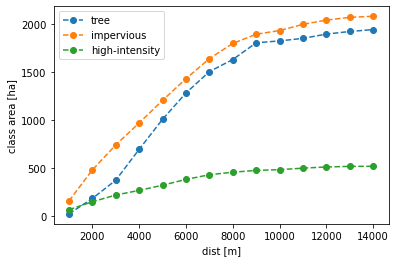

In [10]:
fig, ax = plt.subplots()
for class_val, class_df in total_area_df.groupby(total_area_df.index):
    class_df.plot(x='buffer_dists', y='total_area', style='--o', label=LABEL_DICT[class_val], ax=ax)
plt.xlabel('dist [m]')
plt.ylabel('class area [ha]')
plt.legend()

### TODO:

* radial analysis of LST
* radial analysis of T_air

In [40]:
import salem
import xarray as xr

from lausanne_greening_scenarios import utils

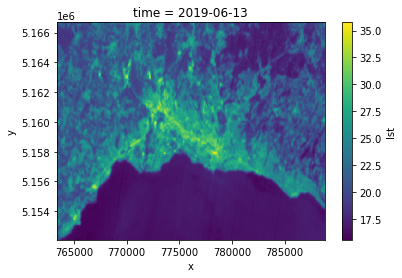

In [13]:
lst_da_filepath = '../data/interim/lst-da.nc'
lst_da = xr.open_dataarray(lst_da_filepath)
lst_da.isel(time=3).plot()

In [20]:
lulc_da = salem.open_xr_dataset(lulc_raster_filepath)['data']

In [22]:
xr.concat([lulc_da. for i in range(2)], )

TypeError: concat() missing 1 required positional argument: 'dim'

In [23]:
ba.masks_arr.shape

(14, 1052, 2131)

('buffer_dist', 'y', 'x')

In [30]:
{'buffer_dist': buffer_dists, **lulc_da.coords}

{'buffer_dist': array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
        10000, 11000, 12000, 13000, 14000]),
 'x': <xarray.DataArray 'x' (x: 2131)>
 array([2524843., 2524853., 2524863., ..., 2546123., 2546133., 2546143.])
 Coordinates:
   * x        (x) float64 2.525e+06 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06,
 'y': <xarray.DataArray 'y' (y: 1052)>
 array([1159128., 1159118., 1159108., ..., 1148638., 1148628., 1148618.])
 Coordinates:
   * y        (y) float64 1.159e+06 1.159e+06 1.159e+06 ... 1.149e+06 1.149e+06}

In [61]:
# buffer_masks_da = xr.DataArray(ba.masks_arr.astype(np.uint8), dims=('buffer_dist', *lulc_da.dims), coords={'buffer_dist': buffer_dists, **lulc_da.coords}, attrs=lulc_da.attrs)
buffer_masks_da = utils.align_ds(xr.DataArray(ba.masks_arr.astype(np.uint8), dims=('buffer_dist', *lulc_da.dims), coords={'buffer_dist': buffer_dists, **lulc_da.coords}, attrs=lulc_da.attrs), lst_da, interp='nearest')

In [ ]:
buffer_masks_da

In [106]:
def compute_mean_lst_da(buffer_mask_da, lst_da):
    buffer_mask_cond = buffer_mask_da == 1
    return lst_da.groupby('time').apply(lambda lst_day_da: lst_day_da.where(buffer_mask_cond).mean())

In [112]:
da = buffer_masks_da.groupby('buffer_dist').apply(compute_mean_lst_da, args=(lst_da,))

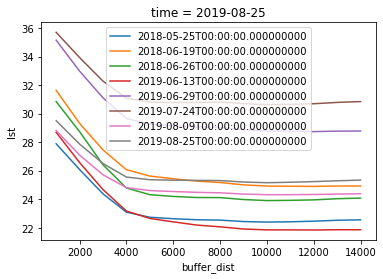

In [120]:
fig, ax = plt.subplots()
for date, group_da in da.groupby('time'):
    group_da.plot(ax=ax, label=date)
ax.legend()

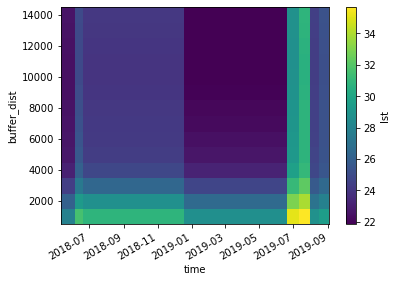

In [91]:
da.plot('buffer_dist')

In [79]:
for buffer_dist, buffer_mask_da in buffer_masks_da.groupby('buffer_dist'):
    buffer_mask_cond = buffer_mask_da == 1
    lst_da.groupby('time').apply(lambda lst_day_da: lst_day_da.where(buffer_mask_cond).mean())
    break

In [82]:
lst_da.groupby('time').apply(lambda lst_day_da: lst_day_da.where(buffer_mask_cond).mean())

<xarray.DataArray 'lst' (time: 8)>
array([27.88856663, 31.63421068, 30.84561088, 28.69120629, 35.14840476,
       35.70090579, 28.8185945 , 29.51038374])
Coordinates:
    buffer_dist  int64 1000
  * time         (time) datetime64[ns] 2018-05-25 2018-06-19 ... 2019-08-25

In [78]:
lst_day_da.where(buffer_mask_da == 1).mean()

<xarray.DataArray 'lst' ()>
array(27.88856663)
Coordinates:
    time         datetime64[ns] 2018-05-25
    buffer_dist  int64 1000

<xarray.DataArray 'lst' (y: 487, x: 848)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 5.167e+06 5.167e+06 ... 5.152e+06 5.152e+06
  * x            (x) float64 7.634e+05 7.634e+05 ... 7.888e+05 7.888e+05
    time         datetime64[ns] 2018-05-25
    buffer_dist  int64 1000
Attributes:
    pyproj_srs:  +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs

In [69]:
lst_day_da

<xarray.DataArray 'lst' (y: 487, x: 848)>
[412976 values with dtype=float64]
Coordinates:
  * y        (y) float64 5.167e+06 5.167e+06 5.167e+06 ... 5.152e+06 5.152e+06
  * x        (x) float64 7.634e+05 7.634e+05 7.635e+05 ... 7.888e+05 7.888e+05
    time     datetime64[ns] 2018-05-25
Attributes:
    pyproj_srs:  +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs

In [41]:
utils.align_ds(lst_da, buffer_masks_da)

<xarray.DataArray 'lst' (time: 8, y: 1052, x: 2131)>
array([[[25.19729462, 25.31953419, 25.44215813, ..., 20.75492068,
         20.84639514, 20.95109706],
        [24.80881247, 24.92268184, 25.03744175, ..., 20.81483507,
         20.90598907, 21.01024575],
        [24.41893358, 24.52493894, 24.63183483, ..., 20.87471317,
         20.96554672, 21.0691733 ],
        ...,
        [28.09498776, 27.96609327, 27.70185867, ..., 17.49161084,
         17.49332686, 17.4949479 ],
        [27.98808615, 27.85296468, 27.60065745, ..., 17.49241724,
         17.49497319, 17.49743417],
        [27.88123107, 27.74118515, 27.50080529, ..., 17.49102411,
         17.49543704, 17.49969091]],

       [[24.28643566, 24.37285713, 24.45973562, ..., 23.92091052,
         24.28788209, 24.63139752],
        [24.14941044, 24.22931755, 24.30993382, ..., 24.07503339,
         24.43495147, 24.75981265],
        [24.01142393, 24.08506882, 24.15942287, ..., 24.22835767,
         24.58122224, 24.88596614],
        ...,
        [29.91831246, 29.81047601, 29.60821894, ..., 20.18685874,
         20.1937239 , 20.20055741],
        [29.84327521, 29.72629565, 29.52264225, ..., 20.17338321,
         20.18052835, 20.18764183],
        [29.76783252, 29.64195737, 29.43690765, ..., 20.15971949,
         20.16723711, 20.17472423]],

       [[25.05568243, 25.04627009, 25.03655531, ..., 24.85232137,
         25.47990086, 25.85659043],
        [24.98857379, 24.98001905, 24.97134631, ..., 25.10319087,
         25.71383666, 26.03902247],
        [24.92139871, 24.91388602, 24.90625532, ..., 25.35214315,
         25.94585525, 26.21744683],
        ...,
        [30.05999984, 29.92973581, 29.61593305, ..., 17.95638235,
         17.95020887, 17.94394041],
        [29.97245724, 29.8152598 , 29.49738647, ..., 17.93220603,
         17.92687248, 17.92144395],
        [29.88293968, 29.70032341, 29.37837951, ..., 17.90937775,
         17.90443808, 17.8992772 ]],

       ...,

       [[34.74227012, 34.84547779, 34.94832249, ..., 31.66586614,
         31.96309338, 32.09106645],
        [34.62184513, 34.72750151, 34.83287188, ..., 31.80718523,
         32.08000044, 32.18471902],
        [34.50162919, 34.60981124, 34.71770728, ..., 31.94574046,
         32.19414365, 32.27794654],
        ...,
        [33.91250435, 33.75370534, 33.4954633 , ..., 24.0118135 ,
         24.01034955, 24.00885547],
        [33.86436902, 33.70386371, 33.45195467, ..., 24.01436206,
         24.0131646 , 24.011937  ],
        [33.81669789, 33.6547384 , 33.40916236, ..., 24.01822368,
         24.01689065, 24.01531772]],

       [[25.69515157, 25.76795004, 25.8408476 , ..., 23.60478089,
         23.69065564, 23.75801555],
        [25.71902406, 25.78987558, 25.86093523, ..., 23.67770104,
         23.76245926, 23.82856083],
        [25.74257936, 25.81159298, 25.88081473, ..., 23.75049478,
         23.83413647, 23.89919241],
        ...,
        [27.73216351, 27.5818821 , 27.36681435, ..., 20.66992134,
         20.68012039, 20.6901028 ],
        [27.67298477, 27.51863   , 27.30502242, ..., 20.64321364,
         20.65532868, 20.66722709],
        [27.61377018, 27.45554308, 27.24339566, ..., 20.61545096,
         20.62997963, 20.64435346]],

       [[28.17214902, 28.2971268 , 28.42153005, ..., 23.94972236,
         24.08953599, 24.20900317],
        [28.00817816, 28.13561852, 28.26274994, ..., 24.06927917,
         24.20683885, 24.32824969],
        [27.84425065, 27.97441918, 28.10427877, ..., 24.18858078,
         24.32388651, 24.44813971],
        ...,
        [28.51538829, 28.33488431, 28.06667492, ..., 20.55446974,
         20.57029117, 20.58601954],
        [28.41119883, 28.22129004, 27.95646645, ..., 20.55356933,
         20.57021383, 20.58676526],
        [28.30641629, 28.10807875, 27.84664095, ..., 20.55368318,
         20.57071769, 20.58772132]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-25 2018-06-19 ... 2019-08-25
  * x        (x) float64 2.525e+06 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06
  * y   

In [42]:
_.shape

(8, 1052, 2131)

In [43]:
buffer_mask_da.shape

(14, 1052, 2131)

In [ ]:
    # add the date
    lst_da = lst_da.assign_coords({
        'time':
        pd.to_datetime(mtl_dict['PRODUCT_METADATA']['DATE_ACQUIRED'])
    })


In [ ]:
for buffer_dist, mask_arr in zip(buffer_dists, ba.masks_arr):
    buffer_mask_da = xr.DataArray(mask_arr, dims=dims, coords=coords, attrs=proj_attrs)

In [ ]:
for buffer_dist in buffer_dists:
    lst_da.salem.roi(geometry=base_mask.buffer(buffer_dist)).plot()

In [51]:
import logging
import tempfile
from os import path

import click
import geopandas as gpd
import numpy as np
import pandas as pd
import pylandsat
import salem
import xarray as xr
from rio_toa import brightness_temp

from lausanne_greening_scenarios import settings, utils

DATETIME_FMT = '%Y-%m-%d'

LANDSAT_FILES = ['B3.TIF', 'B4.TIF', 'B5.TIF', 'B10.TIF', 'MTL.txt']
LANDSAT_META_KEYS = ['RADIOMETRIC_RESCALING', 'TIRS_THERMAL_CONSTANTS']
LANDSAT_NODATA = 0

# TODO: the "parameters" should be customizable by means of arguments or a
# settings module
C = 0.005
ndvi_soil = 0.2
ndvi_veg = 0.5
eps_water = 0.991
eps_soil = 0.996
eps_veg = 0.973

lambd = 10.895e-9
rho = 1.439e-2  # 6.626e-34 * 2.998e8 / 1.38e-23


def compute_ndvi(landsat_ds):
    # ground emissivity (bands 4 and 5)
    b4_arr = landsat_ds['red'].values.astype(np.int32)
    b5_arr = landsat_ds['nir'].values.astype(np.int32)
    # nan values and zero division
    b4_plus_b5_arr = b5_arr + b4_arr

    return np.where(b4_plus_b5_arr == 0, LANDSAT_NODATA,
                    (b5_arr - b4_arr) / b4_plus_b5_arr)


def compute_lst(landsat_ds, mtl_dict, water_body_mask):
    # brightness temperature (band 10)
    radio_rescale = mtl_dict['RADIOMETRIC_RESCALING']
    thermal_constants = mtl_dict['TIRS_THERMAL_CONSTANTS']
    bt_arr = brightness_temp.brightness_temp(
        landsat_ds['tirs'].values, radio_rescale['RADIANCE_MULT_BAND_10'],
        radio_rescale['RADIANCE_ADD_BAND_10'],
        thermal_constants['K1_CONSTANT_BAND_10'],
        thermal_constants['K2_CONSTANT_BAND_10']) - 273.15

    ndvi_arr = compute_ndvi(landsat_ds)
    min_ndvi = ndvi_arr.min()
    pv_arr = np.square((ndvi_arr - min_ndvi) / (ndvi_arr.max() - min_ndvi))

    eps_arr = np.zeros_like(pv_arr)
    eps_arr[water_body_mask] = eps_water
    eps_arr[(ndvi_arr < ndvi_soil) & ~water_body_mask] = eps_soil
    mid_cond = (ndvi_arr >= ndvi_soil) & (ndvi_arr <
                                          ndvi_veg) & ~water_body_mask
    pv_mid_arr = pv_arr[mid_cond]
    eps_arr[mid_cond] = eps_veg * pv_mid_arr + eps_soil * (1 - pv_mid_arr) + C
    eps_arr[(ndvi_arr >= ndvi_veg) & ~water_body_mask] = eps_veg

    # land surface temperature (putting it all together)
    # lst_arr = bt_arr / (1 + (lambd * bt_arr / rho) * np.log(eps_arr))
    lst_arr = bt_arr / (1 + (lambd * bt_arr / rho) * np.log(eps_arr))
    # correct for potential infinities arising from divisions by zero
    # (landsat 8's nodata)
    # lst_arr[~landsat_mask] = landsat_meta['nodata']
    # return np.nan_to_num(lst_arr, LANDSAT_NODATA)
    return lst_arr


def get_lst_da(landsat_tile,
               ref_da=None,
               ref_geom=None,
               lake_geom=None,
               crs=None,
               roi=False,
               subset_kws=None,
               roi_kws=None):
    product = pylandsat.Product(landsat_tile)

    with tempfile.TemporaryDirectory() as tmp_dir:
        product.download(tmp_dir, files=LANDSAT_FILES)

        landsat_tile_dir = path.join(tmp_dir, landsat_tile)

        scene = pylandsat.Scene(landsat_tile_dir)
        bands = scene.available_bands()
        band_filepaths = [getattr(scene, band).fpath for band in bands]

        # create xarray dataset
        landsat_ds = xr.Dataset({
            band: salem.open_xr_dataset(band_filepath)['data']
            for band, band_filepath in zip(bands, band_filepaths)
        })
    # projection attributes need to be set before any geo-transformation
    proj_attrs = landsat_ds[bands[0]].attrs.copy()
    landsat_ds.attrs = proj_attrs

    # landsat metadata that will be used below
    mtl_dict = scene.mtl

    # crop/align to the reference extent
    if ref_da is None:
        landsat_ds = utils.clip_ds_to_extent(landsat_ds,
                                             geometry=ref_geom,
                                             crs=crs,
                                             roi=roi,
                                             subset_kws=subset_kws,
                                             roi_kws=roi_kws)
    else:
        landsat_ds = ref_da.salem.transform(landsat_ds, interp='linear')

    # the lake mask needs to be boolean for NumPy slicing to work properly
    lake_mask = landsat_ds.salem.grid.region_of_interest(geometry=lake_geom,
                                                         crs=crs).astype(bool)

    # LST
    lst_arr = compute_lst(landsat_ds, mtl_dict, lake_mask)

    # assemble the final dataset
    dims = ('y', 'x')
    coords = {
        'x': landsat_ds.salem.grid.x_coord,
        'y': landsat_ds.salem.grid.y_coord
    }
    lst_da = xr.DataArray(lst_arr, dims=dims, coords=coords, attrs=proj_attrs)
    # add the date
    lst_da = lst_da.assign_coords({
        'time':
        pd.to_datetime(mtl_dict['PRODUCT_METADATA']['DATE_ACQUIRED'])
    })

    return lst_da


# read list of landsat tiles (product ids) to process
landsat_tiles = pd.read_csv(landsat_tiles_filepath, header=None)[0]

# get the agglomeration and lake extents
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
crs = agglom_extent_gdf.crs
ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
lake_geom = agglom_extent_gdf.loc[1]['geometry']

# process the list of tiles
lst_das = []
# use a head-tail pattern to get a reference dataset in the first
# iteration and use it to align the datasets of further iterations
ref_da = get_lst_da(landsat_tiles[0],
                    ref_geom=ref_geom,
                    lake_geom=lake_geom,
                    crs=crs)
lst_das.append(ref_da)
for landsat_tile in landsat_tiles[1:]:
    lst_da = get_lst_da(landsat_tile,
                        ref_da=ref_da,
                        lake_geom=lake_geom,
                        crs=crs)
    lst_das.append(lst_da)

lst_da = xr.concat(lst_das, dim='time')

  0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   1%|▏         | 1.05M/83.0M [00:00<00:11, 7.29MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   4%|▍         | 3.15M/83.0M [00:00<00:09, 8.35MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   6%|▋         | 5.24M/83.0M [00:00<00:08, 9.29MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   9%|▉         | 7.34M/83.0M [00:00<00:07, 10.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  11%|█▏        | 9.44M/83.0M [00:00<00:06, 10.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  14%|█▍        | 11.5M/83.0M [00:00<00:06, 11.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  16%|█▋        | 13.6M/83.0M [00:01<00:05, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  19%|█▉        | 15.7M/83.0M [00:01<00:05, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  21%|██▏       | 17.8M/83.0M [00:01<00:05, 11.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  24%|██▍       | 19.9M/83.0M [00:01<00:05, 11.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  27%|██▋       | 22.0M/83.0M [00:01<00:05, 11.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  29%|██▉       | 24.1M/83.0M [00:02<00:04, 12.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  32%|███▏      | 26.2M/83.0M [00:02<00:04, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  34%|███▍      | 28.3M/83.0M [00:02<00:04, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  37%|███▋      | 30.4M/83.0M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  39%|███▉      | 32.5M/83.0M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  42%|████▏     | 34.6M/83.0M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  44%|████▍     | 36.7M/83.0M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  47%|████▋     | 38.8M/83.0M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  49%|████▉     | 40.9M/83.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  52%|█████▏    | 43.0M/83.0M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  54%|█████▍    | 45.1M/83.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  57%|█████▋    | 47.2M/83.0M [00:03<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  59%|█████▉    | 49.3M/83.0M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  62%|██████▏   | 51.4M/83.0M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  64%|██████▍   | 53.5M/83.0M [00:04<00:02, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  67%|██████▋   | 55.6M/83.0M [00:04<00:02, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  69%|██████▉   | 57.7M/83.0M [00:04<00:02, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  72%|███████▏  | 59.8M/83.0M [00:04<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  75%|███████▍  | 61.9M/83.0M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  77%|███████▋  | 64.0M/83.0M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  80%|███████▉  | 66.1M/83.0M [00:05<00:01, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  82%|████████▏ | 68.2M/83.0M [00:05<00:01, 11.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  85%|████████▍ | 70.3M/83.0M [00:05<00:01, 11.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  87%|████████▋ | 72.4M/83.0M [00:05<00:00, 11.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  90%|████████▉ | 74.4M/83.0M [00:06<00:00, 12.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  92%|█████████▏| 76.5M/83.0M [00:06<00:00, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  95%|█████████▍| 78.6M/83.0M [00:06<00:00, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  97%|█████████▋| 80.7M/83.0M [00:06<00:00, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF: 100%|█████████▉| 82.8M/83.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF: : 83.9MB [00:06, 12.3MB/s]                          

  0%|          | 0.00/85.3M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   0%|          | 0.00/85.3M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   1%|          | 1.05M/85.3M [00:00<00:09, 8.65MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   4%|▎         | 3.15M/85.3M [00:00<00:08, 9.57MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   6%|▌         | 5.24M/85.3M [00:00<00:07, 10.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   9%|▊         | 7.34M/85.3M [00:00<00:07, 10.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  11%|█         | 9.44M/85.3M [00:00<00:06, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  14%|█▎        | 11.5M/85.3M [00:00<00:06, 11.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  16%|█▌        | 13.6M/85.3M [00:01<00:06, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  18%|█▊        | 15.7M/85.3M [00:01<00:05, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  21%|██        | 17.8M/85.3M [00:01<00:05, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  23%|██▎       | 19.9M/85.3M [00:01<00:05, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  26%|██▌       | 22.0M/85.3M [00:01<00:05, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  28%|██▊       | 24.1M/85.3M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  31%|███       | 26.2M/85.3M [00:02<00:04, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  33%|███▎      | 28.3M/85.3M [00:02<00:04, 11.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  36%|███▌      | 30.4M/85.3M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  38%|███▊      | 32.5M/85.3M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  41%|████      | 34.6M/85.3M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  43%|████▎     | 36.7M/85.3M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  45%|████▌     | 38.8M/85.3M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  48%|████▊     | 40.9M/85.3M [00:03<00:03, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  50%|█████     | 43.0M/85.3M [00:03<00:03, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  53%|█████▎    | 45.1M/85.3M [00:03<00:03, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  55%|█████▌    | 47.2M/85.3M [00:03<00:03, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  58%|█████▊    | 49.3M/85.3M [00:04<00:03, 11.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  60%|██████    | 51.4M/85.3M [00:04<00:02, 11.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  63%|██████▎   | 53.5M/85.3M [00:04<00:02, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  65%|██████▌   | 55.6M/85.3M [00:04<00:02, 11.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  68%|██████▊   | 57.7M/85.3M [00:04<00:02, 11.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  70%|███████   | 59.8M/85.3M [00:04<00:02, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  73%|███████▎  | 61.9M/85.3M [00:05<00:01, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  75%|███████▍  | 64.0M/85.3M [00:05<00:01, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  77%|███████▋  | 66.1M/85.3M [00:05<00:01, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  80%|███████▉  | 68.2M/85.3M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  82%|████████▏ | 70.3M/85.3M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  85%|████████▍ | 72.4M/85.3M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  87%|████████▋ | 74.4M/85.3M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  90%|████████▉ | 76.5M/85.3M [00:06<00:00, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  92%|█████████▏| 78.6M/85.3M [00:06<00:00, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  95%|█████████▍| 80.7M/85.3M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  97%|█████████▋| 82.8M/85.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF: 100%|█████████▉| 84.9M/85.3M [00:06<00:00, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF: : 86.0MB [00:07, 12.2MB/s]                          

  0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   1%|          | 1.05M/100M [00:00<00:11, 8.62MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   3%|▎         | 3.15M/100M [00:00<00:10, 9.53MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   5%|▌         | 5.24M/100M [00:00<00:09, 10.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   7%|▋         | 7.34M/100M [00:00<00:08, 10.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   9%|▉         | 9.44M/100M [00:00<00:08, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  12%|█▏        | 11.5M/100M [00:00<00:07, 11.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  14%|█▎        | 13.6M/100M [00:01<00:07, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  16%|█▌        | 15.7M/100M [00:01<00:06, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  18%|█▊        | 17.8M/100M [00:01<00:06, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  20%|█▉        | 19.9M/100M [00:01<00:06, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  22%|██▏       | 22.0M/100M [00:01<00:06, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  24%|██▍       | 24.1M/100M [00:01<00:06, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  26%|██▌       | 26.2M/100M [00:02<00:05, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  28%|██▊       | 28.3M/100M [00:02<00:06, 11.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  30%|███       | 30.4M/100M [00:02<00:06, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  32%|███▏      | 32.5M/100M [00:02<00:05, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  35%|███▍      | 34.6M/100M [00:02<00:05, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  37%|███▋      | 36.7M/100M [00:03<00:05, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  39%|███▊      | 38.8M/100M [00:03<00:05, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  41%|████      | 40.9M/100M [00:03<00:04, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  43%|████▎     | 43.0M/100M [00:03<00:04, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  45%|████▍     | 45.1M/100M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  47%|████▋     | 47.2M/100M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  49%|████▉     | 49.3M/100M [00:04<00:04, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  51%|█████     | 51.4M/100M [00:04<00:04, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  53%|█████▎    | 53.5M/100M [00:04<00:04, 11.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  55%|█████▌    | 55.6M/100M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  58%|█████▊    | 57.7M/100M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  60%|█████▉    | 59.8M/100M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  62%|██████▏   | 61.9M/100M [00:05<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  64%|██████▍   | 64.0M/100M [00:05<00:02, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  66%|██████▌   | 66.1M/100M [00:05<00:02, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  68%|██████▊   | 68.2M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  70%|███████   | 70.3M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  72%|███████▏  | 72.4M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  74%|███████▍  | 74.4M/100M [00:06<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  76%|███████▋  | 76.5M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  78%|███████▊  | 78.6M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  81%|████████  | 80.7M/100M [00:06<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  83%|████████▎ | 82.8M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  85%|████████▍ | 84.9M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  87%|████████▋ | 87.0M/100M [00:07<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  89%|████████▉ | 89.1M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  91%|█████████ | 91.2M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  93%|█████████▎| 93.3M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  95%|█████████▌| 95.4M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  97%|█████████▋| 97.5M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  99%|█████████▉| 99.6M/100M [00:08<00:00, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF: : 101MB [00:08, 12.3MB/s]                          

  0%|          | 0.00/66.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   2%|▏         | 1.05M/66.0M [00:00<00:07, 8.23MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   5%|▍         | 3.15M/66.0M [00:00<00:06, 9.17MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   8%|▊         | 5.24M/66.0M [00:00<00:06, 9.78MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  11%|█         | 7.34M/66.0M [00:00<00:05, 10.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  14%|█▍        | 9.44M/66.0M [00:00<00:05, 11.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  17%|█▋        | 11.5M/66.0M [00:00<00:04, 11.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  21%|██        | 13.6M/66.0M [00:01<00:04, 11.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  24%|██▍       | 15.7M/66.0M [00:01<00:04, 12.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  27%|██▋       | 17.8M/66.0M [00:01<00:03, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  30%|███       | 19.9M/66.0M [00:01<00:03, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  33%|███▎      | 22.0M/66.0M [00:01<00:03, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  37%|███▋      | 24.1M/66.0M [00:01<00:03, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  40%|███▉      | 26.2M/66.0M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  43%|████▎     | 28.3M/66.0M [00:02<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  46%|████▌     | 30.4M/66.0M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  49%|████▉     | 32.5M/66.0M [00:02<00:02, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  52%|█████▏    | 34.6M/66.0M [00:02<00:02, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  56%|█████▌    | 36.7M/66.0M [00:03<00:02, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  59%|█████▉    | 38.8M/66.0M [00:03<00:02, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  62%|██████▏   | 40.9M/66.0M [00:03<00:02, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  65%|██████▌   | 43.0M/66.0M [00:03<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  68%|██████▊   | 45.1M/66.0M [00:03<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  72%|███████▏  | 47.2M/66.0M [00:03<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  75%|███████▍  | 49.3M/66.0M [00:04<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  78%|███████▊  | 51.4M/66.0M [00:04<00:01, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  81%|████████  | 53.5M/66.0M [00:04<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  84%|████████▍ | 55.6M/66.0M [00:04<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  87%|████████▋ | 57.7M/66.0M [00:04<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  91%|█████████ | 59.8M/66.0M [00:04<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  94%|█████████▍| 61.9M/66.0M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  97%|█████████▋| 64.0M/66.0M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF: : 66.1MB [00:05, 12.8MB/s]                          

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF: : 66.1MB [00:05, 12.4MB/s]

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_MTL.txt: : 1.05MB [00:00, 146MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/86.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   0%|          | 0.00/86.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   1%|          | 1.05M/86.3M [00:00<00:14, 6.09MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   4%|▎         | 3.15M/86.3M [00:00<00:11, 7.20MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   6%|▌         | 5.24M/86.3M [00:00<00:09, 8.26MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   9%|▊         | 7.34M/86.3M [00:00<00:08, 9.21MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  11%|█         | 9.44M/86.3M [00:00<00:07, 9.99MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  13%|█▎        | 11.5M/86.3M [00:01<00:07, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  16%|█▌        | 13.6M/86.3M [00:01<00:06, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  18%|█▊        | 15.7M/86.3M [00:01<00:06, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  21%|██        | 17.8M/86.3M [00:01<00:06, 10.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  23%|██▎       | 19.9M/86.3M [00:01<00:05, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  26%|██▌       | 22.0M/86.3M [00:01<00:05, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  28%|██▊       | 24.1M/86.3M [00:02<00:05, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  30%|███       | 26.2M/86.3M [00:02<00:04, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  33%|███▎      | 28.3M/86.3M [00:02<00:04, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  35%|███▌      | 30.4M/86.3M [00:02<00:04, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  38%|███▊      | 32.5M/86.3M [00:02<00:04, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  40%|████      | 34.6M/86.3M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  43%|████▎     | 36.7M/86.3M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  45%|████▍     | 38.8M/86.3M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  47%|████▋     | 40.9M/86.3M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  50%|████▉     | 43.0M/86.3M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  52%|█████▏    | 45.1M/86.3M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  55%|█████▍    | 47.2M/86.3M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  57%|█████▋    | 49.3M/86.3M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  60%|█████▉    | 51.4M/86.3M [00:04<00:03, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  62%|██████▏   | 53.5M/86.3M [00:04<00:02, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  64%|██████▍   | 55.6M/86.3M [00:04<00:02, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  67%|██████▋   | 57.7M/86.3M [00:04<00:02, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  69%|██████▉   | 59.8M/86.3M [00:04<00:02, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  72%|███████▏  | 61.9M/86.3M [00:05<00:02, 11.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  74%|███████▍  | 64.0M/86.3M [00:05<00:01, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  77%|███████▋  | 66.1M/86.3M [00:05<00:01, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  79%|███████▉  | 68.2M/86.3M [00:05<00:01, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  81%|████████▏ | 70.3M/86.3M [00:05<00:01, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  84%|████████▍ | 72.4M/86.3M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  86%|████████▌ | 74.4M/86.3M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  89%|████████▊ | 76.5M/86.3M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  91%|█████████ | 78.6M/86.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  94%|█████████▎| 80.7M/86.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  96%|█████████▌| 82.8M/86.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  98%|█████████▊| 84.9M/86.3M [00:07<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF: : 87.0MB [00:07, 13.6MB/s]                          

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF: : 87.0MB [00:07, 12.2MB/s]

  0%|          | 0.00/88.4M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   0%|          | 0.00/88.4M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   1%|          | 1.05M/88.4M [00:00<00:12, 6.93MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   4%|▎         | 3.15M/88.4M [00:00<00:10, 8.01MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   6%|▌         | 5.24M/88.4M [00:00<00:09, 8.99MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   8%|▊         | 7.34M/88.4M [00:00<00:08, 9.82MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  11%|█         | 9.44M/88.4M [00:00<00:07, 10.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  13%|█▎        | 11.5M/88.4M [00:00<00:06, 11.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  15%|█▌        | 13.6M/88.4M [00:01<00:06, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  18%|█▊        | 15.7M/88.4M [00:01<00:06, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  20%|██        | 17.8M/88.4M [00:01<00:05, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  23%|██▎       | 19.9M/88.4M [00:01<00:05, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  25%|██▍       | 22.0M/88.4M [00:01<00:05, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  27%|██▋       | 24.1M/88.4M [00:02<00:05, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  30%|██▉       | 26.2M/88.4M [00:02<00:05, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  32%|███▏      | 28.3M/88.4M [00:02<00:05, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  34%|███▍      | 30.4M/88.4M [00:02<00:04, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  37%|███▋      | 32.5M/88.4M [00:02<00:04, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  39%|███▉      | 34.6M/88.4M [00:02<00:04, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  41%|████▏     | 36.7M/88.4M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  44%|████▍     | 38.8M/88.4M [00:03<00:04, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  46%|████▌     | 40.9M/88.4M [00:03<00:03, 12.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  49%|████▊     | 43.0M/88.4M [00:03<00:03, 12.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  51%|█████     | 45.1M/88.4M [00:03<00:03, 12.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  53%|█████▎    | 47.2M/88.4M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  56%|█████▌    | 49.3M/88.4M [00:04<00:03, 12.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  58%|█████▊    | 51.4M/88.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  60%|██████    | 53.5M/88.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  63%|██████▎   | 55.6M/88.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  65%|██████▌   | 57.7M/88.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  68%|██████▊   | 59.8M/88.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  70%|██████▉   | 61.9M/88.4M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  72%|███████▏  | 64.0M/88.4M [00:05<00:02, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  75%|███████▍  | 66.1M/88.4M [00:05<00:01, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  77%|███████▋  | 68.2M/88.4M [00:05<00:01, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  79%|███████▉  | 70.3M/88.4M [00:05<00:01, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  82%|████████▏ | 72.4M/88.4M [00:05<00:01, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  84%|████████▍ | 74.4M/88.4M [00:06<00:01, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  87%|████████▋ | 76.5M/88.4M [00:06<00:00, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  89%|████████▉ | 78.6M/88.4M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  91%|█████████▏| 80.7M/88.4M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  94%|█████████▎| 82.8M/88.4M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  96%|█████████▌| 84.9M/88.4M [00:06<00:00, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  98%|█████████▊| 87.0M/88.4M [00:07<00:00, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF: : 89.1MB [00:07, 13.6MB/s]                          

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF: : 89.1MB [00:07, 12.4MB/s]

  0%|          | 0.00/102M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   0%|          | 0.00/102M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   1%|          | 1.05M/102M [00:00<00:19, 5.06MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   3%|▎         | 3.15M/102M [00:00<00:16, 6.17MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   5%|▌         | 5.24M/102M [00:00<00:13, 7.20MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   7%|▋         | 7.34M/102M [00:00<00:11, 8.27MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   9%|▉         | 9.44M/102M [00:00<00:11, 8.00MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  11%|█▏        | 11.5M/102M [00:01<00:10, 8.98MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  13%|█▎        | 13.6M/102M [00:01<00:08, 9.82MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  15%|█▌        | 15.7M/102M [00:01<00:08, 10.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  18%|█▊        | 17.8M/102M [00:01<00:08, 9.93MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  20%|█▉        | 19.9M/102M [00:01<00:07, 10.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  22%|██▏       | 22.0M/102M [00:02<00:07, 11.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  24%|██▎       | 24.1M/102M [00:02<00:06, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  26%|██▌       | 26.2M/102M [00:02<00:07, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  28%|██▊       | 28.3M/102M [00:02<00:06, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  30%|██▉       | 30.4M/102M [00:02<00:07, 10.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  31%|███       | 31.5M/102M [00:03<00:06, 10.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  33%|███▎      | 33.6M/102M [00:03<00:06, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  35%|███▌      | 35.7M/102M [00:03<00:06, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  37%|███▋      | 37.7M/102M [00:03<00:05, 10.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  39%|███▉      | 39.8M/102M [00:03<00:05, 11.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  41%|████      | 41.9M/102M [00:03<00:05, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  43%|████▎     | 44.0M/102M [00:04<00:05, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  45%|████▌     | 46.1M/102M [00:04<00:05, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  47%|████▋     | 48.2M/102M [00:04<00:04, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  49%|████▉     | 50.3M/102M [00:04<00:04, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  51%|█████▏    | 52.4M/102M [00:04<00:04, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  54%|█████▎    | 54.5M/102M [00:04<00:03, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  56%|█████▌    | 56.6M/102M [00:05<00:03, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  58%|█████▊    | 58.7M/102M [00:05<00:03, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  60%|█████▉    | 60.8M/102M [00:05<00:03, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  62%|██████▏   | 62.9M/102M [00:05<00:03, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  64%|██████▍   | 65.0M/102M [00:05<00:03, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  66%|██████▌   | 67.1M/102M [00:06<00:02, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  68%|██████▊   | 69.2M/102M [00:06<00:02, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  70%|███████   | 71.3M/102M [00:06<00:02, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  72%|███████▏  | 73.4M/102M [00:06<00:02, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  74%|███████▍  | 75.5M/102M [00:06<00:02, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  76%|███████▌  | 77.6M/102M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  78%|███████▊  | 79.7M/102M [00:07<00:01, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  80%|████████  | 81.8M/102M [00:07<00:01, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  82%|████████▏ | 83.9M/102M [00:07<00:01, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  84%|████████▍ | 86.0M/102M [00:07<00:01, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  86%|████████▋ | 88.1M/102M [00:07<00:01, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  89%|████████▊ | 90.2M/102M [00:07<00:01, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  91%|█████████ | 92.3M/102M [00:08<00:00, 11.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  93%|█████████▎| 94.4M/102M [00:08<00:00, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  95%|█████████▍| 96.5M/102M [00:08<00:00, 10.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  96%|█████████▌| 97.5M/102M [00:08<00:00, 8.87MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  98%|█████████▊| 99.6M/102M [00:08<00:00, 8.97MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF: 100%|█████████▉| 102M/102M [00:09<00:00, 6.84MB/s] 

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF: : 103MB [00:09, 10.9MB/s]                         

  0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   2%|▏         | 1.05M/67.7M [00:00<00:07, 9.20MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   5%|▍         | 3.15M/67.7M [00:00<00:06, 9.96MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   8%|▊         | 5.24M/67.7M [00:00<00:05, 10.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  11%|█         | 7.34M/67.7M [00:00<00:05, 11.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  14%|█▍        | 9.44M/67.7M [00:00<00:05, 11.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  17%|█▋        | 11.5M/67.7M [00:00<00:04, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  20%|██        | 13.6M/67.7M [00:01<00:04, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  23%|██▎       | 15.7M/67.7M [00:01<00:04, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  26%|██▋       | 17.8M/67.7M [00:01<00:04, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  29%|██▉       | 19.9M/67.7M [00:01<00:04, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  33%|███▎      | 22.0M/67.7M [00:01<00:04, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  36%|███▌      | 24.1M/67.7M [00:02<00:03, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  39%|███▊      | 26.2M/67.7M [00:02<00:03, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  42%|████▏     | 28.3M/67.7M [00:02<00:03, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  45%|████▍     | 30.4M/67.7M [00:02<00:03, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  48%|████▊     | 32.5M/67.7M [00:02<00:02, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  51%|█████     | 34.6M/67.7M [00:02<00:02, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  54%|█████▍    | 36.7M/67.7M [00:03<00:02, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  57%|█████▋    | 38.8M/67.7M [00:03<00:02, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  60%|██████    | 40.9M/67.7M [00:03<00:02, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  64%|██████▎   | 43.0M/67.7M [00:03<00:02, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  67%|██████▋   | 45.1M/67.7M [00:03<00:01, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  70%|██████▉   | 47.2M/67.7M [00:03<00:01, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  73%|███████▎  | 49.3M/67.7M [00:04<00:01, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  76%|███████▌  | 51.4M/67.7M [00:04<00:01, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  79%|███████▉  | 53.5M/67.7M [00:04<00:01, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  82%|████████▏ | 55.6M/67.7M [00:04<00:01, 10.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  84%|████████▎ | 56.6M/67.7M [00:04<00:01, 9.74MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  87%|████████▋ | 58.7M/67.7M [00:05<00:00, 9.65MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  90%|████████▉ | 60.8M/67.7M [00:05<00:00, 10.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  93%|█████████▎| 62.9M/67.7M [00:05<00:00, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  96%|█████████▌| 65.0M/67.7M [00:05<00:00, 11.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  99%|█████████▉| 67.1M/67.7M [00:05<00:00, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF: : 68.2MB [00:05, 11.6MB/s]                          

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_MTL.txt: : 1.05MB [00:00, 330MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/83.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   0%|          | 0.00/83.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   1%|▏         | 1.05M/83.4M [00:00<00:09, 8.79MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   4%|▍         | 3.15M/83.4M [00:00<00:08, 9.65MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   6%|▋         | 5.24M/83.4M [00:00<00:07, 10.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   9%|▉         | 7.34M/83.4M [00:00<00:06, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  11%|█▏        | 9.44M/83.4M [00:00<00:07, 10.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  13%|█▎        | 10.5M/83.4M [00:00<00:07, 10.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  15%|█▌        | 12.6M/83.4M [00:01<00:06, 10.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  18%|█▊        | 14.7M/83.4M [00:01<00:06, 10.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  20%|██        | 16.8M/83.4M [00:01<00:05, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  23%|██▎       | 18.9M/83.4M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  25%|██▌       | 21.0M/83.4M [00:01<00:05, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  28%|██▊       | 23.1M/83.4M [00:01<00:05, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  30%|███       | 25.2M/83.4M [00:02<00:05, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  33%|███▎      | 27.3M/83.4M [00:02<00:05, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  35%|███▌      | 29.4M/83.4M [00:02<00:04, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  38%|███▊      | 31.5M/83.4M [00:02<00:04, 10.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  40%|████      | 33.6M/83.4M [00:02<00:04, 10.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  43%|████▎     | 35.7M/83.4M [00:03<00:04, 11.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  45%|████▌     | 37.7M/83.4M [00:03<00:03, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  48%|████▊     | 39.8M/83.4M [00:03<00:03, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  50%|█████     | 41.9M/83.4M [00:03<00:03, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  53%|█████▎    | 44.0M/83.4M [00:03<00:03, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  55%|█████▌    | 46.1M/83.4M [00:04<00:03, 11.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  58%|█████▊    | 48.2M/83.4M [00:04<00:03, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  60%|██████    | 50.3M/83.4M [00:04<00:02, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  63%|██████▎   | 52.4M/83.4M [00:04<00:02, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  65%|██████▌   | 54.5M/83.4M [00:04<00:02, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  68%|██████▊   | 56.6M/83.4M [00:04<00:02, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  70%|███████   | 58.7M/83.4M [00:05<00:02, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  73%|███████▎  | 60.8M/83.4M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  75%|███████▌  | 62.9M/83.4M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  78%|███████▊  | 65.0M/83.4M [00:05<00:01, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  80%|████████  | 67.1M/83.4M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  83%|████████▎ | 69.2M/83.4M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  86%|████████▌ | 71.3M/83.4M [00:06<00:01, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  88%|████████▊ | 73.4M/83.4M [00:06<00:00, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  91%|█████████ | 75.5M/83.4M [00:06<00:00, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  93%|█████████▎| 77.6M/83.4M [00:06<00:00, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  96%|█████████▌| 79.7M/83.4M [00:06<00:00, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  98%|█████████▊| 81.8M/83.4M [00:07<00:00, 11.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF: : 83.9MB [00:07, 11.8MB/s]                          

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF: : 83.9MB [00:07, 11.6MB/s]

  0%|          | 0.00/86.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   1%|          | 1.05M/86.7M [00:00<00:10, 8.27MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   4%|▎         | 3.15M/86.7M [00:00<00:09, 9.20MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   6%|▌         | 5.24M/86.7M [00:00<00:08, 10.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   8%|▊         | 7.34M/86.7M [00:00<00:07, 10.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  11%|█         | 9.44M/86.7M [00:00<00:08, 8.75MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  13%|█▎        | 11.5M/86.7M [00:01<00:07, 9.65MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  16%|█▌        | 13.6M/86.7M [00:01<00:07, 10.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  18%|█▊        | 15.7M/86.7M [00:01<00:06, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  21%|██        | 17.8M/86.7M [00:01<00:06, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  23%|██▎       | 19.9M/86.7M [00:01<00:06, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  25%|██▌       | 22.0M/86.7M [00:02<00:05, 11.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  28%|██▊       | 24.1M/86.7M [00:02<00:05, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  30%|███       | 26.2M/86.7M [00:02<00:05, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  33%|███▎      | 28.3M/86.7M [00:02<00:05, 11.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  35%|███▌      | 30.4M/86.7M [00:02<00:04, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  37%|███▋      | 32.5M/86.7M [00:02<00:04, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  40%|███▉      | 34.6M/86.7M [00:03<00:04, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  42%|████▏     | 36.7M/86.7M [00:03<00:04, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  45%|████▍     | 38.8M/86.7M [00:03<00:04, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  47%|████▋     | 40.9M/86.7M [00:03<00:04, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  50%|████▉     | 43.0M/86.7M [00:03<00:04, 9.39MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  52%|█████▏    | 45.1M/86.7M [00:04<00:04, 10.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  54%|█████▍    | 47.2M/86.7M [00:04<00:03, 10.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  57%|█████▋    | 49.3M/86.7M [00:04<00:03, 11.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  59%|█████▉    | 51.4M/86.7M [00:04<00:03, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  62%|██████▏   | 53.5M/86.7M [00:04<00:03, 11.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  64%|██████▍   | 55.6M/86.7M [00:04<00:02, 11.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  66%|██████▋   | 57.7M/86.7M [00:05<00:02, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  69%|██████▉   | 59.8M/86.7M [00:05<00:02, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  71%|███████▏  | 61.9M/86.7M [00:05<00:02, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  74%|███████▎  | 64.0M/86.7M [00:05<00:01, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  76%|███████▌  | 66.1M/86.7M [00:05<00:01, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  79%|███████▊  | 68.2M/86.7M [00:06<00:01, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  81%|████████  | 70.3M/86.7M [00:06<00:01, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  83%|████████▎ | 72.4M/86.7M [00:06<00:01, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  86%|████████▌ | 74.4M/86.7M [00:06<00:00, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  88%|████████▊ | 76.5M/86.7M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  91%|█████████ | 78.6M/86.7M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  93%|█████████▎| 80.7M/86.7M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  96%|█████████▌| 82.8M/86.7M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  98%|█████████▊| 84.9M/86.7M [00:07<00:00, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF: : 87.0MB [00:07, 12.6MB/s]                          

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF: : 87.0MB [00:07, 11.6MB/s]

  0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   1%|          | 1.05M/101M [00:00<00:18, 5.54MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   3%|▎         | 3.15M/101M [00:00<00:14, 6.66MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   5%|▌         | 5.24M/101M [00:00<00:12, 7.66MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   6%|▌         | 6.29M/101M [00:00<00:11, 8.27MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   8%|▊         | 8.39M/101M [00:00<00:10, 9.21MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  10%|█         | 10.5M/101M [00:01<00:09, 9.59MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  12%|█▏        | 12.6M/101M [00:01<00:08, 9.96MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  15%|█▍        | 14.7M/101M [00:01<00:08, 10.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  16%|█▌        | 15.7M/101M [00:01<00:08, 10.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  18%|█▊        | 17.8M/101M [00:01<00:08, 10.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  20%|█▉        | 19.9M/101M [00:01<00:07, 10.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  22%|██▏       | 22.0M/101M [00:02<00:07, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  24%|██▍       | 24.1M/101M [00:02<00:06, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  26%|██▌       | 26.2M/101M [00:02<00:07, 10.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  28%|██▊       | 28.3M/101M [00:02<00:06, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  30%|███       | 30.4M/101M [00:02<00:06, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  32%|███▏      | 32.5M/101M [00:02<00:05, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  34%|███▍      | 34.6M/101M [00:03<00:06, 10.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  36%|███▋      | 36.7M/101M [00:03<00:05, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  38%|███▊      | 38.8M/101M [00:03<00:05, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  40%|████      | 40.9M/101M [00:03<00:05, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  43%|████▎     | 43.0M/101M [00:03<00:05, 11.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  45%|████▍     | 45.1M/101M [00:04<00:04, 11.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  47%|████▋     | 47.2M/101M [00:04<00:04, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  49%|████▊     | 49.3M/101M [00:04<00:04, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  51%|█████     | 51.4M/101M [00:04<00:04, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  53%|█████▎    | 53.5M/101M [00:04<00:03, 12.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  55%|█████▍    | 55.6M/101M [00:04<00:03, 12.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  57%|█████▋    | 57.7M/101M [00:05<00:03, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  59%|█████▉    | 59.8M/101M [00:05<00:03, 11.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  61%|██████    | 61.9M/101M [00:05<00:03, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  63%|██████▎   | 64.0M/101M [00:05<00:03, 10.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  65%|██████▌   | 66.1M/101M [00:05<00:03, 10.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  67%|██████▋   | 68.2M/101M [00:06<00:02, 11.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  69%|██████▉   | 70.3M/101M [00:06<00:02, 11.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  72%|███████▏  | 72.4M/101M [00:06<00:02, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  74%|███████▎  | 74.4M/101M [00:06<00:02, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  76%|███████▌  | 76.5M/101M [00:06<00:02, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  78%|███████▊  | 78.6M/101M [00:06<00:01, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  80%|███████▉  | 80.7M/101M [00:07<00:01, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  82%|████████▏ | 82.8M/101M [00:07<00:01, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  84%|████████▍ | 84.9M/101M [00:07<00:01, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  86%|████████▌ | 87.0M/101M [00:07<00:01, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  88%|████████▊ | 89.1M/101M [00:07<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  90%|█████████ | 91.2M/101M [00:07<00:00, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  92%|█████████▏| 93.3M/101M [00:08<00:00, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  94%|█████████▍| 95.4M/101M [00:08<00:00, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  96%|█████████▋| 97.5M/101M [00:08<00:00, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  99%|█████████▊| 99.6M/101M [00:08<00:00, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF: : 102MB [00:08, 13.4MB/s]                          

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF: : 102MB [00:08, 11.5MB/s]

  0%|          | 0.00/67.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   2%|▏         | 1.05M/67.2M [00:00<00:08, 7.57MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   5%|▍         | 3.15M/67.2M [00:00<00:07, 8.58MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   8%|▊         | 5.24M/67.2M [00:00<00:06, 9.43MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  11%|█         | 7.34M/67.2M [00:00<00:05, 10.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  14%|█▍        | 9.44M/67.2M [00:00<00:05, 10.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  17%|█▋        | 11.5M/67.2M [00:00<00:04, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  20%|██        | 13.6M/67.2M [00:01<00:04, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  23%|██▎       | 15.7M/67.2M [00:01<00:04, 11.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  27%|██▋       | 17.8M/67.2M [00:01<00:04, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  30%|██▉       | 19.9M/67.2M [00:01<00:04, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  33%|███▎      | 22.0M/67.2M [00:01<00:03, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  36%|███▌      | 24.1M/67.2M [00:02<00:03, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  39%|███▉      | 26.2M/67.2M [00:02<00:03, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  42%|████▏     | 28.3M/67.2M [00:02<00:03, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  45%|████▌     | 30.4M/67.2M [00:02<00:03, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  48%|████▊     | 32.5M/67.2M [00:02<00:02, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  51%|█████▏    | 34.6M/67.2M [00:02<00:02, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  55%|█████▍    | 36.7M/67.2M [00:03<00:02, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  58%|█████▊    | 38.8M/67.2M [00:03<00:02, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  61%|██████    | 40.9M/67.2M [00:03<00:02, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  64%|██████▍   | 43.0M/67.2M [00:03<00:01, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  67%|██████▋   | 45.1M/67.2M [00:03<00:01, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  70%|███████   | 47.2M/67.2M [00:03<00:01, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  73%|███████▎  | 49.3M/67.2M [00:04<00:01, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  76%|███████▋  | 51.4M/67.2M [00:04<00:01, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  80%|███████▉  | 53.5M/67.2M [00:04<00:01, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  83%|████████▎ | 55.6M/67.2M [00:04<00:00, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  86%|████████▌ | 57.7M/67.2M [00:04<00:00, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  89%|████████▉ | 59.8M/67.2M [00:05<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  92%|█████████▏| 61.9M/67.2M [00:05<00:00, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  95%|█████████▌| 64.0M/67.2M [00:05<00:00, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  98%|█████████▊| 66.1M/67.2M [00:05<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF: : 68.2MB [00:05, 12.2MB/s]                          

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_MTL.txt: : 1.05MB [00:00, 169MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/82.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   1%|▏         | 1.05M/82.2M [00:00<00:11, 6.88MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   4%|▍         | 3.15M/82.2M [00:00<00:09, 7.99MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   6%|▋         | 5.24M/82.2M [00:00<00:08, 8.95MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   9%|▉         | 7.34M/82.2M [00:00<00:07, 9.82MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  11%|█▏        | 9.44M/82.2M [00:00<00:06, 10.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  14%|█▍        | 11.5M/82.2M [00:00<00:06, 11.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  17%|█▋        | 13.6M/82.2M [00:01<00:05, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  19%|█▉        | 15.7M/82.2M [00:01<00:05, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  22%|██▏       | 17.8M/82.2M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  24%|██▍       | 19.9M/82.2M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  27%|██▋       | 22.0M/82.2M [00:01<00:04, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  29%|██▉       | 24.1M/82.2M [00:01<00:04, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  32%|███▏      | 26.2M/82.2M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  34%|███▍      | 28.3M/82.2M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  37%|███▋      | 30.4M/82.2M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  40%|███▉      | 32.5M/82.2M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  42%|████▏     | 34.6M/82.2M [00:02<00:03, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  45%|████▍     | 36.7M/82.2M [00:03<00:03, 11.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  47%|████▋     | 38.8M/82.2M [00:03<00:03, 11.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  50%|████▉     | 40.9M/82.2M [00:03<00:03, 11.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  52%|█████▏    | 43.0M/82.2M [00:03<00:03, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  55%|█████▍    | 45.1M/82.2M [00:03<00:03, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  57%|█████▋    | 47.2M/82.2M [00:03<00:02, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  60%|█████▉    | 49.3M/82.2M [00:04<00:02, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  63%|██████▎   | 51.4M/82.2M [00:04<00:02, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  65%|██████▌   | 53.5M/82.2M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  68%|██████▊   | 55.6M/82.2M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  70%|███████   | 57.7M/82.2M [00:04<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  73%|███████▎  | 59.8M/82.2M [00:04<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  75%|███████▌  | 61.9M/82.2M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  78%|███████▊  | 64.0M/82.2M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  80%|████████  | 66.1M/82.2M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  83%|████████▎ | 68.2M/82.2M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  86%|████████▌ | 70.3M/82.2M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  88%|████████▊ | 72.4M/82.2M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  91%|█████████ | 74.4M/82.2M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  93%|█████████▎| 76.5M/82.2M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  96%|█████████▌| 78.6M/82.2M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  98%|█████████▊| 80.7M/82.2M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF: : 82.8MB [00:06, 14.0MB/s]                          

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF: : 82.8MB [00:06, 12.4MB/s]

  0%|          | 0.00/85.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   1%|          | 1.05M/85.0M [00:00<00:09, 8.71MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   4%|▎         | 3.15M/85.0M [00:00<00:08, 9.45MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   6%|▌         | 5.24M/85.0M [00:00<00:07, 10.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   9%|▊         | 7.34M/85.0M [00:00<00:07, 10.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  11%|█         | 9.44M/85.0M [00:02<00:21, 3.46MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  14%|█▎        | 11.5M/85.0M [00:02<00:16, 4.42MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  16%|█▌        | 13.6M/85.0M [00:02<00:12, 5.49MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  19%|█▊        | 15.7M/85.0M [00:02<00:10, 6.61MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  21%|██        | 17.8M/85.0M [00:02<00:09, 7.05MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  23%|██▎       | 19.9M/85.0M [00:03<00:07, 8.13MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  26%|██▌       | 22.0M/85.0M [00:03<00:06, 9.10MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  28%|██▊       | 24.1M/85.0M [00:03<00:06, 9.89MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  31%|███       | 26.2M/85.0M [00:03<00:05, 10.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  33%|███▎      | 28.3M/85.0M [00:03<00:05, 11.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  36%|███▌      | 30.4M/85.0M [00:03<00:04, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  38%|███▊      | 32.5M/85.0M [00:04<00:04, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  41%|████      | 34.6M/85.0M [00:04<00:04, 11.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  43%|████▎     | 36.7M/85.0M [00:04<00:04, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  46%|████▌     | 38.8M/85.0M [00:04<00:03, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  48%|████▊     | 40.9M/85.0M [00:04<00:03, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  51%|█████     | 43.0M/85.0M [00:04<00:03, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  53%|█████▎    | 45.1M/85.0M [00:05<00:03, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  56%|█████▌    | 47.2M/85.0M [00:05<00:03, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  58%|█████▊    | 49.3M/85.0M [00:05<00:02, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  60%|██████    | 51.4M/85.0M [00:05<00:02, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  63%|██████▎   | 53.5M/85.0M [00:05<00:02, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  65%|██████▌   | 55.6M/85.0M [00:06<00:02, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  68%|██████▊   | 57.7M/85.0M [00:06<00:02, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  70%|███████   | 59.8M/85.0M [00:06<00:02, 11.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  73%|███████▎  | 61.9M/85.0M [00:06<00:02, 11.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  75%|███████▌  | 64.0M/85.0M [00:06<00:01, 11.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  78%|███████▊  | 66.1M/85.0M [00:07<00:01, 11.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  80%|████████  | 68.2M/85.0M [00:07<00:01, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  83%|████████▎ | 70.3M/85.0M [00:07<00:01, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  85%|████████▌ | 72.4M/85.0M [00:07<00:01, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  88%|████████▊ | 74.4M/85.0M [00:07<00:00, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  90%|█████████ | 76.5M/85.0M [00:07<00:00, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  93%|█████████▎| 78.6M/85.0M [00:08<00:00, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  95%|█████████▍| 80.7M/85.0M [00:08<00:00, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  97%|█████████▋| 82.8M/85.0M [00:08<00:00, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF: 100%|█████████▉| 84.9M/85.0M [00:08<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF: : 86.0MB [00:08, 10.1MB/s]                          

  0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   1%|          | 1.05M/101M [00:00<00:11, 8.93MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   3%|▎         | 3.15M/101M [00:00<00:09, 9.77MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   5%|▌         | 5.24M/101M [00:00<00:09, 10.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   7%|▋         | 7.34M/101M [00:00<00:08, 11.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   9%|▉         | 9.44M/101M [00:00<00:08, 11.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  11%|█▏        | 11.5M/101M [00:00<00:07, 11.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  14%|█▎        | 13.6M/101M [00:01<00:07, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  16%|█▌        | 15.7M/101M [00:01<00:07, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  18%|█▊        | 17.8M/101M [00:01<00:06, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  20%|█▉        | 19.9M/101M [00:01<00:06, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  22%|██▏       | 22.0M/101M [00:01<00:06, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  24%|██▍       | 24.1M/101M [00:01<00:06, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  26%|██▌       | 26.2M/101M [00:02<00:06, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  28%|██▊       | 28.3M/101M [00:02<00:05, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  30%|███       | 30.4M/101M [00:02<00:05, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  32%|███▏      | 32.5M/101M [00:02<00:05, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  34%|███▍      | 34.6M/101M [00:02<00:05, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  36%|███▋      | 36.7M/101M [00:03<00:05, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  38%|███▊      | 38.8M/101M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  41%|████      | 40.9M/101M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  43%|████▎     | 43.0M/101M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  45%|████▍     | 45.1M/101M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  47%|████▋     | 47.2M/101M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  49%|████▉     | 49.3M/101M [00:04<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  51%|█████     | 51.4M/101M [00:04<00:04, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  53%|█████▎    | 53.5M/101M [00:04<00:03, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  55%|█████▌    | 55.6M/101M [00:04<00:03, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  57%|█████▋    | 57.7M/101M [00:04<00:03, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  59%|█████▉    | 59.8M/101M [00:04<00:03, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  61%|██████▏   | 61.9M/101M [00:05<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  63%|██████▎   | 64.0M/101M [00:05<00:02, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  65%|██████▌   | 66.1M/101M [00:05<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  68%|██████▊   | 68.2M/101M [00:05<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  70%|██████▉   | 70.3M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  72%|███████▏  | 72.4M/101M [00:05<00:02, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  74%|███████▍  | 74.4M/101M [00:06<00:02, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  76%|███████▌  | 76.5M/101M [00:06<00:01, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  78%|███████▊  | 78.6M/101M [00:06<00:01, 11.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  80%|████████  | 80.7M/101M [00:06<00:01, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  82%|████████▏ | 82.8M/101M [00:06<00:01, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  84%|████████▍ | 84.9M/101M [00:06<00:01, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  86%|████████▋ | 87.0M/101M [00:07<00:01, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  88%|████████▊ | 89.1M/101M [00:07<00:00, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  90%|█████████ | 91.2M/101M [00:07<00:00, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  93%|█████████▎| 93.3M/101M [00:07<00:00, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  95%|█████████▍| 95.4M/101M [00:07<00:00, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  97%|█████████▋| 97.5M/101M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  99%|█████████▉| 99.6M/101M [00:08<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF: : 102MB [00:08, 14.2MB/s]                          

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF: : 102MB [00:08, 12.4MB/s]

  0%|          | 0.00/65.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   0%|          | 0.00/65.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   2%|▏         | 1.05M/65.7M [00:00<00:08, 7.59MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   5%|▍         | 3.15M/65.7M [00:00<00:07, 8.60MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   8%|▊         | 5.24M/65.7M [00:00<00:06, 9.51MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  11%|█         | 7.34M/65.7M [00:00<00:06, 9.66MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  14%|█▍        | 9.44M/65.7M [00:00<00:05, 9.89MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  18%|█▊        | 11.5M/65.7M [00:01<00:05, 10.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  21%|██        | 13.6M/65.7M [00:01<00:04, 10.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  24%|██▍       | 15.7M/65.7M [00:01<00:04, 11.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  27%|██▋       | 17.8M/65.7M [00:01<00:04, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  30%|███       | 19.9M/65.7M [00:01<00:03, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  34%|███▎      | 22.0M/65.7M [00:01<00:03, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  37%|███▋      | 24.1M/65.7M [00:02<00:03, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  40%|███▉      | 26.2M/65.7M [00:02<00:03, 10.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  43%|████▎     | 28.3M/65.7M [00:02<00:03, 11.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  46%|████▋     | 30.4M/65.7M [00:02<00:03, 11.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  49%|████▉     | 32.5M/65.7M [00:02<00:02, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  53%|█████▎    | 34.6M/65.7M [00:03<00:02, 11.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  56%|█████▌    | 36.7M/65.7M [00:03<00:02, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  59%|█████▉    | 38.8M/65.7M [00:03<00:02, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  62%|██████▏   | 40.9M/65.7M [00:03<00:02, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  65%|██████▌   | 43.0M/65.7M [00:03<00:02, 8.93MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  69%|██████▊   | 45.1M/65.7M [00:04<00:02, 9.78MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  72%|███████▏  | 47.2M/65.7M [00:04<00:01, 10.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  75%|███████▌  | 49.3M/65.7M [00:04<00:01, 11.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  78%|███████▊  | 51.4M/65.7M [00:04<00:01, 10.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  81%|████████▏ | 53.5M/65.7M [00:04<00:01, 10.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  85%|████████▍ | 55.6M/65.7M [00:05<00:00, 11.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  88%|████████▊ | 57.7M/65.7M [00:05<00:00, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  91%|█████████ | 59.8M/65.7M [00:05<00:00, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  94%|█████████▍| 61.9M/65.7M [00:05<00:00, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  97%|█████████▋| 64.0M/65.7M [00:05<00:00, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF: : 66.1MB [00:05, 12.9MB/s]                          

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF: : 66.1MB [00:05, 11.3MB/s]

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_MTL.txt: : 1.05MB [00:00, 432MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/82.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   1%|▏         | 1.05M/82.0M [00:00<00:17, 4.72MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   4%|▍         | 3.15M/82.0M [00:00<00:13, 5.98MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   5%|▌         | 4.19M/82.0M [00:00<00:12, 6.06MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   8%|▊         | 6.29M/82.0M [00:00<00:10, 7.07MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  12%|█▏        | 9.44M/82.0M [00:00<00:08, 8.63MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  14%|█▍        | 11.5M/82.0M [00:01<00:07, 9.53MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  17%|█▋        | 13.6M/82.0M [00:01<00:06, 10.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  19%|█▉        | 15.7M/82.0M [00:01<00:06, 10.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  22%|██▏       | 17.8M/82.0M [00:01<00:06, 9.32MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  24%|██▍       | 19.9M/82.0M [00:01<00:06, 10.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  27%|██▋       | 22.0M/82.0M [00:02<00:05, 10.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  29%|██▉       | 24.1M/82.0M [00:02<00:05, 11.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  32%|███▏      | 26.2M/82.0M [00:02<00:04, 11.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  35%|███▍      | 28.3M/82.0M [00:02<00:04, 11.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  37%|███▋      | 30.4M/82.0M [00:02<00:04, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  40%|███▉      | 32.5M/82.0M [00:02<00:04, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  42%|████▏     | 34.6M/82.0M [00:03<00:04, 10.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  45%|████▍     | 36.7M/82.0M [00:03<00:04, 10.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  47%|████▋     | 38.8M/82.0M [00:03<00:03, 11.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  50%|████▉     | 40.9M/82.0M [00:03<00:03, 11.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  52%|█████▏    | 43.0M/82.0M [00:03<00:03, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  55%|█████▍    | 45.1M/82.0M [00:03<00:03, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  58%|█████▊    | 47.2M/82.0M [00:04<00:02, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  60%|██████    | 49.3M/82.0M [00:04<00:02, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  63%|██████▎   | 51.4M/82.0M [00:04<00:02, 11.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  65%|██████▌   | 53.5M/82.0M [00:04<00:02, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  68%|██████▊   | 55.6M/82.0M [00:04<00:02, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  70%|███████   | 57.7M/82.0M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  73%|███████▎  | 59.8M/82.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  75%|███████▌  | 61.9M/82.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  78%|███████▊  | 64.0M/82.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  81%|████████  | 66.1M/82.0M [00:05<00:01, 10.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  83%|████████▎ | 68.2M/82.0M [00:05<00:01, 11.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  86%|████████▌ | 70.3M/82.0M [00:06<00:01, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  88%|████████▊ | 72.4M/82.0M [00:06<00:00, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  91%|█████████ | 74.4M/82.0M [00:06<00:00, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  93%|█████████▎| 76.5M/82.0M [00:06<00:00, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  96%|█████████▌| 78.6M/82.0M [00:06<00:00, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  98%|█████████▊| 80.7M/82.0M [00:06<00:00, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF: : 82.8MB [00:07, 13.9MB/s]                          

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF: : 82.8MB [00:07, 11.7MB/s]

  0%|          | 0.00/85.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   0%|          | 0.00/85.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   1%|          | 1.05M/85.4M [00:00<00:09, 8.69MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   4%|▎         | 3.15M/85.4M [00:00<00:08, 9.57MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   6%|▌         | 5.24M/85.4M [00:00<00:07, 10.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   9%|▊         | 7.34M/85.4M [00:00<00:07, 10.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  11%|█         | 9.44M/85.4M [00:00<00:07, 9.79MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  14%|█▎        | 11.5M/85.4M [00:01<00:07, 10.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  16%|█▌        | 13.6M/85.4M [00:01<00:06, 11.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  18%|█▊        | 15.7M/85.4M [00:01<00:06, 11.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  21%|██        | 17.8M/85.4M [00:01<00:07, 8.76MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  23%|██▎       | 19.9M/85.4M [00:01<00:07, 9.20MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  26%|██▌       | 22.0M/85.4M [00:02<00:06, 9.75MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  28%|██▊       | 24.1M/85.4M [00:02<00:05, 10.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  31%|███       | 26.2M/85.4M [00:02<00:05, 11.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  33%|███▎      | 28.3M/85.4M [00:02<00:04, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  36%|███▌      | 30.4M/85.4M [00:02<00:04, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  38%|███▊      | 32.5M/85.4M [00:02<00:04, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  41%|████      | 34.6M/85.4M [00:03<00:04, 11.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  43%|████▎     | 36.7M/85.4M [00:03<00:04, 11.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  45%|████▌     | 38.8M/85.4M [00:03<00:03, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  48%|████▊     | 40.9M/85.4M [00:03<00:03, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  50%|█████     | 43.0M/85.4M [00:03<00:04, 10.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  53%|█████▎    | 45.1M/85.4M [00:04<00:03, 11.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  55%|█████▌    | 47.2M/85.4M [00:04<00:03, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  58%|█████▊    | 49.3M/85.4M [00:04<00:03, 11.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  60%|██████    | 51.4M/85.4M [00:04<00:03, 10.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  63%|██████▎   | 53.5M/85.4M [00:04<00:02, 10.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  65%|██████▌   | 55.6M/85.4M [00:05<00:02, 10.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  68%|██████▊   | 57.7M/85.4M [00:05<00:02, 10.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  70%|██████▉   | 59.8M/85.4M [00:05<00:02, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  72%|███████▏  | 61.9M/85.4M [00:05<00:02, 11.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  75%|███████▍  | 64.0M/85.4M [00:05<00:01, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  77%|███████▋  | 66.1M/85.4M [00:05<00:01, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  80%|███████▉  | 68.2M/85.4M [00:06<00:01, 10.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  82%|████████▏ | 70.3M/85.4M [00:06<00:01, 10.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  85%|████████▍ | 72.4M/85.4M [00:06<00:01, 11.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  87%|████████▋ | 74.4M/85.4M [00:06<00:00, 11.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  90%|████████▉ | 76.5M/85.4M [00:06<00:00, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  92%|█████████▏| 78.6M/85.4M [00:07<00:00, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  95%|█████████▍| 80.7M/85.4M [00:07<00:00, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  97%|█████████▋| 82.8M/85.4M [00:07<00:00, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  99%|█████████▉| 84.9M/85.4M [00:07<00:00, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF: : 86.0MB [00:07, 11.3MB/s]                          

  0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   1%|          | 1.05M/100M [00:00<00:14, 6.76MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   2%|▏         | 2.10M/100M [00:00<00:13, 7.04MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   4%|▍         | 4.19M/100M [00:00<00:11, 8.07MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   6%|▋         | 6.29M/100M [00:00<00:10, 8.94MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   8%|▊         | 8.39M/100M [00:00<00:09, 9.79MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  10%|█         | 10.5M/100M [00:00<00:08, 10.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  13%|█▎        | 12.6M/100M [00:01<00:07, 11.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  15%|█▍        | 14.7M/100M [00:01<00:07, 11.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  17%|█▋        | 16.8M/100M [00:01<00:07, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  19%|█▉        | 18.9M/100M [00:01<00:07, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  21%|██        | 21.0M/100M [00:01<00:06, 11.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  23%|██▎       | 23.1M/100M [00:02<00:06, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  25%|██▌       | 25.2M/100M [00:02<00:06, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  27%|██▋       | 27.3M/100M [00:02<00:05, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  29%|██▉       | 29.4M/100M [00:02<00:05, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  31%|███▏      | 31.5M/100M [00:02<00:05, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  33%|███▎      | 33.6M/100M [00:02<00:05, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  36%|███▌      | 35.7M/100M [00:03<00:05, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  38%|███▊      | 37.7M/100M [00:03<00:05, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  40%|███▉      | 39.8M/100M [00:03<00:04, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  42%|████▏     | 41.9M/100M [00:03<00:04, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  44%|████▍     | 44.0M/100M [00:03<00:04, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  46%|████▌     | 46.1M/100M [00:03<00:04, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  48%|████▊     | 48.2M/100M [00:04<00:04, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  50%|█████     | 50.3M/100M [00:04<00:04, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  52%|█████▏    | 52.4M/100M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  54%|█████▍    | 54.5M/100M [00:04<00:03, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  56%|█████▋    | 56.6M/100M [00:04<00:03, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  58%|█████▊    | 58.7M/100M [00:04<00:03, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  61%|██████    | 60.8M/100M [00:05<00:03, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  63%|██████▎   | 62.9M/100M [00:05<00:03, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  65%|██████▍   | 65.0M/100M [00:05<00:02, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  67%|██████▋   | 67.1M/100M [00:05<00:02, 11.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  69%|██████▉   | 69.2M/100M [00:05<00:02, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  71%|███████   | 71.3M/100M [00:05<00:02, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  73%|███████▎  | 73.4M/100M [00:06<00:02, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  75%|███████▌  | 75.5M/100M [00:06<00:02, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  77%|███████▋  | 77.6M/100M [00:06<00:01, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  79%|███████▉  | 79.7M/100M [00:06<00:01, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  81%|████████▏ | 81.8M/100M [00:06<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  84%|████████▎ | 83.9M/100M [00:07<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  86%|████████▌ | 86.0M/100M [00:07<00:01, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  88%|████████▊ | 88.1M/100M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  90%|████████▉ | 90.2M/100M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  92%|█████████▏| 92.3M/100M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  94%|█████████▍| 94.4M/100M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  96%|█████████▌| 96.5M/100M [00:08<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  98%|█████████▊| 98.6M/100M [00:08<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF: : 101MB [00:08, 13.1MB/s]                          

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF: : 101MB [00:08, 12.1MB/s]

  0%|          | 0.00/67.9M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   2%|▏         | 1.05M/67.9M [00:00<00:07, 8.43MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   5%|▍         | 3.15M/67.9M [00:00<00:06, 9.35MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   6%|▌         | 4.19M/67.9M [00:00<00:06, 9.28MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   9%|▉         | 6.29M/67.9M [00:00<00:05, 10.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  12%|█▏        | 8.39M/67.9M [00:00<00:05, 11.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  14%|█▍        | 9.44M/67.9M [00:00<00:06, 8.62MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  17%|█▋        | 11.5M/67.9M [00:01<00:05, 9.53MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  20%|██        | 13.6M/67.9M [00:01<00:05, 10.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  23%|██▎       | 15.7M/67.9M [00:01<00:04, 10.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  26%|██▋       | 17.8M/67.9M [00:01<00:04, 10.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  29%|██▉       | 19.9M/67.9M [00:01<00:04, 11.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  32%|███▏      | 22.0M/67.9M [00:01<00:03, 11.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  36%|███▌      | 24.1M/67.9M [00:02<00:03, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  39%|███▊      | 26.2M/67.9M [00:02<00:03, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  42%|████▏     | 28.3M/67.9M [00:02<00:03, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  45%|████▍     | 30.4M/67.9M [00:02<00:03, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  48%|████▊     | 32.5M/67.9M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  51%|█████     | 34.6M/67.9M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  54%|█████▍    | 36.7M/67.9M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  57%|█████▋    | 38.8M/67.9M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  60%|██████    | 40.9M/67.9M [00:03<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  63%|██████▎   | 43.0M/67.9M [00:03<00:01, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  66%|██████▋   | 45.1M/67.9M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  70%|██████▉   | 47.2M/67.9M [00:03<00:01, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  73%|███████▎  | 49.3M/67.9M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  76%|███████▌  | 51.4M/67.9M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  79%|███████▉  | 53.5M/67.9M [00:04<00:01, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  82%|████████▏ | 55.6M/67.9M [00:04<00:01, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  85%|████████▍ | 57.7M/67.9M [00:04<00:00, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  88%|████████▊ | 59.8M/67.9M [00:04<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  91%|█████████ | 61.9M/67.9M [00:05<00:00, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  94%|█████████▍| 64.0M/67.9M [00:05<00:00, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  97%|█████████▋| 66.1M/67.9M [00:05<00:00, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF: : 68.2MB [00:05, 12.6MB/s]                          

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF: : 68.2MB [00:05, 12.1MB/s]

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_MTL.txt: : 1.05MB [00:00, 209MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   1%|▏         | 1.05M/83.0M [00:00<00:09, 8.59MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   4%|▍         | 3.15M/83.0M [00:00<00:08, 9.47MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   6%|▋         | 5.24M/83.0M [00:00<00:07, 10.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   9%|▉         | 7.34M/83.0M [00:00<00:06, 10.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  11%|█▏        | 9.44M/83.0M [00:00<00:06, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  14%|█▍        | 11.5M/83.0M [00:00<00:06, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  16%|█▋        | 13.6M/83.0M [00:01<00:05, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  19%|█▉        | 15.7M/83.0M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  21%|██▏       | 17.8M/83.0M [00:01<00:05, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  24%|██▍       | 19.9M/83.0M [00:01<00:05, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  27%|██▋       | 22.0M/83.0M [00:01<00:04, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  29%|██▉       | 24.1M/83.0M [00:01<00:04, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  32%|███▏      | 26.2M/83.0M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  34%|███▍      | 28.3M/83.0M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  37%|███▋      | 30.4M/83.0M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  39%|███▉      | 32.5M/83.0M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  42%|████▏     | 34.6M/83.0M [00:02<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  44%|████▍     | 36.7M/83.0M [00:02<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  47%|████▋     | 38.8M/83.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  49%|████▉     | 40.9M/83.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  52%|█████▏    | 43.0M/83.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  54%|█████▍    | 45.1M/83.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  57%|█████▋    | 47.2M/83.0M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  59%|█████▉    | 49.3M/83.0M [00:03<00:02, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  62%|██████▏   | 51.4M/83.0M [00:04<00:02, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  64%|██████▍   | 53.5M/83.0M [00:04<00:02, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  67%|██████▋   | 55.6M/83.0M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  69%|██████▉   | 57.7M/83.0M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  72%|███████▏  | 59.8M/83.0M [00:04<00:01, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  75%|███████▍  | 61.9M/83.0M [00:05<00:01, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  77%|███████▋  | 64.0M/83.0M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  80%|███████▉  | 66.1M/83.0M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  82%|████████▏ | 68.2M/83.0M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  85%|████████▍ | 70.3M/83.0M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  87%|████████▋ | 72.4M/83.0M [00:05<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  90%|████████▉ | 74.4M/83.0M [00:06<00:00, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  92%|█████████▏| 76.5M/83.0M [00:06<00:00, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  95%|█████████▍| 78.6M/83.0M [00:06<00:00, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  97%|█████████▋| 80.7M/83.0M [00:06<00:00, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF: 100%|█████████▉| 82.8M/83.0M [00:06<00:00, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF: : 83.9MB [00:06, 12.5MB/s]                          

  0%|          | 0.00/86.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   0%|          | 0.00/86.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   1%|          | 1.05M/86.1M [00:00<00:16, 5.18MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   4%|▎         | 3.15M/86.1M [00:00<00:13, 6.09MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   6%|▌         | 5.24M/86.1M [00:00<00:11, 7.02MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   9%|▊         | 7.34M/86.1M [00:00<00:09, 7.95MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  11%|█         | 9.44M/86.1M [00:00<00:08, 8.88MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  13%|█▎        | 11.5M/86.1M [00:01<00:07, 9.74MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  16%|█▌        | 13.6M/86.1M [00:01<00:06, 10.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  18%|█▊        | 15.7M/86.1M [00:01<00:06, 10.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  21%|██        | 17.8M/86.1M [00:01<00:05, 11.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  23%|██▎       | 19.9M/86.1M [00:01<00:05, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  26%|██▌       | 22.0M/86.1M [00:01<00:05, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  28%|██▊       | 24.1M/86.1M [00:02<00:05, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  30%|███       | 26.2M/86.1M [00:02<00:04, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  33%|███▎      | 28.3M/86.1M [00:02<00:04, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  35%|███▌      | 30.4M/86.1M [00:02<00:04, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  38%|███▊      | 32.5M/86.1M [00:02<00:04, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  40%|████      | 34.6M/86.1M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  43%|████▎     | 36.7M/86.1M [00:03<00:04, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  45%|████▌     | 38.8M/86.1M [00:03<00:03, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  47%|████▋     | 40.9M/86.1M [00:03<00:03, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  50%|████▉     | 43.0M/86.1M [00:03<00:03, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  52%|█████▏    | 45.1M/86.1M [00:03<00:03, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  55%|█████▍    | 47.2M/86.1M [00:04<00:03, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  57%|█████▋    | 49.3M/86.1M [00:04<00:02, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  60%|█████▉    | 51.4M/86.1M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  62%|██████▏   | 53.5M/86.1M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  65%|██████▍   | 55.6M/86.1M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  67%|██████▋   | 57.7M/86.1M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  69%|██████▉   | 59.8M/86.1M [00:05<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  72%|███████▏  | 61.9M/86.1M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  74%|███████▍  | 64.0M/86.1M [00:05<00:01, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  77%|███████▋  | 66.1M/86.1M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  79%|███████▉  | 68.2M/86.1M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  82%|████████▏ | 70.3M/86.1M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  84%|████████▍ | 72.4M/86.1M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  86%|████████▋ | 74.4M/86.1M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  89%|████████▉ | 76.5M/86.1M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  91%|█████████▏| 78.6M/86.1M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  94%|█████████▎| 80.7M/86.1M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  96%|█████████▌| 82.8M/86.1M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  99%|█████████▊| 84.9M/86.1M [00:07<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF: : 87.0MB [00:07, 12.2MB/s]                          

  0%|          | 0.00/99.6M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   1%|          | 1.05M/99.6M [00:00<00:12, 7.79MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   3%|▎         | 3.15M/99.6M [00:00<00:11, 8.75MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   5%|▌         | 5.24M/99.6M [00:00<00:09, 9.62MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   7%|▋         | 7.34M/99.6M [00:00<00:08, 10.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   9%|▉         | 9.44M/99.6M [00:00<00:08, 10.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  12%|█▏        | 11.5M/99.6M [00:00<00:07, 11.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  14%|█▎        | 13.6M/99.6M [00:01<00:09, 9.40MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  16%|█▌        | 15.7M/99.6M [00:01<00:08, 10.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  18%|█▊        | 17.8M/99.6M [00:01<00:07, 10.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  20%|█▉        | 19.9M/99.6M [00:01<00:07, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  22%|██▏       | 22.0M/99.6M [00:01<00:07, 11.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  24%|██▍       | 24.1M/99.6M [00:02<00:06, 11.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  26%|██▋       | 26.2M/99.6M [00:02<00:06, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  28%|██▊       | 28.3M/99.6M [00:02<00:06, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  31%|███       | 30.4M/99.6M [00:02<00:05, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  33%|███▎      | 32.5M/99.6M [00:02<00:05, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  35%|███▍      | 34.6M/99.6M [00:03<00:05, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  37%|███▋      | 36.7M/99.6M [00:03<00:05, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  39%|███▉      | 38.8M/99.6M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  41%|████      | 40.9M/99.6M [00:03<00:04, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  43%|████▎     | 43.0M/99.6M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  45%|████▌     | 45.1M/99.6M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  47%|████▋     | 47.2M/99.6M [00:04<00:04, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  49%|████▉     | 49.3M/99.6M [00:04<00:04, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  52%|█████▏    | 51.4M/99.6M [00:04<00:04, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  54%|█████▎    | 53.5M/99.6M [00:04<00:04, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  56%|█████▌    | 55.6M/99.6M [00:04<00:03, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  58%|█████▊    | 57.7M/99.6M [00:04<00:03, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  60%|█████▉    | 59.8M/99.6M [00:05<00:03, 10.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  62%|██████▏   | 61.9M/99.6M [00:05<00:03, 10.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  64%|██████▍   | 64.0M/99.6M [00:05<00:03, 10.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  66%|██████▋   | 66.1M/99.6M [00:05<00:03, 10.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  68%|██████▊   | 68.2M/99.6M [00:05<00:02, 10.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  71%|███████   | 70.3M/99.6M [00:06<00:02, 10.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  73%|███████▎  | 72.4M/99.6M [00:06<00:02, 10.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  75%|███████▍  | 74.4M/99.6M [00:06<00:02, 10.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  77%|███████▋  | 76.5M/99.6M [00:06<00:02, 10.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  79%|███████▉  | 78.6M/99.6M [00:06<00:01, 10.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  81%|████████  | 80.7M/99.6M [00:07<00:01, 10.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  83%|████████▎ | 82.8M/99.6M [00:07<00:01, 10.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  85%|████████▌ | 84.9M/99.6M [00:07<00:01, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  87%|████████▋ | 87.0M/99.6M [00:07<00:01, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  89%|████████▉ | 89.1M/99.6M [00:07<00:00, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  92%|█████████▏| 91.2M/99.6M [00:08<00:00, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  94%|█████████▎| 93.3M/99.6M [00:08<00:00, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  96%|█████████▌| 95.4M/99.6M [00:08<00:00, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  98%|█████████▊| 97.5M/99.6M [00:08<00:00, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF: 100%|█████████▉| 99.6M/99.6M [00:08<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF: : 101MB [00:08, 11.6MB/s]                           

  0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   2%|▏         | 1.05M/67.7M [00:00<00:07, 8.49MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   5%|▍         | 3.15M/67.7M [00:00<00:06, 9.28MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   6%|▌         | 4.19M/67.7M [00:00<00:06, 9.53MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   9%|▉         | 6.29M/67.7M [00:00<00:06, 9.85MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  11%|█         | 7.34M/67.7M [00:00<00:06, 10.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  14%|█▍        | 9.44M/67.7M [00:00<00:05, 10.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  17%|█▋        | 11.5M/67.7M [00:01<00:05, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  20%|██        | 13.6M/67.7M [00:01<00:04, 11.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  23%|██▎       | 15.7M/67.7M [00:01<00:04, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  26%|██▋       | 17.8M/67.7M [00:01<00:04, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  29%|██▉       | 19.9M/67.7M [00:01<00:03, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  33%|███▎      | 22.0M/67.7M [00:01<00:03, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  36%|███▌      | 24.1M/67.7M [00:02<00:03, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  39%|███▊      | 26.2M/67.7M [00:02<00:03, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  42%|████▏     | 28.3M/67.7M [00:02<00:03, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  45%|████▍     | 30.4M/67.7M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  48%|████▊     | 32.5M/67.7M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  51%|█████     | 34.6M/67.7M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  54%|█████▍    | 36.7M/67.7M [00:03<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  57%|█████▋    | 38.8M/67.7M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  60%|██████    | 40.9M/67.7M [00:03<00:02, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  63%|██████▎   | 43.0M/67.7M [00:03<00:02, 11.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  67%|██████▋   | 45.1M/67.7M [00:03<00:02, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  70%|██████▉   | 47.2M/67.7M [00:04<00:02, 8.94MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  73%|███████▎  | 49.3M/67.7M [00:04<00:01, 9.72MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  76%|███████▌  | 51.4M/67.7M [00:04<00:01, 10.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  79%|███████▉  | 53.5M/67.7M [00:04<00:01, 10.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  82%|████████▏ | 55.6M/67.7M [00:04<00:01, 11.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  85%|████████▌ | 57.7M/67.7M [00:05<00:00, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  88%|████████▊ | 59.8M/67.7M [00:05<00:00, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  91%|█████████▏| 61.9M/67.7M [00:05<00:00, 11.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  94%|█████████▍| 64.0M/67.7M [00:05<00:00, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  98%|█████████▊| 66.1M/67.7M [00:05<00:00, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF: : 68.2MB [00:05, 13.0MB/s]                          

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF: : 68.2MB [00:05, 11.7MB/s]

  0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_MTL.txt:   0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_MTL.txt: : 1.05MB [00:00, 152MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/84.8M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   1%|          | 1.05M/84.8M [00:00<00:09, 8.61MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   4%|▎         | 3.15M/84.8M [00:00<00:08, 9.17MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   5%|▍         | 4.19M/84.8M [00:00<00:08, 9.11MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   6%|▌         | 5.24M/84.8M [00:00<00:08, 8.96MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   9%|▊         | 7.34M/84.8M [00:00<00:07, 9.80MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  11%|█         | 9.44M/84.8M [00:00<00:07, 10.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  14%|█▎        | 11.5M/84.8M [00:01<00:06, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  16%|█▌        | 13.6M/84.8M [00:01<00:06, 11.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  19%|█▊        | 15.7M/84.8M [00:01<00:05, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  21%|██        | 17.8M/84.8M [00:01<00:05, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  24%|██▎       | 19.9M/84.8M [00:01<00:05, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  26%|██▌       | 22.0M/84.8M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  28%|██▊       | 24.1M/84.8M [00:02<00:04, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  31%|███       | 26.2M/84.8M [00:02<00:04, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  33%|███▎      | 28.3M/84.8M [00:02<00:04, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  36%|███▌      | 30.4M/84.8M [00:02<00:04, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  38%|███▊      | 32.5M/84.8M [00:02<00:04, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  41%|████      | 34.6M/84.8M [00:02<00:04, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  43%|████▎     | 36.7M/84.8M [00:03<00:03, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  46%|████▌     | 38.8M/84.8M [00:03<00:04, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  48%|████▊     | 40.9M/84.8M [00:03<00:04, 10.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  51%|█████     | 43.0M/84.8M [00:03<00:03, 10.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  53%|█████▎    | 45.1M/84.8M [00:03<00:03, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  56%|█████▌    | 47.2M/84.8M [00:04<00:03, 11.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  58%|█████▊    | 49.3M/84.8M [00:04<00:03, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  61%|██████    | 51.4M/84.8M [00:04<00:02, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  63%|██████▎   | 53.5M/84.8M [00:04<00:02, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  66%|██████▌   | 55.6M/84.8M [00:04<00:02, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  68%|██████▊   | 57.7M/84.8M [00:04<00:02, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  71%|███████   | 59.8M/84.8M [00:05<00:02, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  73%|███████▎  | 61.9M/84.8M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  75%|███████▌  | 64.0M/84.8M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  78%|███████▊  | 66.1M/84.8M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  80%|████████  | 68.2M/84.8M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  83%|████████▎ | 70.3M/84.8M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  85%|████████▌ | 72.4M/84.8M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  88%|████████▊ | 74.4M/84.8M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  90%|█████████ | 76.5M/84.8M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  93%|█████████▎| 78.6M/84.8M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  95%|█████████▌| 80.7M/84.8M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  98%|█████████▊| 82.8M/84.8M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF: : 84.9MB [00:07, 12.9MB/s]                          

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF: : 84.9MB [00:07, 12.0MB/s]

  0%|          | 0.00/86.9M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   0%|          | 0.00/86.9M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   1%|          | 1.05M/86.9M [00:00<00:12, 6.94MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   4%|▎         | 3.15M/86.9M [00:00<00:10, 8.01MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   6%|▌         | 5.24M/86.9M [00:00<00:09, 9.00MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   8%|▊         | 7.34M/86.9M [00:00<00:08, 9.86MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  10%|▉         | 8.39M/86.9M [00:00<00:07, 10.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  12%|█▏        | 10.5M/86.9M [00:00<00:07, 10.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  14%|█▍        | 12.6M/86.9M [00:01<00:06, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  17%|█▋        | 14.7M/86.9M [00:01<00:06, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  19%|█▉        | 16.8M/86.9M [00:01<00:05, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  22%|██▏       | 18.9M/86.9M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  24%|██▍       | 21.0M/86.9M [00:01<00:05, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  27%|██▋       | 23.1M/86.9M [00:01<00:05, 11.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  29%|██▉       | 25.2M/86.9M [00:02<00:05, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  31%|███▏      | 27.3M/86.9M [00:02<00:05, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  34%|███▍      | 29.4M/86.9M [00:02<00:04, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  36%|███▌      | 31.5M/86.9M [00:02<00:04, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  39%|███▊      | 33.6M/86.9M [00:02<00:04, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  41%|████      | 35.7M/86.9M [00:02<00:04, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  43%|████▎     | 37.7M/86.9M [00:03<00:03, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  46%|████▌     | 39.8M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  48%|████▊     | 41.9M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  51%|█████     | 44.0M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  53%|█████▎    | 46.1M/86.9M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  56%|█████▌    | 48.2M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  58%|█████▊    | 50.3M/86.9M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  60%|██████    | 52.4M/86.9M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  63%|██████▎   | 54.5M/86.9M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  65%|██████▌   | 56.6M/86.9M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  68%|██████▊   | 58.7M/86.9M [00:04<00:02, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  70%|███████   | 60.8M/86.9M [00:05<00:02, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  72%|███████▏  | 62.9M/86.9M [00:05<00:01, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  75%|███████▍  | 65.0M/86.9M [00:05<00:01, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  77%|███████▋  | 67.1M/86.9M [00:05<00:01, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  80%|███████▉  | 69.2M/86.9M [00:05<00:01, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  82%|████████▏ | 71.3M/86.9M [00:05<00:01, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  85%|████████▍ | 73.4M/86.9M [00:06<00:01, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  87%|████████▋ | 75.5M/86.9M [00:06<00:00, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  89%|████████▉ | 77.6M/86.9M [00:06<00:00, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  92%|█████████▏| 79.7M/86.9M [00:06<00:00, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  94%|█████████▍| 81.8M/86.9M [00:06<00:00, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  97%|█████████▋| 83.9M/86.9M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  99%|█████████▉| 86.0M/86.9M [00:07<00:00, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF: : 87.0MB [00:07, 12.2MB/s]                          

  0%|          | 0.00/99.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   1%|          | 1.05M/99.7M [00:00<00:11, 8.86MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   3%|▎         | 3.15M/99.7M [00:00<00:10, 9.53MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   4%|▍         | 4.19M/99.7M [00:00<00:09, 9.57MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   5%|▌         | 5.24M/99.7M [00:00<00:10, 9.40MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   6%|▋         | 6.29M/99.7M [00:00<00:10, 9.11MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   8%|▊         | 8.39M/99.7M [00:00<00:09, 9.66MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  11%|█         | 10.5M/99.7M [00:01<00:08, 10.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  13%|█▎        | 12.6M/99.7M [00:01<00:07, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  15%|█▍        | 14.7M/99.7M [00:01<00:07, 11.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  17%|█▋        | 16.8M/99.7M [00:01<00:07, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  19%|█▉        | 18.9M/99.7M [00:01<00:06, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  21%|██        | 21.0M/99.7M [00:01<00:06, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  23%|██▎       | 23.1M/99.7M [00:02<00:06, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  25%|██▌       | 25.2M/99.7M [00:02<00:06, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  27%|██▋       | 27.3M/99.7M [00:02<00:05, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  29%|██▉       | 29.4M/99.7M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  32%|███▏      | 31.5M/99.7M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  34%|███▎      | 33.6M/99.7M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  36%|███▌      | 35.7M/99.7M [00:03<00:05, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  38%|███▊      | 37.7M/99.7M [00:03<00:05, 11.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  40%|███▉      | 39.8M/99.7M [00:03<00:04, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  42%|████▏     | 41.9M/99.7M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  44%|████▍     | 44.0M/99.7M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  46%|████▋     | 46.1M/99.7M [00:03<00:04, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  48%|████▊     | 48.2M/99.7M [00:04<00:04, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  50%|█████     | 50.3M/99.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  53%|█████▎    | 52.4M/99.7M [00:04<00:03, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  55%|█████▍    | 54.5M/99.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  57%|█████▋    | 56.6M/99.7M [00:04<00:03, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  59%|█████▉    | 58.7M/99.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  61%|██████    | 60.8M/99.7M [00:05<00:03, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  63%|██████▎   | 62.9M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  65%|██████▌   | 65.0M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  67%|██████▋   | 67.1M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  69%|██████▉   | 69.2M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  72%|███████▏  | 71.3M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  74%|███████▎  | 73.4M/99.7M [00:06<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  76%|███████▌  | 75.5M/99.7M [00:06<00:01, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  78%|███████▊  | 77.6M/99.7M [00:06<00:01, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  80%|███████▉  | 79.7M/99.7M [00:06<00:01, 11.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  82%|████████▏ | 81.8M/99.7M [00:06<00:01, 11.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  84%|████████▍ | 83.9M/99.7M [00:06<00:01, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  86%|████████▌ | 86.0M/99.7M [00:07<00:01, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  88%|████████▊ | 88.1M/99.7M [00:07<00:00, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  90%|█████████ | 90.2M/99.7M [00:07<00:00, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  93%|█████████▎| 92.3M/99.7M [00:07<00:00, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  95%|█████████▍| 94.4M/99.7M [00:07<00:00, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  97%|█████████▋| 96.5M/99.7M [00:07<00:00, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  99%|█████████▉| 98.6M/99.7M [00:08<00:00, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF: : 101MB [00:08, 12.2MB/s]                           

  0%|          | 0.00/65.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   0%|          | 0.00/65.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   2%|▏         | 1.05M/65.0M [00:00<00:09, 6.63MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   5%|▍         | 3.15M/65.0M [00:00<00:08, 7.72MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   8%|▊         | 5.24M/65.0M [00:00<00:06, 8.74MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  11%|█▏        | 7.34M/65.0M [00:00<00:06, 9.60MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  15%|█▍        | 9.44M/65.0M [00:00<00:05, 10.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  18%|█▊        | 11.5M/65.0M [00:00<00:04, 10.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  21%|██        | 13.6M/65.0M [00:01<00:04, 11.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  24%|██▍       | 15.7M/65.0M [00:01<00:04, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  27%|██▋       | 17.8M/65.0M [00:01<00:03, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  31%|███       | 19.9M/65.0M [00:01<00:03, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  34%|███▍      | 22.0M/65.0M [00:01<00:03, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  37%|███▋      | 24.1M/65.0M [00:02<00:03, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  40%|████      | 26.2M/65.0M [00:02<00:03, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  44%|████▎     | 28.3M/65.0M [00:02<00:03, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  47%|████▋     | 30.4M/65.0M [00:02<00:02, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  50%|████▉     | 32.5M/65.0M [00:02<00:02, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  53%|█████▎    | 34.6M/65.0M [00:02<00:02, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  56%|█████▋    | 36.7M/65.0M [00:03<00:02, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  60%|█████▉    | 38.8M/65.0M [00:03<00:02, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  63%|██████▎   | 40.9M/65.0M [00:03<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  66%|██████▌   | 43.0M/65.0M [00:03<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  69%|██████▉   | 45.1M/65.0M [00:03<00:01, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  73%|███████▎  | 47.2M/65.0M [00:03<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  76%|███████▌  | 49.3M/65.0M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  79%|███████▉  | 51.4M/65.0M [00:04<00:01, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  82%|████████▏ | 53.5M/65.0M [00:04<00:00, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  85%|████████▌ | 55.6M/65.0M [00:04<00:00, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  89%|████████▊ | 57.7M/65.0M [00:04<00:00, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  92%|█████████▏| 59.8M/65.0M [00:04<00:00, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  95%|█████████▌| 61.9M/65.0M [00:05<00:00, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  98%|█████████▊| 64.0M/65.0M [00:05<00:00, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF: : 66.1MB [00:05, 12.3MB/s]                          

  0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_MTL.txt:   0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_MTL.txt: : 1.05MB [00:00, 375MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/80.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   0%|          | 0.00/80.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   1%|▏         | 1.05M/80.1M [00:00<00:09, 8.02MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   4%|▍         | 3.15M/80.1M [00:00<00:08, 8.98MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   7%|▋         | 5.24M/80.1M [00:00<00:07, 9.83MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   9%|▉         | 7.34M/80.1M [00:00<00:06, 10.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  12%|█▏        | 9.44M/80.1M [00:00<00:06, 11.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  14%|█▍        | 11.5M/80.1M [00:00<00:05, 11.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  17%|█▋        | 13.6M/80.1M [00:01<00:05, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  20%|█▉        | 15.7M/80.1M [00:01<00:05, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  22%|██▏       | 17.8M/80.1M [00:01<00:05, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  25%|██▍       | 19.9M/80.1M [00:01<00:04, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  27%|██▋       | 22.0M/80.1M [00:01<00:04, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  30%|███       | 24.1M/80.1M [00:01<00:04, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  33%|███▎      | 26.2M/80.1M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  35%|███▌      | 28.3M/80.1M [00:02<00:04, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  38%|███▊      | 30.4M/80.1M [00:02<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  41%|████      | 32.5M/80.1M [00:02<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  43%|████▎     | 34.6M/80.1M [00:02<00:03, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  46%|████▌     | 36.7M/80.1M [00:02<00:03, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  48%|████▊     | 38.8M/80.1M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  51%|█████     | 40.9M/80.1M [00:03<00:03, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  54%|█████▎    | 43.0M/80.1M [00:03<00:03, 11.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  56%|█████▋    | 45.1M/80.1M [00:03<00:02, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  59%|█████▉    | 47.2M/80.1M [00:03<00:02, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  62%|██████▏   | 49.3M/80.1M [00:04<00:02, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  64%|██████▍   | 51.4M/80.1M [00:04<00:02, 12.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  67%|██████▋   | 53.5M/80.1M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  69%|██████▉   | 55.6M/80.1M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  72%|███████▏  | 57.7M/80.1M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  75%|███████▍  | 59.8M/80.1M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  77%|███████▋  | 61.9M/80.1M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  80%|███████▉  | 64.0M/80.1M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  82%|████████▏ | 66.1M/80.1M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  85%|████████▌ | 68.2M/80.1M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  88%|████████▊ | 70.3M/80.1M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  90%|█████████ | 72.4M/80.1M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  93%|█████████▎| 74.4M/80.1M [00:06<00:00, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  96%|█████████▌| 76.5M/80.1M [00:06<00:00, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  98%|█████████▊| 78.6M/80.1M [00:06<00:00, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF: : 80.7MB [00:06, 13.0MB/s]                          

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF: : 80.7MB [00:06, 12.3MB/s]

  0%|          | 0.00/82.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   0%|          | 0.00/82.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   1%|▏         | 1.05M/82.3M [00:00<00:10, 7.86MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   3%|▎         | 2.10M/82.3M [00:00<00:10, 7.80MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   5%|▌         | 4.19M/82.3M [00:00<00:08, 9.40MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   8%|▊         | 6.29M/82.3M [00:00<00:07, 10.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  10%|█         | 8.39M/82.3M [00:00<00:06, 10.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  13%|█▎        | 10.5M/82.3M [00:00<00:06, 11.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  15%|█▌        | 12.6M/82.3M [00:01<00:05, 11.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  18%|█▊        | 14.7M/82.3M [00:01<00:05, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  20%|██        | 16.8M/82.3M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  23%|██▎       | 18.9M/82.3M [00:01<00:05, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  25%|██▌       | 21.0M/82.3M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  28%|██▊       | 23.1M/82.3M [00:01<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  31%|███       | 25.2M/82.3M [00:02<00:04, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  33%|███▎      | 27.3M/82.3M [00:02<00:04, 11.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  36%|███▌      | 29.4M/82.3M [00:02<00:04, 11.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  38%|███▊      | 31.5M/82.3M [00:02<00:04, 10.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  41%|████      | 33.6M/82.3M [00:02<00:04, 11.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  43%|████▎     | 35.7M/82.3M [00:03<00:04, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  46%|████▌     | 37.7M/82.3M [00:03<00:03, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  48%|████▊     | 39.8M/82.3M [00:03<00:03, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  51%|█████     | 41.9M/82.3M [00:03<00:03, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  53%|█████▎    | 44.0M/82.3M [00:03<00:03, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  56%|█████▌    | 46.1M/82.3M [00:03<00:02, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  59%|█████▊    | 48.2M/82.3M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  61%|██████    | 50.3M/82.3M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  64%|██████▎   | 52.4M/82.3M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  66%|██████▌   | 54.5M/82.3M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  69%|██████▉   | 56.6M/82.3M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  71%|███████▏  | 58.7M/82.3M [00:04<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  74%|███████▍  | 60.8M/82.3M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  76%|███████▋  | 62.9M/82.3M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  79%|███████▉  | 65.0M/82.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  82%|████████▏ | 67.1M/82.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  84%|████████▍ | 69.2M/82.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  87%|████████▋ | 71.3M/82.3M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  89%|████████▉ | 73.4M/82.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  92%|█████████▏| 75.5M/82.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  94%|█████████▍| 77.6M/82.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  97%|█████████▋| 79.7M/82.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  99%|█████████▉| 81.8M/82.3M [00:06<00:00, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF: : 82.8MB [00:06, 12.3MB/s]                          

  0%|          | 0.00/98.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   1%|          | 1.05M/98.7M [00:00<00:12, 7.58MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   3%|▎         | 3.15M/98.7M [00:00<00:11, 8.60MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   5%|▌         | 5.24M/98.7M [00:00<00:09, 9.50MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   7%|▋         | 7.34M/98.7M [00:00<00:08, 10.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  10%|▉         | 9.44M/98.7M [00:00<00:08, 10.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  11%|█         | 10.5M/98.7M [00:00<00:08, 10.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  12%|█▏        | 11.5M/98.7M [00:01<00:08, 10.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  14%|█▍        | 13.6M/98.7M [00:01<00:07, 10.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  16%|█▌        | 15.7M/98.7M [00:01<00:07, 11.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  18%|█▊        | 17.8M/98.7M [00:01<00:06, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  20%|██        | 19.9M/98.7M [00:01<00:06, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  22%|██▏       | 22.0M/98.7M [00:01<00:06, 12.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  24%|██▍       | 24.1M/98.7M [00:02<00:06, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  27%|██▋       | 26.2M/98.7M [00:02<00:05, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  29%|██▊       | 28.3M/98.7M [00:02<00:05, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  31%|███       | 30.4M/98.7M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  33%|███▎      | 32.5M/98.7M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  35%|███▌      | 34.6M/98.7M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  37%|███▋      | 36.7M/98.7M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  39%|███▉      | 38.8M/98.7M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  41%|████▏     | 40.9M/98.7M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  44%|████▎     | 43.0M/98.7M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  46%|████▌     | 45.1M/98.7M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  48%|████▊     | 47.2M/98.7M [00:03<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  50%|████▉     | 49.3M/98.7M [00:04<00:04, 11.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  52%|█████▏    | 51.4M/98.7M [00:04<00:04, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  54%|█████▍    | 53.5M/98.7M [00:04<00:03, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  56%|█████▋    | 55.6M/98.7M [00:04<00:03, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  58%|█████▊    | 57.7M/98.7M [00:04<00:03, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  61%|██████    | 59.8M/98.7M [00:04<00:03, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  63%|██████▎   | 61.9M/98.7M [00:05<00:02, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  65%|██████▍   | 64.0M/98.7M [00:05<00:02, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  67%|██████▋   | 66.1M/98.7M [00:05<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  69%|██████▉   | 68.2M/98.7M [00:05<00:02, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  71%|███████   | 70.3M/98.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  73%|███████▎  | 72.4M/98.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  75%|███████▌  | 74.4M/98.7M [00:06<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  78%|███████▊  | 76.5M/98.7M [00:06<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  80%|███████▉  | 78.6M/98.7M [00:06<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  82%|████████▏ | 80.7M/98.7M [00:06<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  84%|████████▍ | 82.8M/98.7M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  86%|████████▌ | 84.9M/98.7M [00:06<00:01, 12.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  88%|████████▊ | 87.0M/98.7M [00:07<00:01, 10.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  90%|█████████ | 89.1M/98.7M [00:07<00:00, 11.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  92%|█████████▏| 91.2M/98.7M [00:07<00:00, 10.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  95%|█████████▍| 93.3M/98.7M [00:07<00:00, 11.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  97%|█████████▋| 95.4M/98.7M [00:07<00:00, 11.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  99%|█████████▉| 97.5M/98.7M [00:08<00:00, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF: : 99.6MB [00:08, 12.2MB/s]                          

  0%|          | 0.00/66.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   0%|          | 0.00/66.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   2%|▏         | 1.05M/66.1M [00:00<00:12, 5.11MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   5%|▍         | 3.15M/66.1M [00:00<00:10, 6.21MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   8%|▊         | 5.24M/66.1M [00:00<00:08, 7.07MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  11%|█         | 7.34M/66.1M [00:00<00:07, 8.14MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  14%|█▍        | 9.44M/66.1M [00:00<00:06, 8.71MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  17%|█▋        | 11.5M/66.1M [00:01<00:05, 10.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  21%|██        | 13.6M/66.1M [00:01<00:04, 10.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  24%|██▍       | 15.7M/66.1M [00:01<00:04, 11.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  27%|██▋       | 17.8M/66.1M [00:01<00:04, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  30%|███       | 19.9M/66.1M [00:01<00:03, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  33%|███▎      | 22.0M/66.1M [00:01<00:03, 12.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  37%|███▋      | 24.1M/66.1M [00:02<00:03, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  40%|███▉      | 26.2M/66.1M [00:02<00:03, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  43%|████▎     | 28.3M/66.1M [00:02<00:03, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  46%|████▌     | 30.4M/66.1M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  49%|████▉     | 32.5M/66.1M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  52%|█████▏    | 34.6M/66.1M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  56%|█████▌    | 36.7M/66.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  59%|█████▊    | 38.8M/66.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  62%|██████▏   | 40.9M/66.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  65%|██████▌   | 43.0M/66.1M [00:03<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  68%|██████▊   | 45.1M/66.1M [00:03<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  71%|███████▏  | 47.2M/66.1M [00:03<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  75%|███████▍  | 49.3M/66.1M [00:04<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  78%|███████▊  | 51.4M/66.1M [00:04<00:01, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  81%|████████  | 53.5M/66.1M [00:04<00:01, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  84%|████████▍ | 55.6M/66.1M [00:04<00:00, 11.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  87%|████████▋ | 57.7M/66.1M [00:04<00:00, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  90%|█████████ | 59.8M/66.1M [00:04<00:00, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  94%|█████████▎| 61.9M/66.1M [00:05<00:00, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  97%|█████████▋| 64.0M/66.1M [00:05<00:00, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF: : 66.1MB [00:05, 12.4MB/s]                          

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF: : 66.1MB [00:05, 12.0MB/s]

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_MTL.txt: : 1.05MB [00:00, 159MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [121]:
lst_da = xr.concat(lst_das, dim='time')

In [122]:
lst_da.name = 'lst'

In [123]:
lst_da

<xarray.DataArray 'lst' (time: 8, y: 487, x: 848)>
array([[[20.18320108, 20.39642751, 20.68594763, ..., 24.47485764,
         25.09964462, 25.59564594],
        [20.06894756, 20.19062124, 20.39148375, ..., 23.97647572,
         24.59195348, 25.15909212],
        [19.95212617, 20.02921364, 20.18320096, ..., 23.69763692,
         24.31216825, 24.88064995],
        ...,
        [23.10397861, 22.67737311, 22.50485715, ..., 16.37585531,
         16.40921102, 16.42205892],
        [23.01199825, 22.61179033, 22.38318364, ..., 16.38354574,
         16.39383016, 16.39639364],
        [22.64096527, 22.30279995, 22.04184434, ..., 16.37323079,
         16.37585531, 16.37838827]],

       [[21.71418213, 22.01496366, 22.49509174, ..., 26.36990798,
         26.85364309, 27.07370406],
        [21.64557856, 21.81696543, 22.15653483, ..., 25.917301  ,
         26.43344566, 26.64722117],
        [21.5647069 , 21.64801997, 21.93921896, ..., 25.59329576,
         26.13675351, 26.39108749],
        ...,
        [27.44739501, 27.50565064, 27.41470752, ..., 19.30105704,
         19.32608146, 19.35858268],
        [27.0573186 , 27.10877043, 26.97778688, ..., 19.27856558,
         19.30355948, 19.33856315],
        [26.09195624, 25.91965323, 25.76367602, ..., 19.28357046,
         19.30105704, 19.3285839 ]],

       [[20.54004337, 20.95251918, 21.68719943, ..., 25.78024787,
         26.22394411, 26.51572074],
        [20.4856044 , 20.71558507, 21.21597759, ..., 25.40131013,
         25.94330359, 26.09668421],
        [20.44348584, 20.56479326, 20.83163878, ..., 25.080601  ,
         25.69510313, 25.62881954],
        ...,
        [26.78800144, 26.55801883, 26.24045176, ..., 17.38076874,
         17.39096161, 17.41131684],
        [25.99521503, 25.66196247, 25.34433308, ..., 17.37313934,
         17.38586518, 17.41131684],
        [24.75906981, 24.25949673, 23.8347204 , ..., 17.37060638,
         17.39352509, 17.41638276]],

       ...,

       [[27.80359605, 27.84311607, 28.08920981, ..., 35.03983182,
         34.97177857, 34.84885229],
        [27.74082254, 27.80823564, 28.05673983, ..., 34.690618  ,
         34.68399652, 34.61581989],
        [27.69892175, 27.74314143, 27.95462845, ..., 34.18378165,
         34.29190611, 34.31177413],
        ...,
        [30.94080272, 30.72082975, 30.41855174, ..., 23.22488567,
         23.14508219, 23.09912271],
        [30.36847597, 30.09045963, 29.75689994, ..., 23.22003337,
         23.15957804, 23.12329264],
        [29.50501267, 29.12384672, 28.70920177, ..., 23.22729656,
         23.20068523, 23.16928263]],

       [[21.89523728, 21.99298489, 22.32959383, ..., 27.62445444,
         27.58252374, 27.5312841 ],
        [21.84384636, 21.93436124, 22.15900095, ..., 27.57086412,
         27.53592215, 27.50799972],
        [21.79983992, 21.85855539, 22.0003097 , ..., 27.42172469,
         27.42636377, 27.45435002],
        ...,
        [24.70654787, 24.53464139, 24.53464108, ..., 20.40139897,
         20.38156254, 20.38406498],
        [24.56091821, 24.45575371, 24.50357408, ..., 20.39892704,
         20.37912113, 20.38156254],
        [24.17560342, 24.07248364, 24.06769142, ..., 20.42617924,
         20.3939832 , 20.38653691]],

       [[22.42697537, 22.57779314, 23.01199724, ..., 28.0497786 ,
         28.34174124, 28.5822491 ],
        [22.35153666, 22.4610641 , 22.78418389, ..., 27.68728969,
         28.06601363, 28.4181257 ],
        [22.31985944, 22.41727123, 22.66281571, ..., 27.33771022,
         27.78964572, 28.23059531],
        ...,
        [25.12106789, 24.9592343 , 24.91635712, ..., 20.42865117,
         20.43359502, 20.44104131],
        [24.92828817, 24.73282382, 24.64691721, ..., 20.45343145,
         20.45343145, 20.45837529],
        [24.61823006, 24.35287971, 24.1540579 , ..., 20.48559698,
         20.48809942, 20.48809942]]])
Coordinates:
  * y        (y) float64 5.167e+06 5.167e+06 5.167e+06 ... 5.152e+06 5.152e+06
  * x        (x) float64 7.634e+05 7.634e+05 7.635e+05 ... 7.888e+05 7.888e+05
  *

In [140]:
dst_filepath = '../data/interim/lst-da.nc'

In [141]:
if path.exists(dst_filepath):
    os.remove(dst_filepath)
lst_da.to_netcdf(dst_filepath)

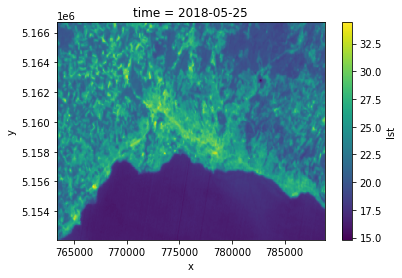

In [142]:
var_da = xr.open_dataarray(dst_filepath)
var_da.isel(time=0).plot()

In [97]:
lst_da.to_netcdf('bar.nc')

In [98]:
bar_da = xr.open_dataarray('bar.nc')

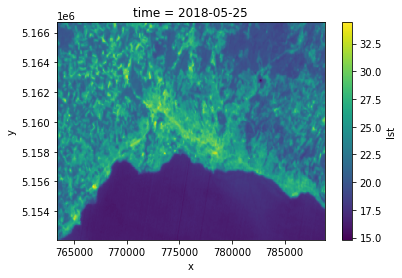

In [100]:
bar_da.isel(time=0).plot()

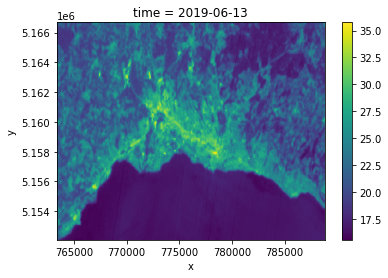

In [83]:
lst_da.isel(time=3).plot()

In [56]:
dst_filepath = '../data/interim/lst.nc'

In [57]:
lst_da.to_netcdf(dst_filepath)

In [9]:
import logging
import tempfile
from os import path

import click
import geopandas as gpd
import numpy as np
import pandas as pd
import pylandsat
import salem
import xarray as xr
from rio_toa import brightness_temp

from lausanne_greening_scenarios import settings, utils

DATETIME_FMT = '%Y-%m-%d'

LANDSAT_FILES = ['B3.TIF', 'B4.TIF', 'B5.TIF', 'B10.TIF', 'MTL.txt']
LANDSAT_META_KEYS = ['RADIOMETRIC_RESCALING', 'TIRS_THERMAL_CONSTANTS']
LANDSAT_NODATA = 0

# TODO: the "parameters" should be customizable by means of arguments or a
# settings module
C = 0.005
ndvi_soil = 0.2
ndvi_veg = 0.5
eps_water = 0.991
eps_soil = 0.996
eps_veg = 0.973

lambd = 10.895e-9
rho = 1.439e-2  # 6.626e-34 * 2.998e8 / 1.38e-23

def get_lst_da(landsat_tile,
               ref_geom=None,
               lake_geom=None,
               crs=None,
               roi=False,
               subset_kws=None,
               roi_kws=None):
    product = pylandsat.Product(landsat_tile)

    with tempfile.TemporaryDirectory() as tmp_dir:
        product.download(tmp_dir, files=LANDSAT_FILES)

        landsat_tile_dir = path.join(tmp_dir, landsat_tile)

        scene = pylandsat.Scene(landsat_tile_dir)
        bands = scene.available_bands()
        band_filepaths = [getattr(scene, band).fpath for band in bands]

        # create xarray dataset
        landsat_ds = xr.Dataset({
            band: salem.open_xr_dataset(band_filepath)['data']
            for band, band_filepath in zip(bands, band_filepaths)
        })
    # projection attributes need to be set before any geo-transformation
    proj_attrs = landsat_ds[bands[0]].attrs.copy()
    landsat_ds.attrs = proj_attrs

    # landsat metadata that will be used below
    mtl_dict = scene.mtl

    # crop to the reference extent
    landsat_ds = utils.clip_ds_to_extent(landsat_ds,
                                         geometry=ref_geom,
                                         crs=crs,
                                         roi=roi,
                                         subset_kws=subset_kws,
                                         roi_kws=roi_kws)

    # the lake mask needs to be boolean for NumPy slicing to work properly
    lake_mask = landsat_ds.salem.grid.region_of_interest(geometry=lake_geom,
                                                         crs=crs).astype(bool)

    # LST
    lst_arr = compute_lst(landsat_ds, mtl_dict, lake_mask)

    # assemble the final dataset
    dims = ('y', 'x')
    coords = {
        'x': landsat_ds.salem.grid.x_coord,
        'y': landsat_ds.salem.grid.y_coord
    }
    landsat_features_da = xr.DataArray(lst_arr,
                                       dims=dims,
                                       coords=coords,
                                       attrs=proj_attrs)
    # add the date
    landsat_features_da = landsat_features_da.assign_coords({
        'time':
        pd.to_datetime(mtl_dict['PRODUCT_METADATA']['DATE_ACQUIRED'])
    })

    return landsat_features_da


In [20]:
landsat_tiles_filepath = '../data/raw/landsat-tiles.csv'
agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
buffer_dist = 2000

In [15]:
# get the agglomeration and lake extents
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
crs = agglom_extent_gdf.crs
ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
lake_geom = agglom_extent_gdf.loc[1]['geometry']

In [21]:
# read list of landsat tiles (product ids) to process
landsat_tiles = pd.read_csv(landsat_tiles_filepath, header=None)[0]

In [23]:
# process the list of tiles
dataarrays = []
for landsat_tile in landsat_tiles:
    da = get_lst_da(landsat_tile,
                    ref_geom=ref_geom,
                    lake_geom=lake_geom,
                    crs=crs)
    dataarrays.append(da)

  0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   1%|▏         | 1.05M/83.0M [00:00<00:10, 8.05MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   4%|▍         | 3.15M/83.0M [00:00<00:08, 8.97MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   6%|▋         | 5.24M/83.0M [00:00<00:07, 9.87MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:   9%|▉         | 7.34M/83.0M [00:00<00:07, 10.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  11%|█▏        | 9.44M/83.0M [00:00<00:06, 10.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  14%|█▍        | 11.5M/83.0M [00:00<00:06, 11.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  16%|█▋        | 13.6M/83.0M [00:01<00:05, 11.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  19%|█▉        | 15.7M/83.0M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  21%|██▏       | 17.8M/83.0M [00:01<00:06, 9.76MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  24%|██▍       | 19.9M/83.0M [00:01<00:06, 10.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  27%|██▋       | 22.0M/83.0M [00:01<00:05, 11.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  29%|██▉       | 24.1M/83.0M [00:02<00:05, 11.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  32%|███▏      | 26.2M/83.0M [00:02<00:05, 11.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  34%|███▍      | 28.3M/83.0M [00:02<00:04, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  37%|███▋      | 30.4M/83.0M [00:02<00:04, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  39%|███▉      | 32.5M/83.0M [00:02<00:04, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  42%|████▏     | 34.6M/83.0M [00:03<00:05, 8.30MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  44%|████▍     | 36.7M/83.0M [00:03<00:04, 9.27MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  47%|████▋     | 38.8M/83.0M [00:03<00:04, 10.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  49%|████▉     | 40.9M/83.0M [00:03<00:03, 10.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  52%|█████▏    | 43.0M/83.0M [00:04<00:04, 9.04MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  54%|█████▍    | 45.1M/83.0M [00:04<00:03, 9.85MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  57%|█████▋    | 47.2M/83.0M [00:04<00:03, 10.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  59%|█████▉    | 49.3M/83.0M [00:04<00:03, 11.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  62%|██████▏   | 51.4M/83.0M [00:04<00:02, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  64%|██████▍   | 53.5M/83.0M [00:04<00:02, 11.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  67%|██████▋   | 55.6M/83.0M [00:05<00:02, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  69%|██████▉   | 57.7M/83.0M [00:05<00:02, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  72%|███████▏  | 59.8M/83.0M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  75%|███████▍  | 61.9M/83.0M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  77%|███████▋  | 64.0M/83.0M [00:05<00:01, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  80%|███████▉  | 66.1M/83.0M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  82%|████████▏ | 68.2M/83.0M [00:06<00:01, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  85%|████████▍ | 70.3M/83.0M [00:06<00:01, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  87%|████████▋ | 72.4M/83.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  90%|████████▉ | 74.4M/83.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  92%|█████████▏| 76.5M/83.0M [00:06<00:00, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  95%|█████████▍| 78.6M/83.0M [00:06<00:00, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF:  97%|█████████▋| 80.7M/83.0M [00:07<00:00, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF: 100%|█████████▉| 82.8M/83.0M [00:07<00:00, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B3.TIF: : 83.9MB [00:07, 11.5MB/s]                          

  0%|          | 0.00/85.3M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   0%|          | 0.00/85.3M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   1%|          | 1.05M/85.3M [00:00<00:11, 7.42MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   4%|▎         | 3.15M/85.3M [00:00<00:09, 8.52MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   6%|▌         | 5.24M/85.3M [00:00<00:08, 9.42MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:   9%|▊         | 7.34M/85.3M [00:00<00:07, 10.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  11%|█         | 9.44M/85.3M [00:00<00:07, 10.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  14%|█▎        | 11.5M/85.3M [00:00<00:06, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  16%|█▌        | 13.6M/85.3M [00:01<00:06, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  18%|█▊        | 15.7M/85.3M [00:01<00:05, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  21%|██        | 17.8M/85.3M [00:01<00:05, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  23%|██▎       | 19.9M/85.3M [00:01<00:05, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  26%|██▌       | 22.0M/85.3M [00:01<00:05, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  28%|██▊       | 24.1M/85.3M [00:01<00:05, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  31%|███       | 26.2M/85.3M [00:02<00:04, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  33%|███▎      | 28.3M/85.3M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  36%|███▌      | 30.4M/85.3M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  38%|███▊      | 32.5M/85.3M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  41%|████      | 34.6M/85.3M [00:02<00:04, 12.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  43%|████▎     | 36.7M/85.3M [00:02<00:03, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  45%|████▌     | 38.8M/85.3M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  48%|████▊     | 40.9M/85.3M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  50%|█████     | 43.0M/85.3M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  53%|█████▎    | 45.1M/85.3M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  55%|█████▌    | 47.2M/85.3M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  58%|█████▊    | 49.3M/85.3M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  60%|██████    | 51.4M/85.3M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  63%|██████▎   | 53.5M/85.3M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  65%|██████▌   | 55.6M/85.3M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  68%|██████▊   | 57.7M/85.3M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  70%|███████   | 59.8M/85.3M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  73%|███████▎  | 61.9M/85.3M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  75%|███████▍  | 64.0M/85.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  77%|███████▋  | 66.1M/85.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  80%|███████▉  | 68.2M/85.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  82%|████████▏ | 70.3M/85.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  85%|████████▍ | 72.4M/85.3M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  87%|████████▋ | 74.4M/85.3M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  90%|████████▉ | 76.5M/85.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  92%|█████████▏| 78.6M/85.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  95%|█████████▍| 80.7M/85.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF:  97%|█████████▋| 82.8M/85.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF: 100%|█████████▉| 84.9M/85.3M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B4.TIF: : 86.0MB [00:06, 12.5MB/s]                          

  0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   1%|          | 1.05M/100M [00:00<00:26, 3.79MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   2%|▏         | 2.10M/100M [00:00<00:22, 4.46MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   5%|▌         | 5.24M/100M [00:00<00:16, 5.65MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   7%|▋         | 7.34M/100M [00:00<00:13, 7.07MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:   9%|▉         | 9.44M/100M [00:00<00:11, 8.13MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  12%|█▏        | 11.5M/100M [00:01<00:09, 9.10MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  14%|█▎        | 13.6M/100M [00:01<00:08, 9.91MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  16%|█▌        | 15.7M/100M [00:01<00:07, 10.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  18%|█▊        | 17.8M/100M [00:01<00:07, 11.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  20%|█▉        | 19.9M/100M [00:01<00:06, 11.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  22%|██▏       | 22.0M/100M [00:01<00:06, 11.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  24%|██▍       | 24.1M/100M [00:02<00:06, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  26%|██▌       | 26.2M/100M [00:02<00:06, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  28%|██▊       | 28.3M/100M [00:02<00:05, 12.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  30%|███       | 30.4M/100M [00:02<00:05, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  32%|███▏      | 32.5M/100M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  35%|███▍      | 34.6M/100M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  37%|███▋      | 36.7M/100M [00:03<00:05, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  39%|███▊      | 38.8M/100M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  41%|████      | 40.9M/100M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  43%|████▎     | 43.0M/100M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  45%|████▍     | 45.1M/100M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  47%|████▋     | 47.2M/100M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  49%|████▉     | 49.3M/100M [00:04<00:04, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  51%|█████     | 51.4M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  53%|█████▎    | 53.5M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  55%|█████▌    | 55.6M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  58%|█████▊    | 57.7M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  60%|█████▉    | 59.8M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  62%|██████▏   | 61.9M/100M [00:05<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  64%|██████▍   | 64.0M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  66%|██████▌   | 66.1M/100M [00:05<00:02, 12.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  68%|██████▊   | 68.2M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  70%|███████   | 70.3M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  72%|███████▏  | 72.4M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  74%|███████▍  | 74.4M/100M [00:06<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  76%|███████▋  | 76.5M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  78%|███████▊  | 78.6M/100M [00:06<00:01, 11.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  81%|████████  | 80.7M/100M [00:06<00:01, 13.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  83%|████████▎ | 82.8M/100M [00:06<00:01, 12.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  85%|████████▍ | 84.9M/100M [00:06<00:01, 12.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  87%|████████▋ | 87.0M/100M [00:07<00:01, 12.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  89%|████████▉ | 89.1M/100M [00:07<00:00, 12.7MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  91%|█████████ | 91.2M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  93%|█████████▎| 93.3M/100M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  95%|█████████▌| 95.4M/100M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  97%|█████████▋| 97.5M/100M [00:07<00:00, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF:  99%|█████████▉| 99.6M/100M [00:08<00:00, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B5.TIF: : 101MB [00:08, 12.4MB/s]                          

  0%|          | 0.00/66.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   2%|▏         | 1.05M/66.0M [00:00<00:07, 8.73MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   5%|▍         | 3.15M/66.0M [00:00<00:06, 9.61MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:   8%|▊         | 5.24M/66.0M [00:00<00:05, 10.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  11%|█         | 7.34M/66.0M [00:00<00:05, 10.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  14%|█▍        | 9.44M/66.0M [00:00<00:05, 11.3MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  17%|█▋        | 11.5M/66.0M [00:00<00:04, 11.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  21%|██        | 13.6M/66.0M [00:01<00:04, 11.9MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  24%|██▍       | 15.7M/66.0M [00:01<00:04, 11.8MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  27%|██▋       | 17.8M/66.0M [00:01<00:04, 12.0MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  30%|███       | 19.9M/66.0M [00:01<00:03, 12.1MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  33%|███▎      | 22.0M/66.0M [00:01<00:03, 12.2MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  37%|███▋      | 24.1M/66.0M [00:01<00:03, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  40%|███▉      | 26.2M/66.0M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  43%|████▎     | 28.3M/66.0M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  46%|████▌     | 30.4M/66.0M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  49%|████▉     | 32.5M/66.0M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  52%|█████▏    | 34.6M/66.0M [00:02<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  56%|█████▌    | 36.7M/66.0M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  59%|█████▉    | 38.8M/66.0M [00:03<00:02, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  62%|██████▏   | 40.9M/66.0M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  65%|██████▌   | 43.0M/66.0M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  68%|██████▊   | 45.1M/66.0M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  72%|███████▏  | 47.2M/66.0M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  75%|███████▍  | 49.3M/66.0M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  78%|███████▊  | 51.4M/66.0M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  81%|████████  | 53.5M/66.0M [00:04<00:01, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  84%|████████▍ | 55.6M/66.0M [00:04<00:00, 12.4MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  87%|████████▋ | 57.7M/66.0M [00:04<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  91%|█████████ | 59.8M/66.0M [00:04<00:00, 12.5MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  94%|█████████▍| 61.9M/66.0M [00:04<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF:  97%|█████████▋| 64.0M/66.0M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF: : 66.1MB [00:05, 12.7MB/s]                          

LC08_L1TP_196028_20180525_20180605_01_T1_B10.TIF: : 66.1MB [00:05, 12.4MB/s]

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180525_20180605_01_T1_MTL.txt: : 1.05MB [00:00, 133MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/86.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   0%|          | 0.00/86.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   1%|          | 1.05M/86.3M [00:00<00:10, 8.51MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   4%|▎         | 3.15M/86.3M [00:00<00:08, 9.40MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   5%|▍         | 4.19M/86.3M [00:00<00:08, 9.70MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:   7%|▋         | 6.29M/86.3M [00:00<00:07, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  10%|▉         | 8.39M/86.3M [00:00<00:07, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  12%|█▏        | 10.5M/86.3M [00:00<00:06, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  15%|█▍        | 12.6M/86.3M [00:01<00:06, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  17%|█▋        | 14.7M/86.3M [00:01<00:06, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  19%|█▉        | 16.8M/86.3M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  22%|██▏       | 18.9M/86.3M [00:01<00:06, 10.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  24%|██▍       | 21.0M/86.3M [00:01<00:06, 10.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  27%|██▋       | 23.1M/86.3M [00:02<00:05, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  29%|██▉       | 25.2M/86.3M [00:02<00:05, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  32%|███▏      | 27.3M/86.3M [00:02<00:05, 11.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  34%|███▍      | 29.4M/86.3M [00:02<00:04, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  36%|███▋      | 31.5M/86.3M [00:02<00:04, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  39%|███▉      | 33.6M/86.3M [00:02<00:04, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  41%|████▏     | 35.7M/86.3M [00:03<00:05, 10.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  44%|████▎     | 37.7M/86.3M [00:03<00:04, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  46%|████▌     | 39.8M/86.3M [00:03<00:04, 11.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  49%|████▊     | 41.9M/86.3M [00:03<00:03, 11.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  51%|█████     | 44.0M/86.3M [00:04<00:04, 8.69MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  53%|█████▎    | 46.1M/86.3M [00:04<00:04, 9.60MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  56%|█████▌    | 48.2M/86.3M [00:04<00:03, 10.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  58%|█████▊    | 50.3M/86.3M [00:04<00:03, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  61%|██████    | 52.4M/86.3M [00:04<00:02, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  63%|██████▎   | 54.5M/86.3M [00:04<00:02, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  66%|██████▌   | 56.6M/86.3M [00:05<00:02, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  68%|██████▊   | 58.7M/86.3M [00:05<00:02, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  70%|███████   | 60.8M/86.3M [00:05<00:02, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  73%|███████▎  | 62.9M/86.3M [00:05<00:02, 10.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  75%|███████▌  | 65.0M/86.3M [00:05<00:01, 11.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  78%|███████▊  | 67.1M/86.3M [00:06<00:01, 11.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  80%|████████  | 69.2M/86.3M [00:06<00:01, 11.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  83%|████████▎ | 71.3M/86.3M [00:06<00:01, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  85%|████████▌ | 73.4M/86.3M [00:06<00:01, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  87%|████████▋ | 75.5M/86.3M [00:06<00:00, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  90%|████████▉ | 77.6M/86.3M [00:06<00:00, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  92%|█████████▏| 79.7M/86.3M [00:07<00:00, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  95%|█████████▍| 81.8M/86.3M [00:07<00:00, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF:  97%|█████████▋| 83.9M/86.3M [00:07<00:00, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF: 100%|█████████▉| 86.0M/86.3M [00:07<00:00, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B3.TIF: : 87.0MB [00:07, 11.5MB/s]                          

  0%|          | 0.00/88.4M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   0%|          | 0.00/88.4M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   1%|          | 1.05M/88.4M [00:00<00:11, 7.85MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   4%|▎         | 3.15M/88.4M [00:00<00:09, 8.81MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   6%|▌         | 5.24M/88.4M [00:00<00:08, 9.68MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:   8%|▊         | 7.34M/88.4M [00:00<00:07, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  11%|█         | 9.44M/88.4M [00:00<00:08, 9.38MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  13%|█▎        | 11.5M/88.4M [00:01<00:07, 10.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  15%|█▌        | 13.6M/88.4M [00:01<00:06, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  18%|█▊        | 15.7M/88.4M [00:01<00:06, 11.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  20%|██        | 17.8M/88.4M [00:01<00:06, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  23%|██▎       | 19.9M/88.4M [00:01<00:05, 11.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  25%|██▍       | 22.0M/88.4M [00:01<00:05, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  27%|██▋       | 24.1M/88.4M [00:02<00:05, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  30%|██▉       | 26.2M/88.4M [00:02<00:06, 9.24MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  31%|███       | 27.3M/88.4M [00:02<00:06, 9.49MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  33%|███▎      | 29.4M/88.4M [00:02<00:05, 10.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  36%|███▌      | 31.5M/88.4M [00:02<00:05, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  38%|███▊      | 33.6M/88.4M [00:03<00:04, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  40%|████      | 35.7M/88.4M [00:03<00:05, 9.29MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  43%|████▎     | 37.7M/88.4M [00:03<00:05, 9.88MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  45%|████▌     | 39.8M/88.4M [00:03<00:04, 10.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  47%|████▋     | 41.9M/88.4M [00:03<00:04, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  50%|████▉     | 44.0M/88.4M [00:04<00:04, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  52%|█████▏    | 46.1M/88.4M [00:04<00:03, 10.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  55%|█████▍    | 48.2M/88.4M [00:04<00:03, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  57%|█████▋    | 50.3M/88.4M [00:04<00:03, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  59%|█████▉    | 52.4M/88.4M [00:04<00:03, 11.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  62%|██████▏   | 54.5M/88.4M [00:04<00:02, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  64%|██████▍   | 56.6M/88.4M [00:05<00:02, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  66%|██████▋   | 58.7M/88.4M [00:05<00:02, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  69%|██████▉   | 60.8M/88.4M [00:05<00:02, 11.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  71%|███████   | 62.9M/88.4M [00:05<00:02, 11.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  74%|███████▎  | 65.0M/88.4M [00:05<00:01, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  76%|███████▌  | 67.1M/88.4M [00:06<00:02, 8.65MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  78%|███████▊  | 69.2M/88.4M [00:06<00:02, 9.55MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  81%|████████  | 71.3M/88.4M [00:06<00:01, 10.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  83%|████████▎ | 73.4M/88.4M [00:06<00:01, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  85%|████████▌ | 75.5M/88.4M [00:06<00:01, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  88%|████████▊ | 77.6M/88.4M [00:07<00:00, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  90%|█████████ | 79.7M/88.4M [00:07<00:00, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  92%|█████████▏| 81.8M/88.4M [00:07<00:00, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  95%|█████████▍| 83.9M/88.4M [00:07<00:00, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF:  97%|█████████▋| 86.0M/88.4M [00:07<00:00, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF: 100%|█████████▉| 88.1M/88.4M [00:07<00:00, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B4.TIF: : 89.1MB [00:07, 11.1MB/s]                          

  0%|          | 0.00/102M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   0%|          | 0.00/102M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   1%|          | 1.05M/102M [00:00<00:18, 5.52MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   3%|▎         | 3.15M/102M [00:00<00:14, 6.62MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   4%|▍         | 4.19M/102M [00:00<00:14, 6.64MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   7%|▋         | 7.34M/102M [00:00<00:11, 8.18MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:   9%|▉         | 9.44M/102M [00:00<00:11, 8.19MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  11%|█▏        | 11.5M/102M [00:01<00:09, 9.13MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  13%|█▎        | 13.6M/102M [00:01<00:08, 9.94MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  15%|█▌        | 15.7M/102M [00:01<00:08, 10.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  18%|█▊        | 17.8M/102M [00:01<00:08, 9.66MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  20%|█▉        | 19.9M/102M [00:01<00:07, 10.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  22%|██▏       | 22.0M/102M [00:02<00:07, 10.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  24%|██▎       | 24.1M/102M [00:02<00:06, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  26%|██▌       | 26.2M/102M [00:02<00:07, 10.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  28%|██▊       | 28.3M/102M [00:02<00:06, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  30%|██▉       | 30.4M/102M [00:02<00:06, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  32%|███▏      | 32.5M/102M [00:02<00:05, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  34%|███▍      | 34.6M/102M [00:03<00:07, 8.85MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  36%|███▌      | 36.7M/102M [00:03<00:06, 9.61MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  38%|███▊      | 38.8M/102M [00:03<00:06, 10.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  40%|████      | 40.9M/102M [00:03<00:05, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  42%|████▏     | 43.0M/102M [00:04<00:05, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  44%|████▍     | 45.1M/102M [00:04<00:04, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  46%|████▋     | 47.2M/102M [00:04<00:04, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  48%|████▊     | 49.3M/102M [00:04<00:04, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  50%|█████     | 51.4M/102M [00:04<00:04, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  53%|█████▎    | 53.5M/102M [00:04<00:04, 11.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  55%|█████▍    | 55.6M/102M [00:05<00:04, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  57%|█████▋    | 57.7M/102M [00:05<00:03, 11.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  59%|█████▊    | 59.8M/102M [00:05<00:03, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  61%|██████    | 61.9M/102M [00:05<00:03, 12.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  63%|██████▎   | 64.0M/102M [00:05<00:03, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  65%|██████▍   | 66.1M/102M [00:05<00:02, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  67%|██████▋   | 68.2M/102M [00:06<00:02, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  69%|██████▉   | 70.3M/102M [00:06<00:02, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  71%|███████   | 72.4M/102M [00:06<00:02, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  73%|███████▎  | 74.4M/102M [00:06<00:02, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  75%|███████▌  | 76.5M/102M [00:06<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  77%|███████▋  | 78.6M/102M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  79%|███████▉  | 80.7M/102M [00:07<00:01, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  81%|████████▏ | 82.8M/102M [00:07<00:01, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  83%|████████▎ | 84.9M/102M [00:07<00:01, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  85%|████████▌ | 87.0M/102M [00:07<00:01, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  88%|████████▊ | 89.1M/102M [00:07<00:01, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  90%|████████▉ | 91.2M/102M [00:07<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  92%|█████████▏| 93.3M/102M [00:08<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  94%|█████████▎| 95.4M/102M [00:08<00:00, 11.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  96%|█████████▌| 97.5M/102M [00:08<00:00, 12.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF:  98%|█████████▊| 99.6M/102M [00:08<00:00, 12.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF: 100%|█████████▉| 102M/102M [00:08<00:00, 12.5MB/s] 

LC08_L1TP_195028_20180619_20180703_01_T1_B5.TIF: : 103MB [00:08, 11.7MB/s]                         

  0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   2%|▏         | 1.05M/67.7M [00:00<00:08, 7.51MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   5%|▍         | 3.15M/67.7M [00:00<00:07, 8.55MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   8%|▊         | 5.24M/67.7M [00:00<00:06, 9.37MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:   9%|▉         | 6.29M/67.7M [00:00<00:06, 9.44MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  12%|█▏        | 8.39M/67.7M [00:00<00:05, 10.2MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  15%|█▌        | 10.5M/67.7M [00:00<00:05, 10.8MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  19%|█▊        | 12.6M/67.7M [00:01<00:04, 11.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  22%|██▏       | 14.7M/67.7M [00:01<00:05, 10.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  25%|██▍       | 16.8M/67.7M [00:01<00:04, 10.9MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  28%|██▊       | 18.9M/67.7M [00:01<00:04, 11.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  31%|███       | 21.0M/67.7M [00:01<00:03, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  34%|███▍      | 23.1M/67.7M [00:01<00:03, 12.0MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  37%|███▋      | 25.2M/67.7M [00:02<00:03, 12.1MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  40%|████      | 27.3M/67.7M [00:02<00:03, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  43%|████▎     | 29.4M/67.7M [00:02<00:03, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  46%|████▋     | 31.5M/67.7M [00:02<00:02, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  50%|████▉     | 33.6M/67.7M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  53%|█████▎    | 35.7M/67.7M [00:02<00:02, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  56%|█████▌    | 37.7M/67.7M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  59%|█████▉    | 39.8M/67.7M [00:03<00:02, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  62%|██████▏   | 41.9M/67.7M [00:03<00:02, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  65%|██████▌   | 44.0M/67.7M [00:03<00:01, 12.4MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  68%|██████▊   | 46.1M/67.7M [00:03<00:01, 11.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  71%|███████   | 48.2M/67.7M [00:04<00:01, 12.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  74%|███████▍  | 50.3M/67.7M [00:04<00:01, 12.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  77%|███████▋  | 52.4M/67.7M [00:04<00:01, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  81%|████████  | 54.5M/67.7M [00:04<00:01, 12.3MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  84%|████████▎ | 56.6M/67.7M [00:04<00:00, 12.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  87%|████████▋ | 58.7M/67.7M [00:04<00:00, 12.7MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  90%|████████▉ | 60.8M/67.7M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  93%|█████████▎| 62.9M/67.7M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  96%|█████████▌| 65.0M/67.7M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF:  99%|█████████▉| 67.1M/67.7M [00:05<00:00, 12.5MB/s]

LC08_L1TP_195028_20180619_20180703_01_T1_B10.TIF: : 68.2MB [00:05, 12.3MB/s]                          

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20180619_20180703_01_T1_MTL.txt: : 1.05MB [00:00, 164MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/83.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   0%|          | 0.00/83.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   1%|▏         | 1.05M/83.4M [00:00<00:09, 8.78MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   4%|▍         | 3.15M/83.4M [00:00<00:08, 9.64MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   6%|▋         | 5.24M/83.4M [00:00<00:07, 10.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:   9%|▉         | 7.34M/83.4M [00:00<00:06, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  11%|█▏        | 9.44M/83.4M [00:00<00:06, 10.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  14%|█▍        | 11.5M/83.4M [00:00<00:06, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  16%|█▋        | 13.6M/83.4M [00:01<00:05, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  19%|█▉        | 15.7M/83.4M [00:01<00:05, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  21%|██▏       | 17.8M/83.4M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  24%|██▍       | 19.9M/83.4M [00:01<00:05, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  26%|██▋       | 22.0M/83.4M [00:01<00:05, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  29%|██▉       | 24.1M/83.4M [00:02<00:04, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  31%|███▏      | 26.2M/83.4M [00:02<00:04, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  34%|███▍      | 28.3M/83.4M [00:02<00:04, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  36%|███▋      | 30.4M/83.4M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  39%|███▉      | 32.5M/83.4M [00:02<00:04, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  41%|████▏     | 34.6M/83.4M [00:02<00:04, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  44%|████▍     | 36.7M/83.4M [00:03<00:03, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  47%|████▋     | 38.8M/83.4M [00:03<00:03, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  49%|████▉     | 40.9M/83.4M [00:03<00:03, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  52%|█████▏    | 43.0M/83.4M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  54%|█████▍    | 45.1M/83.4M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  57%|█████▋    | 47.2M/83.4M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  59%|█████▉    | 49.3M/83.4M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  62%|██████▏   | 51.4M/83.4M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  64%|██████▍   | 53.5M/83.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  67%|██████▋   | 55.6M/83.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  69%|██████▉   | 57.7M/83.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  72%|███████▏  | 59.8M/83.4M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  74%|███████▍  | 61.9M/83.4M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  77%|███████▋  | 64.0M/83.4M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  79%|███████▉  | 66.1M/83.4M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  82%|████████▏ | 68.2M/83.4M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  84%|████████▍ | 70.3M/83.4M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  87%|████████▋ | 72.4M/83.4M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  89%|████████▉ | 74.4M/83.4M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  92%|█████████▏| 76.5M/83.4M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  94%|█████████▍| 78.6M/83.4M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  97%|█████████▋| 80.7M/83.4M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF:  99%|█████████▉| 82.8M/83.4M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B3.TIF: : 83.9MB [00:06, 12.4MB/s]                          

  0%|          | 0.00/86.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   1%|          | 1.05M/86.7M [00:00<00:17, 4.91MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   4%|▎         | 3.15M/86.7M [00:00<00:13, 6.09MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   5%|▍         | 4.19M/86.7M [00:00<00:12, 6.60MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:   7%|▋         | 6.29M/86.7M [00:00<00:10, 8.02MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  10%|▉         | 8.39M/86.7M [00:00<00:08, 9.10MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  11%|█         | 9.44M/86.7M [00:01<00:12, 6.08MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  13%|█▎        | 11.5M/86.7M [00:01<00:10, 7.21MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  16%|█▌        | 13.6M/86.7M [00:01<00:08, 8.27MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  18%|█▊        | 15.7M/86.7M [00:01<00:07, 9.25MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  21%|██        | 17.8M/86.7M [00:01<00:06, 10.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  23%|██▎       | 19.9M/86.7M [00:01<00:06, 10.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  25%|██▌       | 22.0M/86.7M [00:02<00:05, 11.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  28%|██▊       | 24.1M/86.7M [00:02<00:05, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  30%|███       | 26.2M/86.7M [00:02<00:05, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  33%|███▎      | 28.3M/86.7M [00:02<00:04, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  35%|███▌      | 30.4M/86.7M [00:02<00:04, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  37%|███▋      | 32.5M/86.7M [00:02<00:04, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  40%|███▉      | 34.6M/86.7M [00:03<00:04, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  42%|████▏     | 36.7M/86.7M [00:03<00:04, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  45%|████▍     | 38.8M/86.7M [00:03<00:04, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  47%|████▋     | 40.9M/86.7M [00:03<00:03, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  50%|████▉     | 43.0M/86.7M [00:03<00:04, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  52%|█████▏    | 45.1M/86.7M [00:04<00:03, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  54%|█████▍    | 47.2M/86.7M [00:04<00:03, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  57%|█████▋    | 49.3M/86.7M [00:04<00:03, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  59%|█████▉    | 51.4M/86.7M [00:04<00:03, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  62%|██████▏   | 53.5M/86.7M [00:04<00:02, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  64%|██████▍   | 55.6M/86.7M [00:04<00:02, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  66%|██████▋   | 57.7M/86.7M [00:05<00:02, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  69%|██████▉   | 59.8M/86.7M [00:05<00:02, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  71%|███████▏  | 61.9M/86.7M [00:05<00:02, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  74%|███████▎  | 64.0M/86.7M [00:05<00:01, 12.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  76%|███████▌  | 66.1M/86.7M [00:05<00:01, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  79%|███████▊  | 68.2M/86.7M [00:05<00:01, 12.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  81%|████████  | 70.3M/86.7M [00:06<00:01, 12.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  83%|████████▎ | 72.4M/86.7M [00:06<00:01, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  86%|████████▌ | 74.4M/86.7M [00:06<00:00, 12.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  88%|████████▊ | 76.5M/86.7M [00:06<00:00, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  91%|█████████ | 78.6M/86.7M [00:06<00:00, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  93%|█████████▎| 80.7M/86.7M [00:06<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  96%|█████████▌| 82.8M/86.7M [00:07<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF:  98%|█████████▊| 84.9M/86.7M [00:07<00:00, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF: : 87.0MB [00:07, 13.0MB/s]                          

LC08_L1TP_196028_20180626_20180704_01_T1_B4.TIF: : 87.0MB [00:07, 11.7MB/s]

  0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   1%|          | 1.05M/101M [00:00<00:11, 8.40MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   3%|▎         | 3.15M/101M [00:00<00:10, 9.33MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   5%|▌         | 5.24M/101M [00:00<00:09, 10.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   7%|▋         | 7.34M/101M [00:00<00:08, 10.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:   9%|▉         | 9.44M/101M [00:00<00:08, 11.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  11%|█▏        | 11.5M/101M [00:00<00:07, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  13%|█▎        | 13.6M/101M [00:01<00:07, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  16%|█▌        | 15.7M/101M [00:01<00:07, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  18%|█▊        | 17.8M/101M [00:01<00:06, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  20%|█▉        | 19.9M/101M [00:01<00:06, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  22%|██▏       | 22.0M/101M [00:01<00:06, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  24%|██▍       | 24.1M/101M [00:01<00:06, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  26%|██▌       | 26.2M/101M [00:02<00:06, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  28%|██▊       | 28.3M/101M [00:02<00:05, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  30%|███       | 30.4M/101M [00:02<00:05, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  32%|███▏      | 32.5M/101M [00:02<00:05, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  34%|███▍      | 34.6M/101M [00:02<00:05, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  36%|███▋      | 36.7M/101M [00:03<00:05, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  38%|███▊      | 38.8M/101M [00:03<00:05, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  40%|████      | 40.9M/101M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  43%|████▎     | 43.0M/101M [00:03<00:04, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  45%|████▍     | 45.1M/101M [00:03<00:04, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  47%|████▋     | 47.2M/101M [00:03<00:04, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  49%|████▊     | 49.3M/101M [00:04<00:04, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  51%|█████     | 51.4M/101M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  53%|█████▎    | 53.5M/101M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  55%|█████▍    | 55.6M/101M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  57%|█████▋    | 57.7M/101M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  59%|█████▉    | 59.8M/101M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  61%|██████    | 61.9M/101M [00:05<00:03, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  63%|██████▎   | 64.0M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  65%|██████▌   | 66.1M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  67%|██████▋   | 68.2M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  69%|██████▉   | 70.3M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  72%|███████▏  | 72.4M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  74%|███████▎  | 74.4M/101M [00:06<00:02, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  76%|███████▌  | 76.5M/101M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  78%|███████▊  | 78.6M/101M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  80%|███████▉  | 80.7M/101M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  82%|████████▏ | 82.8M/101M [00:06<00:01, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  84%|████████▍ | 84.9M/101M [00:06<00:01, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  86%|████████▌ | 87.0M/101M [00:07<00:01, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  88%|████████▊ | 89.1M/101M [00:07<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  90%|█████████ | 91.2M/101M [00:07<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  92%|█████████▏| 93.3M/101M [00:07<00:00, 12.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  94%|█████████▍| 95.4M/101M [00:07<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  96%|█████████▋| 97.5M/101M [00:07<00:00, 12.1MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF:  99%|█████████▊| 99.6M/101M [00:08<00:00, 12.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF: : 102MB [00:08, 13.8MB/s]                          

LC08_L1TP_196028_20180626_20180704_01_T1_B5.TIF: : 102MB [00:08, 12.4MB/s]

  0%|          | 0.00/67.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   2%|▏         | 1.05M/67.2M [00:00<00:11, 5.85MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   3%|▎         | 2.10M/67.2M [00:00<00:10, 6.22MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   6%|▌         | 4.19M/67.2M [00:00<00:08, 7.84MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:   9%|▉         | 6.29M/67.2M [00:00<00:06, 8.85MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  12%|█▏        | 8.39M/67.2M [00:00<00:06, 9.70MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  16%|█▌        | 10.5M/67.2M [00:01<00:06, 8.60MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  19%|█▊        | 12.6M/67.2M [00:01<00:05, 9.51MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  22%|██▏       | 14.7M/67.2M [00:01<00:05, 10.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  25%|██▍       | 16.8M/67.2M [00:01<00:04, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  28%|██▊       | 18.9M/67.2M [00:01<00:05, 9.15MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  31%|███       | 21.0M/67.2M [00:02<00:04, 9.95MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  34%|███▍      | 23.1M/67.2M [00:02<00:04, 10.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  37%|███▋      | 25.2M/67.2M [00:02<00:03, 11.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  41%|████      | 27.3M/67.2M [00:02<00:03, 11.6MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  44%|████▎     | 29.4M/67.2M [00:02<00:03, 11.8MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  47%|████▋     | 31.5M/67.2M [00:02<00:03, 11.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  50%|████▉     | 33.6M/67.2M [00:03<00:02, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  53%|█████▎    | 35.7M/67.2M [00:03<00:04, 7.53MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  56%|█████▌    | 37.7M/67.2M [00:03<00:03, 8.56MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  59%|█████▉    | 39.8M/67.2M [00:03<00:02, 9.48MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  62%|██████▏   | 41.9M/67.2M [00:04<00:02, 10.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  66%|██████▌   | 44.0M/67.2M [00:04<00:02, 10.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  69%|██████▊   | 46.1M/67.2M [00:04<00:01, 10.9MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  72%|███████▏  | 48.2M/67.2M [00:04<00:01, 11.4MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  75%|███████▍  | 50.3M/67.2M [00:04<00:01, 11.7MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  78%|███████▊  | 52.4M/67.2M [00:04<00:01, 12.0MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  81%|████████  | 54.5M/67.2M [00:05<00:01, 12.2MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  84%|████████▍ | 56.6M/67.2M [00:05<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  87%|████████▋ | 58.7M/67.2M [00:05<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  90%|█████████ | 60.8M/67.2M [00:05<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  94%|█████████▎| 62.9M/67.2M [00:05<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF:  97%|█████████▋| 65.0M/67.2M [00:05<00:00, 12.5MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF: 100%|█████████▉| 67.1M/67.2M [00:06<00:00, 12.3MB/s]

LC08_L1TP_196028_20180626_20180704_01_T1_B10.TIF: : 68.2MB [00:06, 11.1MB/s]                          

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20180626_20180704_01_T1_MTL.txt: : 1.05MB [00:00, 178MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/82.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   0%|          | 0.00/82.2M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   1%|▏         | 1.05M/82.2M [00:00<00:10, 7.98MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   4%|▍         | 3.15M/82.2M [00:00<00:08, 8.96MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   6%|▋         | 5.24M/82.2M [00:00<00:07, 9.80MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:   9%|▉         | 7.34M/82.2M [00:00<00:07, 10.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  11%|█▏        | 9.44M/82.2M [00:00<00:06, 10.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  13%|█▎        | 10.5M/82.2M [00:00<00:06, 10.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  15%|█▌        | 12.6M/82.2M [00:01<00:06, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  18%|█▊        | 14.7M/82.2M [00:01<00:05, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  20%|██        | 16.8M/82.2M [00:01<00:05, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  23%|██▎       | 18.9M/82.2M [00:01<00:05, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  26%|██▌       | 21.0M/82.2M [00:01<00:04, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  28%|██▊       | 23.1M/82.2M [00:01<00:04, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  31%|███       | 25.2M/82.2M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  33%|███▎      | 27.3M/82.2M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  36%|███▌      | 29.4M/82.2M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  38%|███▊      | 31.5M/82.2M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  41%|████      | 33.6M/82.2M [00:02<00:03, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  43%|████▎     | 35.7M/82.2M [00:02<00:03, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  46%|████▌     | 37.7M/82.2M [00:03<00:03, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  48%|████▊     | 39.8M/82.2M [00:03<00:03, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  51%|█████     | 41.9M/82.2M [00:03<00:03, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  54%|█████▎    | 44.0M/82.2M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  56%|█████▌    | 46.1M/82.2M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  59%|█████▊    | 48.2M/82.2M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  61%|██████▏   | 50.3M/82.2M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  64%|██████▍   | 52.4M/82.2M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  66%|██████▋   | 54.5M/82.2M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  69%|██████▉   | 56.6M/82.2M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  71%|███████▏  | 58.7M/82.2M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  74%|███████▍  | 60.8M/82.2M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  77%|███████▋  | 62.9M/82.2M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  79%|███████▉  | 65.0M/82.2M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  82%|████████▏ | 67.1M/82.2M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  84%|████████▍ | 69.2M/82.2M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  87%|████████▋ | 71.3M/82.2M [00:05<00:00, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  89%|████████▉ | 73.4M/82.2M [00:05<00:00, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  92%|█████████▏| 75.5M/82.2M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  94%|█████████▍| 77.6M/82.2M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF:  97%|█████████▋| 79.7M/82.2M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF: 100%|█████████▉| 81.8M/82.2M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B3.TIF: : 82.8MB [00:06, 12.5MB/s]                          

  0%|          | 0.00/85.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   1%|          | 1.05M/85.0M [00:00<00:10, 7.98MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   4%|▎         | 3.15M/85.0M [00:00<00:09, 8.93MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   6%|▌         | 5.24M/85.0M [00:00<00:08, 9.75MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:   9%|▊         | 7.34M/85.0M [00:00<00:07, 10.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  11%|█         | 9.44M/85.0M [00:00<00:06, 10.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  14%|█▎        | 11.5M/85.0M [00:00<00:06, 11.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  16%|█▌        | 13.6M/85.0M [00:01<00:06, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  19%|█▊        | 15.7M/85.0M [00:01<00:06, 11.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  21%|██        | 17.8M/85.0M [00:01<00:05, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  23%|██▎       | 19.9M/85.0M [00:01<00:05, 11.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  26%|██▌       | 22.0M/85.0M [00:01<00:05, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  28%|██▊       | 24.1M/85.0M [00:02<00:05, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  31%|███       | 26.2M/85.0M [00:02<00:04, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  33%|███▎      | 28.3M/85.0M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  36%|███▌      | 30.4M/85.0M [00:02<00:04, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  38%|███▊      | 32.5M/85.0M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  41%|████      | 34.6M/85.0M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  43%|████▎     | 36.7M/85.0M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  46%|████▌     | 38.8M/85.0M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  48%|████▊     | 40.9M/85.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  51%|█████     | 43.0M/85.0M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  53%|█████▎    | 45.1M/85.0M [00:03<00:03, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  56%|█████▌    | 47.2M/85.0M [00:03<00:03, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  58%|█████▊    | 49.3M/85.0M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  60%|██████    | 51.4M/85.0M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  63%|██████▎   | 53.5M/85.0M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  65%|██████▌   | 55.6M/85.0M [00:04<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  68%|██████▊   | 57.7M/85.0M [00:04<00:02, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  70%|███████   | 59.8M/85.0M [00:04<00:01, 13.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  73%|███████▎  | 61.9M/85.0M [00:05<00:01, 12.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  75%|███████▌  | 64.0M/85.0M [00:05<00:01, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  78%|███████▊  | 66.1M/85.0M [00:05<00:01, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  80%|████████  | 68.2M/85.0M [00:05<00:01, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  83%|████████▎ | 70.3M/85.0M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  85%|████████▌ | 72.4M/85.0M [00:05<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  88%|████████▊ | 74.4M/85.0M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  90%|█████████ | 76.5M/85.0M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  93%|█████████▎| 78.6M/85.0M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  95%|█████████▍| 80.7M/85.0M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF:  97%|█████████▋| 82.8M/85.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF: 100%|█████████▉| 84.9M/85.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B4.TIF: : 86.0MB [00:06, 12.5MB/s]                          

  0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   0%|          | 0.00/101M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   1%|          | 1.05M/101M [00:00<00:14, 7.09MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   3%|▎         | 3.15M/101M [00:00<00:12, 8.13MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   5%|▌         | 5.24M/101M [00:00<00:10, 9.10MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   7%|▋         | 7.34M/101M [00:00<00:09, 9.92MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:   9%|▉         | 9.44M/101M [00:00<00:08, 10.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  11%|█▏        | 11.5M/101M [00:00<00:08, 11.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  14%|█▎        | 13.6M/101M [00:01<00:07, 11.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  16%|█▌        | 15.7M/101M [00:01<00:07, 11.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  18%|█▊        | 17.8M/101M [00:01<00:06, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  20%|█▉        | 19.9M/101M [00:01<00:06, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  22%|██▏       | 22.0M/101M [00:01<00:06, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  24%|██▍       | 24.1M/101M [00:02<00:06, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  26%|██▌       | 26.2M/101M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  28%|██▊       | 28.3M/101M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  30%|███       | 30.4M/101M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  32%|███▏      | 32.5M/101M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  34%|███▍      | 34.6M/101M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  36%|███▋      | 36.7M/101M [00:03<00:05, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  38%|███▊      | 38.8M/101M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  41%|████      | 40.9M/101M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  43%|████▎     | 43.0M/101M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  45%|████▍     | 45.1M/101M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  47%|████▋     | 47.2M/101M [00:03<00:04, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  49%|████▉     | 49.3M/101M [00:04<00:04, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  51%|█████     | 51.4M/101M [00:04<00:04, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  53%|█████▎    | 53.5M/101M [00:04<00:03, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  55%|█████▌    | 55.6M/101M [00:04<00:03, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  57%|█████▋    | 57.7M/101M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  59%|█████▉    | 59.8M/101M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  61%|██████▏   | 61.9M/101M [00:05<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  63%|██████▎   | 64.0M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  65%|██████▌   | 66.1M/101M [00:05<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  68%|██████▊   | 68.2M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  70%|██████▉   | 70.3M/101M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  72%|███████▏  | 72.4M/101M [00:05<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  74%|███████▍  | 74.4M/101M [00:06<00:02, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  76%|███████▌  | 76.5M/101M [00:06<00:01, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  78%|███████▊  | 78.6M/101M [00:06<00:01, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  80%|████████  | 80.7M/101M [00:06<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  82%|████████▏ | 82.8M/101M [00:06<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  84%|████████▍ | 84.9M/101M [00:06<00:01, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  86%|████████▋ | 87.0M/101M [00:07<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  88%|████████▊ | 89.1M/101M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  90%|█████████ | 91.2M/101M [00:07<00:00, 12.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  93%|█████████▎| 93.3M/101M [00:07<00:00, 12.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  95%|█████████▍| 95.4M/101M [00:07<00:00, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  97%|█████████▋| 97.5M/101M [00:07<00:00, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF:  99%|█████████▉| 99.6M/101M [00:08<00:00, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B5.TIF: : 102MB [00:08, 12.5MB/s]                          

  0%|          | 0.00/65.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   0%|          | 0.00/65.7M [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   2%|▏         | 1.05M/65.7M [00:00<00:08, 7.49MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   5%|▍         | 3.15M/65.7M [00:00<00:07, 8.51MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:   8%|▊         | 5.24M/65.7M [00:00<00:06, 9.42MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  11%|█         | 7.34M/65.7M [00:00<00:05, 10.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  14%|█▍        | 9.44M/65.7M [00:00<00:05, 10.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  18%|█▊        | 11.5M/65.7M [00:00<00:04, 11.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  21%|██        | 13.6M/65.7M [00:01<00:04, 11.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  24%|██▍       | 15.7M/65.7M [00:01<00:04, 11.9MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  27%|██▋       | 17.8M/65.7M [00:01<00:03, 12.1MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  30%|███       | 19.9M/65.7M [00:01<00:03, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  34%|███▎      | 22.0M/65.7M [00:01<00:03, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  37%|███▋      | 24.1M/65.7M [00:01<00:03, 12.4MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  40%|███▉      | 26.2M/65.7M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  43%|████▎     | 28.3M/65.7M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  46%|████▋     | 30.4M/65.7M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  49%|████▉     | 32.5M/65.7M [00:02<00:02, 12.2MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  53%|█████▎    | 34.6M/65.7M [00:02<00:02, 12.3MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  56%|█████▌    | 36.7M/65.7M [00:03<00:02, 11.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  59%|█████▉    | 38.8M/65.7M [00:03<00:02, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  62%|██████▏   | 40.9M/65.7M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  65%|██████▌   | 43.0M/65.7M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  69%|██████▊   | 45.1M/65.7M [00:03<00:01, 11.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  72%|███████▏  | 47.2M/65.7M [00:03<00:01, 13.0MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  75%|███████▌  | 49.3M/65.7M [00:03<00:01, 12.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  78%|███████▊  | 51.4M/65.7M [00:04<00:01, 12.8MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  81%|████████▏ | 53.5M/65.7M [00:04<00:00, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  85%|████████▍ | 55.6M/65.7M [00:04<00:00, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  88%|████████▊ | 57.7M/65.7M [00:04<00:00, 12.7MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  91%|█████████ | 59.8M/65.7M [00:04<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  94%|█████████▍| 61.9M/65.7M [00:04<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF:  97%|█████████▋| 64.0M/65.7M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF: : 66.1MB [00:05, 13.3MB/s]                          

LC08_L1TP_196028_20190613_20190619_01_T1_B10.TIF: : 66.1MB [00:05, 12.5MB/s]

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190613_20190619_01_T1_MTL.txt: : 1.05MB [00:00, 154MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/82.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   1%|▏         | 1.05M/82.0M [00:00<00:09, 8.92MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   4%|▍         | 3.15M/82.0M [00:00<00:08, 9.75MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   6%|▋         | 5.24M/82.0M [00:00<00:07, 10.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:   9%|▉         | 7.34M/82.0M [00:00<00:06, 11.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  12%|█▏        | 9.44M/82.0M [00:00<00:06, 11.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  14%|█▍        | 11.5M/82.0M [00:00<00:05, 11.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  17%|█▋        | 13.6M/82.0M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  19%|█▉        | 15.7M/82.0M [00:01<00:05, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  22%|██▏       | 17.8M/82.0M [00:01<00:05, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  24%|██▍       | 19.9M/82.0M [00:01<00:05, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  27%|██▋       | 22.0M/82.0M [00:01<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  29%|██▉       | 24.1M/82.0M [00:01<00:04, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  32%|███▏      | 26.2M/82.0M [00:02<00:04, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  35%|███▍      | 28.3M/82.0M [00:02<00:04, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  37%|███▋      | 30.4M/82.0M [00:02<00:04, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  40%|███▉      | 32.5M/82.0M [00:02<00:04, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  42%|████▏     | 34.6M/82.0M [00:02<00:03, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  45%|████▍     | 36.7M/82.0M [00:02<00:03, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  47%|████▋     | 38.8M/82.0M [00:03<00:03, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  50%|████▉     | 40.9M/82.0M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  52%|█████▏    | 43.0M/82.0M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  55%|█████▍    | 45.1M/82.0M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  58%|█████▊    | 47.2M/82.0M [00:03<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  60%|██████    | 49.3M/82.0M [00:03<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  63%|██████▎   | 51.4M/82.0M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  65%|██████▌   | 53.5M/82.0M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  68%|██████▊   | 55.6M/82.0M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  70%|███████   | 57.7M/82.0M [00:04<00:01, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  73%|███████▎  | 59.8M/82.0M [00:04<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  75%|███████▌  | 61.9M/82.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  78%|███████▊  | 64.0M/82.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  81%|████████  | 66.1M/82.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  83%|████████▎ | 68.2M/82.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  86%|████████▌ | 70.3M/82.0M [00:05<00:00, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  88%|████████▊ | 72.4M/82.0M [00:05<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  91%|█████████ | 74.4M/82.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  93%|█████████▎| 76.5M/82.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  96%|█████████▌| 78.6M/82.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF:  98%|█████████▊| 80.7M/82.0M [00:06<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF: : 82.8MB [00:06, 14.3MB/s]                          

LC08_L1TP_196028_20190629_20190706_01_T1_B3.TIF: : 82.8MB [00:06, 12.5MB/s]

  0%|          | 0.00/85.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   0%|          | 0.00/85.4M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   1%|          | 1.05M/85.4M [00:00<00:11, 7.61MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   4%|▎         | 3.15M/85.4M [00:00<00:09, 8.63MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   6%|▌         | 5.24M/85.4M [00:00<00:08, 9.72MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:   9%|▊         | 7.34M/85.4M [00:00<00:07, 10.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  11%|█         | 9.44M/85.4M [00:00<00:06, 11.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  14%|█▎        | 11.5M/85.4M [00:00<00:06, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  16%|█▌        | 13.6M/85.4M [00:01<00:06, 11.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  18%|█▊        | 15.7M/85.4M [00:01<00:05, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  21%|██        | 17.8M/85.4M [00:01<00:05, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  23%|██▎       | 19.9M/85.4M [00:01<00:05, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  26%|██▌       | 22.0M/85.4M [00:01<00:05, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  28%|██▊       | 24.1M/85.4M [00:01<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  31%|███       | 26.2M/85.4M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  33%|███▎      | 28.3M/85.4M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  36%|███▌      | 30.4M/85.4M [00:02<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  38%|███▊      | 32.5M/85.4M [00:02<00:04, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  41%|████      | 34.6M/85.4M [00:02<00:04, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  43%|████▎     | 36.7M/85.4M [00:02<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  45%|████▌     | 38.8M/85.4M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  48%|████▊     | 40.9M/85.4M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  50%|█████     | 43.0M/85.4M [00:03<00:03, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  53%|█████▎    | 45.1M/85.4M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  55%|█████▌    | 47.2M/85.4M [00:03<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  58%|█████▊    | 49.3M/85.4M [00:03<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  60%|██████    | 51.4M/85.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  63%|██████▎   | 53.5M/85.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  65%|██████▌   | 55.6M/85.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  68%|██████▊   | 57.7M/85.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  70%|██████▉   | 59.8M/85.4M [00:04<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  72%|███████▏  | 61.9M/85.4M [00:04<00:01, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  75%|███████▍  | 64.0M/85.4M [00:05<00:01, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  77%|███████▋  | 66.1M/85.4M [00:05<00:01, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  80%|███████▉  | 68.2M/85.4M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  82%|████████▏ | 70.3M/85.4M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  85%|████████▍ | 72.4M/85.4M [00:05<00:01, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  87%|████████▋ | 74.4M/85.4M [00:06<00:01, 10.8MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  90%|████████▉ | 76.5M/85.4M [00:06<00:00, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  92%|█████████▏| 78.6M/85.4M [00:06<00:00, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  95%|█████████▍| 80.7M/85.4M [00:06<00:00, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  97%|█████████▋| 82.8M/85.4M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF:  99%|█████████▉| 84.9M/85.4M [00:06<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B4.TIF: : 86.0MB [00:06, 12.5MB/s]                          

  0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   0%|          | 0.00/100M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   1%|          | 1.05M/100M [00:00<00:12, 7.74MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   3%|▎         | 3.15M/100M [00:00<00:11, 8.73MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   5%|▌         | 5.24M/100M [00:00<00:09, 9.64MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   7%|▋         | 7.34M/100M [00:00<00:08, 10.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:   9%|▉         | 9.44M/100M [00:00<00:08, 10.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  11%|█▏        | 11.5M/100M [00:00<00:07, 11.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  14%|█▎        | 13.6M/100M [00:01<00:07, 11.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  16%|█▌        | 15.7M/100M [00:01<00:07, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  18%|█▊        | 17.8M/100M [00:01<00:06, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  20%|█▉        | 19.9M/100M [00:01<00:06, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  22%|██▏       | 22.0M/100M [00:01<00:06, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  24%|██▍       | 24.1M/100M [00:01<00:06, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  26%|██▌       | 26.2M/100M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  28%|██▊       | 28.3M/100M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  30%|███       | 30.4M/100M [00:02<00:05, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  32%|███▏      | 32.5M/100M [00:02<00:05, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  34%|███▍      | 34.6M/100M [00:02<00:05, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  37%|███▋      | 36.7M/100M [00:02<00:05, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  39%|███▊      | 38.8M/100M [00:03<00:04, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  41%|████      | 40.9M/100M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  43%|████▎     | 43.0M/100M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  45%|████▍     | 45.1M/100M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  47%|████▋     | 47.2M/100M [00:03<00:04, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  49%|████▉     | 49.3M/100M [00:03<00:04, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  51%|█████     | 51.4M/100M [00:04<00:03, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  53%|█████▎    | 53.5M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  55%|█████▌    | 55.6M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  57%|█████▋    | 57.7M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  60%|█████▉    | 59.8M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  62%|██████▏   | 61.9M/100M [00:04<00:03, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  64%|██████▎   | 64.0M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  66%|██████▌   | 66.1M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  68%|██████▊   | 68.2M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  70%|██████▉   | 70.3M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  72%|███████▏  | 72.4M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  74%|███████▍  | 74.4M/100M [00:05<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  76%|███████▋  | 76.5M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  78%|███████▊  | 78.6M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  80%|████████  | 80.7M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  83%|████████▎ | 82.8M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  85%|████████▍ | 84.9M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  87%|████████▋ | 87.0M/100M [00:06<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  89%|████████▉ | 89.1M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  91%|█████████ | 91.2M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  93%|█████████▎| 93.3M/100M [00:07<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  95%|█████████▌| 95.4M/100M [00:07<00:00, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  97%|█████████▋| 97.5M/100M [00:07<00:00, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF:  99%|█████████▉| 99.6M/100M [00:08<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B5.TIF: : 101MB [00:08, 12.5MB/s]                          

  0%|          | 0.00/67.9M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   2%|▏         | 1.05M/67.9M [00:00<00:09, 7.17MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   5%|▍         | 3.15M/67.9M [00:00<00:07, 8.25MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:   8%|▊         | 5.24M/67.9M [00:00<00:06, 9.20MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  11%|█         | 7.34M/67.9M [00:00<00:06, 10.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  14%|█▍        | 9.44M/67.9M [00:00<00:05, 10.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  17%|█▋        | 11.5M/67.9M [00:00<00:05, 11.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  20%|██        | 13.6M/67.9M [00:01<00:04, 11.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  23%|██▎       | 15.7M/67.9M [00:01<00:04, 11.9MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  26%|██▋       | 17.8M/67.9M [00:01<00:04, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  29%|██▉       | 19.9M/67.9M [00:01<00:03, 12.2MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  32%|███▏      | 22.0M/67.9M [00:01<00:03, 12.3MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  36%|███▌      | 24.1M/67.9M [00:01<00:03, 12.4MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  39%|███▊      | 26.2M/67.9M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  42%|████▏     | 28.3M/67.9M [00:02<00:03, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  45%|████▍     | 30.4M/67.9M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  48%|████▊     | 32.5M/67.9M [00:02<00:02, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  51%|█████     | 34.6M/67.9M [00:02<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  54%|█████▍    | 36.7M/67.9M [00:02<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  57%|█████▋    | 38.8M/67.9M [00:03<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  60%|██████    | 40.9M/67.9M [00:03<00:02, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  63%|██████▎   | 43.0M/67.9M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  66%|██████▋   | 45.1M/67.9M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  70%|██████▉   | 47.2M/67.9M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  73%|███████▎  | 49.3M/67.9M [00:03<00:01, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  76%|███████▌  | 51.4M/67.9M [00:04<00:01, 12.1MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  79%|███████▉  | 53.5M/67.9M [00:04<00:01, 12.0MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  82%|████████▏ | 55.6M/67.9M [00:04<00:01, 11.7MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  85%|████████▍ | 57.7M/67.9M [00:04<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  88%|████████▊ | 59.8M/67.9M [00:04<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  91%|█████████ | 61.9M/67.9M [00:05<00:00, 12.5MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  94%|█████████▍| 64.0M/67.9M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF:  97%|█████████▋| 66.1M/67.9M [00:05<00:00, 12.6MB/s]

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF: : 68.2MB [00:05, 13.1MB/s]                          

LC08_L1TP_196028_20190629_20190706_01_T1_B10.TIF: : 68.2MB [00:05, 12.4MB/s]

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_196028_20190629_20190706_01_T1_MTL.txt: : 1.05MB [00:00, 358MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   0%|          | 0.00/83.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   1%|▏         | 1.05M/83.0M [00:00<00:09, 8.58MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   4%|▍         | 3.15M/83.0M [00:00<00:08, 9.49MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   6%|▋         | 5.24M/83.0M [00:00<00:07, 10.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:   9%|▉         | 7.34M/83.0M [00:00<00:06, 10.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  11%|█▏        | 9.44M/83.0M [00:00<00:06, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  14%|█▍        | 11.5M/83.0M [00:00<00:06, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  16%|█▋        | 13.6M/83.0M [00:01<00:05, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  19%|█▉        | 15.7M/83.0M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  21%|██▏       | 17.8M/83.0M [00:01<00:05, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  24%|██▍       | 19.9M/83.0M [00:01<00:05, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  27%|██▋       | 22.0M/83.0M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  29%|██▉       | 24.1M/83.0M [00:01<00:04, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  32%|███▏      | 26.2M/83.0M [00:02<00:06, 8.80MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  34%|███▍      | 28.3M/83.0M [00:02<00:05, 9.47MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  37%|███▋      | 30.4M/83.0M [00:02<00:05, 10.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  39%|███▉      | 32.5M/83.0M [00:02<00:04, 10.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  42%|████▏     | 34.6M/83.0M [00:03<00:04, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  44%|████▍     | 36.7M/83.0M [00:03<00:03, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  47%|████▋     | 38.8M/83.0M [00:03<00:03, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  49%|████▉     | 40.9M/83.0M [00:03<00:03, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  52%|█████▏    | 43.0M/83.0M [00:03<00:03, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  54%|█████▍    | 45.1M/83.0M [00:03<00:03, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  57%|█████▋    | 47.2M/83.0M [00:04<00:03, 11.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  59%|█████▉    | 49.3M/83.0M [00:04<00:02, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  62%|██████▏   | 51.4M/83.0M [00:04<00:02, 11.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  64%|██████▍   | 53.5M/83.0M [00:04<00:02, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  67%|██████▋   | 55.6M/83.0M [00:04<00:02, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  69%|██████▉   | 57.7M/83.0M [00:05<00:02, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  72%|███████▏  | 59.8M/83.0M [00:05<00:01, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  75%|███████▍  | 61.9M/83.0M [00:05<00:01, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  77%|███████▋  | 64.0M/83.0M [00:05<00:01, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  80%|███████▉  | 66.1M/83.0M [00:05<00:01, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  82%|████████▏ | 68.2M/83.0M [00:05<00:01, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  85%|████████▍ | 70.3M/83.0M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  87%|████████▋ | 72.4M/83.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  90%|████████▉ | 74.4M/83.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  92%|█████████▏| 76.5M/83.0M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  95%|█████████▍| 78.6M/83.0M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF:  97%|█████████▋| 80.7M/83.0M [00:06<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF: 100%|█████████▉| 82.8M/83.0M [00:07<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B3.TIF: : 83.9MB [00:07, 11.9MB/s]                          

  0%|          | 0.00/86.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   0%|          | 0.00/86.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   1%|          | 1.05M/86.1M [00:00<00:10, 7.95MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   4%|▎         | 3.15M/86.1M [00:00<00:09, 8.93MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   6%|▌         | 5.24M/86.1M [00:00<00:08, 9.77MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:   9%|▊         | 7.34M/86.1M [00:00<00:07, 10.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  11%|█         | 9.44M/86.1M [00:00<00:06, 11.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  13%|█▎        | 11.5M/86.1M [00:00<00:06, 11.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  16%|█▌        | 13.6M/86.1M [00:01<00:06, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  18%|█▊        | 15.7M/86.1M [00:01<00:05, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  21%|██        | 17.8M/86.1M [00:01<00:05, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  23%|██▎       | 19.9M/86.1M [00:01<00:05, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  26%|██▌       | 22.0M/86.1M [00:01<00:05, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  28%|██▊       | 24.1M/86.1M [00:01<00:05, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  30%|███       | 26.2M/86.1M [00:02<00:04, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  33%|███▎      | 28.3M/86.1M [00:02<00:05, 11.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  35%|███▌      | 30.4M/86.1M [00:02<00:04, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  38%|███▊      | 32.5M/86.1M [00:02<00:04, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  40%|████      | 34.6M/86.1M [00:02<00:04, 11.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  43%|████▎     | 36.7M/86.1M [00:03<00:04, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  45%|████▌     | 38.8M/86.1M [00:03<00:04, 10.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  47%|████▋     | 40.9M/86.1M [00:03<00:04, 11.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  50%|████▉     | 43.0M/86.1M [00:03<00:03, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  52%|█████▏    | 45.1M/86.1M [00:03<00:03, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  55%|█████▍    | 47.2M/86.1M [00:03<00:03, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  57%|█████▋    | 49.3M/86.1M [00:04<00:03, 11.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  60%|█████▉    | 51.4M/86.1M [00:04<00:02, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  62%|██████▏   | 53.5M/86.1M [00:04<00:02, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  65%|██████▍   | 55.6M/86.1M [00:04<00:02, 10.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  67%|██████▋   | 57.7M/86.1M [00:04<00:02, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  69%|██████▉   | 59.8M/86.1M [00:05<00:02, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  72%|███████▏  | 61.9M/86.1M [00:05<00:01, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  74%|███████▍  | 64.0M/86.1M [00:05<00:01, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  77%|███████▋  | 66.1M/86.1M [00:05<00:01, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  79%|███████▉  | 68.2M/86.1M [00:05<00:01, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  82%|████████▏ | 70.3M/86.1M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  84%|████████▍ | 72.4M/86.1M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  86%|████████▋ | 74.4M/86.1M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  89%|████████▉ | 76.5M/86.1M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  91%|█████████▏| 78.6M/86.1M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  94%|█████████▎| 80.7M/86.1M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  96%|█████████▌| 82.8M/86.1M [00:06<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF:  99%|█████████▊| 84.9M/86.1M [00:07<00:00, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B4.TIF: : 87.0MB [00:07, 12.2MB/s]                          

  0%|          | 0.00/99.6M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   1%|          | 1.05M/99.6M [00:00<00:12, 8.09MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   3%|▎         | 3.15M/99.6M [00:00<00:10, 9.06MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   5%|▌         | 5.24M/99.6M [00:00<00:09, 9.91MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   7%|▋         | 7.34M/99.6M [00:00<00:08, 10.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:   9%|▉         | 9.44M/99.6M [00:00<00:08, 11.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  12%|█▏        | 11.5M/99.6M [00:00<00:07, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  14%|█▎        | 13.6M/99.6M [00:01<00:07, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  16%|█▌        | 15.7M/99.6M [00:01<00:07, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  18%|█▊        | 17.8M/99.6M [00:01<00:06, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  20%|█▉        | 19.9M/99.6M [00:01<00:06, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  22%|██▏       | 22.0M/99.6M [00:01<00:06, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  24%|██▍       | 24.1M/99.6M [00:01<00:06, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  26%|██▋       | 26.2M/99.6M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  28%|██▊       | 28.3M/99.6M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  31%|███       | 30.4M/99.6M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  33%|███▎      | 32.5M/99.6M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  35%|███▍      | 34.6M/99.6M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  37%|███▋      | 36.7M/99.6M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  39%|███▉      | 38.8M/99.6M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  41%|████      | 40.9M/99.6M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  43%|████▎     | 43.0M/99.6M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  45%|████▌     | 45.1M/99.6M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  47%|████▋     | 47.2M/99.6M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  49%|████▉     | 49.3M/99.6M [00:03<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  52%|█████▏    | 51.4M/99.6M [00:04<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  54%|█████▎    | 53.5M/99.6M [00:04<00:03, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  56%|█████▌    | 55.6M/99.6M [00:04<00:03, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  58%|█████▊    | 57.7M/99.6M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  60%|█████▉    | 59.8M/99.6M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  62%|██████▏   | 61.9M/99.6M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  64%|██████▍   | 64.0M/99.6M [00:05<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  66%|██████▋   | 66.1M/99.6M [00:05<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  68%|██████▊   | 68.2M/99.6M [00:05<00:02, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  71%|███████   | 70.3M/99.6M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  73%|███████▎  | 72.4M/99.6M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  75%|███████▍  | 74.4M/99.6M [00:06<00:02, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  77%|███████▋  | 76.5M/99.6M [00:06<00:01, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  79%|███████▉  | 78.6M/99.6M [00:06<00:01, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  81%|████████  | 80.7M/99.6M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  83%|████████▎ | 82.8M/99.6M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  85%|████████▌ | 84.9M/99.6M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  87%|████████▋ | 87.0M/99.6M [00:07<00:01, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  89%|████████▉ | 89.1M/99.6M [00:07<00:00, 12.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  92%|█████████▏| 91.2M/99.6M [00:07<00:00, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  94%|█████████▎| 93.3M/99.6M [00:07<00:00, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  96%|█████████▌| 95.4M/99.6M [00:07<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF:  98%|█████████▊| 97.5M/99.6M [00:07<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF: 100%|█████████▉| 99.6M/99.6M [00:08<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B5.TIF: : 101MB [00:08, 12.5MB/s]                           

  0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   0%|          | 0.00/67.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   2%|▏         | 1.05M/67.7M [00:00<00:07, 8.70MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   5%|▍         | 3.15M/67.7M [00:00<00:06, 9.57MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:   8%|▊         | 5.24M/67.7M [00:00<00:06, 10.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  11%|█         | 7.34M/67.7M [00:00<00:05, 10.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  14%|█▍        | 9.44M/67.7M [00:00<00:06, 9.67MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  17%|█▋        | 11.5M/67.7M [00:01<00:05, 10.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  20%|██        | 13.6M/67.7M [00:01<00:04, 11.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  23%|██▎       | 15.7M/67.7M [00:01<00:04, 11.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  26%|██▋       | 17.8M/67.7M [00:01<00:05, 8.81MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  29%|██▉       | 19.9M/67.7M [00:01<00:05, 9.43MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  33%|███▎      | 22.0M/67.7M [00:02<00:04, 10.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  36%|███▌      | 24.1M/67.7M [00:02<00:04, 10.7MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  39%|███▊      | 26.2M/67.7M [00:02<00:03, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  42%|████▏     | 28.3M/67.7M [00:02<00:03, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  45%|████▍     | 30.4M/67.7M [00:02<00:03, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  48%|████▊     | 32.5M/67.7M [00:02<00:03, 11.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  51%|█████     | 34.6M/67.7M [00:03<00:03, 9.99MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  54%|█████▍    | 36.7M/67.7M [00:03<00:02, 10.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  57%|█████▋    | 38.8M/67.7M [00:03<00:02, 11.2MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  60%|██████    | 40.9M/67.7M [00:03<00:02, 11.6MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  63%|██████▎   | 43.0M/67.7M [00:04<00:02, 9.61MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  67%|██████▋   | 45.1M/67.7M [00:04<00:02, 10.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  70%|██████▉   | 47.2M/67.7M [00:04<00:01, 10.9MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  73%|███████▎  | 49.3M/67.7M [00:04<00:01, 11.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  76%|███████▌  | 51.4M/67.7M [00:04<00:01, 11.8MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  79%|███████▉  | 53.5M/67.7M [00:04<00:01, 12.0MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  82%|████████▏ | 55.6M/67.7M [00:05<00:01, 12.1MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  85%|████████▌ | 57.7M/67.7M [00:05<00:00, 12.3MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  88%|████████▊ | 59.8M/67.7M [00:05<00:00, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  91%|█████████▏| 61.9M/67.7M [00:05<00:00, 12.4MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  94%|█████████▍| 64.0M/67.7M [00:05<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF:  98%|█████████▊| 66.1M/67.7M [00:05<00:00, 12.5MB/s]

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF: : 68.2MB [00:06, 13.3MB/s]                          

LC08_L1TP_195028_20190724_20190801_01_T1_B10.TIF: : 68.2MB [00:06, 11.3MB/s]

  0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_MTL.txt:   0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190724_20190801_01_T1_MTL.txt: : 1.05MB [00:00, 154MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/84.8M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   1%|          | 1.05M/84.8M [00:00<00:12, 6.59MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   4%|▎         | 3.15M/84.8M [00:00<00:10, 7.52MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   6%|▌         | 5.24M/84.8M [00:00<00:09, 8.52MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   7%|▋         | 6.29M/84.8M [00:00<00:09, 8.68MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:   9%|▊         | 7.34M/84.8M [00:00<00:09, 8.39MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  10%|▉         | 8.39M/84.8M [00:00<00:09, 8.40MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  11%|█         | 9.44M/84.8M [00:01<00:08, 8.55MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  12%|█▏        | 10.5M/84.8M [00:01<00:08, 8.96MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  15%|█▍        | 12.6M/84.8M [00:01<00:07, 9.31MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  17%|█▋        | 14.7M/84.8M [00:01<00:07, 9.60MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  19%|█▊        | 15.7M/84.8M [00:01<00:07, 9.73MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  20%|█▉        | 16.8M/84.8M [00:01<00:06, 9.74MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  21%|██        | 17.8M/84.8M [00:02<00:18, 3.60MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  24%|██▎       | 19.9M/84.8M [00:02<00:14, 4.54MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  26%|██▌       | 22.0M/84.8M [00:02<00:11, 5.55MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  28%|██▊       | 24.1M/84.8M [00:02<00:09, 6.57MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  31%|███       | 26.2M/84.8M [00:03<00:07, 7.45MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  32%|███▏      | 27.3M/84.8M [00:03<00:07, 7.62MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  33%|███▎      | 28.3M/84.8M [00:03<00:06, 8.22MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  35%|███▍      | 29.4M/84.8M [00:03<00:06, 8.01MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  36%|███▌      | 30.4M/84.8M [00:03<00:06, 8.18MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  37%|███▋      | 31.5M/84.8M [00:03<00:06, 8.52MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  40%|███▉      | 33.6M/84.8M [00:03<00:05, 9.29MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  42%|████▏     | 35.7M/84.8M [00:04<00:04, 9.93MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  45%|████▍     | 37.7M/84.8M [00:04<00:04, 10.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  47%|████▋     | 39.8M/84.8M [00:04<00:04, 10.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  49%|████▉     | 41.9M/84.8M [00:04<00:03, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  52%|█████▏    | 44.0M/84.8M [00:04<00:03, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  54%|█████▍    | 46.1M/84.8M [00:05<00:03, 11.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  57%|█████▋    | 48.2M/84.8M [00:05<00:03, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  59%|█████▉    | 50.3M/84.8M [00:05<00:03, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  62%|██████▏   | 52.4M/84.8M [00:05<00:02, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  64%|██████▍   | 54.5M/84.8M [00:05<00:02, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  67%|██████▋   | 56.6M/84.8M [00:05<00:02, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  69%|██████▉   | 58.7M/84.8M [00:06<00:02, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  72%|███████▏  | 60.8M/84.8M [00:06<00:01, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  74%|███████▍  | 62.9M/84.8M [00:06<00:01, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  77%|███████▋  | 65.0M/84.8M [00:06<00:01, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  79%|███████▉  | 67.1M/84.8M [00:06<00:01, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  82%|████████▏ | 69.2M/84.8M [00:06<00:01, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  84%|████████▍ | 71.3M/84.8M [00:07<00:01, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  87%|████████▋ | 73.4M/84.8M [00:07<00:00, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  89%|████████▉ | 75.5M/84.8M [00:07<00:00, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  92%|█████████▏| 77.6M/84.8M [00:07<00:00, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  94%|█████████▍| 79.7M/84.8M [00:07<00:00, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  96%|█████████▋| 81.8M/84.8M [00:07<00:00, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF:  99%|█████████▉| 83.9M/84.8M [00:08<00:00, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B3.TIF: : 84.9MB [00:08, 10.3MB/s]                          

  0%|          | 0.00/86.9M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   0%|          | 0.00/86.9M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   1%|          | 1.05M/86.9M [00:00<00:10, 8.44MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   4%|▎         | 3.15M/86.9M [00:00<00:09, 8.92MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   5%|▍         | 4.19M/86.9M [00:00<00:08, 9.21MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   7%|▋         | 6.29M/86.9M [00:00<00:08, 9.90MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:   8%|▊         | 7.34M/86.9M [00:00<00:07, 9.98MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  11%|█         | 9.44M/86.9M [00:00<00:07, 10.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  12%|█▏        | 10.5M/86.9M [00:01<00:07, 10.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  13%|█▎        | 11.5M/86.9M [00:01<00:07, 9.78MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  14%|█▍        | 12.6M/86.9M [00:01<00:07, 9.89MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  17%|█▋        | 14.7M/86.9M [00:01<00:06, 10.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  19%|█▉        | 16.8M/86.9M [00:01<00:06, 11.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  22%|██▏       | 18.9M/86.9M [00:01<00:05, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  24%|██▍       | 21.0M/86.9M [00:01<00:05, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  27%|██▋       | 23.1M/86.9M [00:02<00:05, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  29%|██▉       | 25.2M/86.9M [00:02<00:05, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  31%|███▏      | 27.3M/86.9M [00:02<00:05, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  34%|███▍      | 29.4M/86.9M [00:02<00:04, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  36%|███▌      | 31.5M/86.9M [00:02<00:04, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  39%|███▊      | 33.6M/86.9M [00:02<00:04, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  41%|████      | 35.7M/86.9M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  43%|████▎     | 37.7M/86.9M [00:03<00:03, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  46%|████▌     | 39.8M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  48%|████▊     | 41.9M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  51%|█████     | 44.0M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  53%|█████▎    | 46.1M/86.9M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  56%|█████▌    | 48.2M/86.9M [00:04<00:03, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  58%|█████▊    | 50.3M/86.9M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  60%|██████    | 52.4M/86.9M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  63%|██████▎   | 54.5M/86.9M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  65%|██████▌   | 56.6M/86.9M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  68%|██████▊   | 58.7M/86.9M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  70%|███████   | 60.8M/86.9M [00:05<00:02, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  72%|███████▏  | 62.9M/86.9M [00:05<00:02, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  75%|███████▍  | 65.0M/86.9M [00:05<00:01, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  77%|███████▋  | 67.1M/86.9M [00:05<00:01, 11.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  80%|███████▉  | 69.2M/86.9M [00:05<00:01, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  82%|████████▏ | 71.3M/86.9M [00:06<00:01, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  85%|████████▍ | 73.4M/86.9M [00:06<00:01, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  87%|████████▋ | 75.5M/86.9M [00:06<00:01, 11.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  89%|████████▉ | 77.6M/86.9M [00:06<00:00, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  92%|█████████▏| 79.7M/86.9M [00:06<00:00, 11.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  94%|█████████▍| 81.8M/86.9M [00:07<00:00, 11.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  97%|█████████▋| 83.9M/86.9M [00:07<00:00, 11.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF:  99%|█████████▉| 86.0M/86.9M [00:07<00:00, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B4.TIF: : 87.0MB [00:07, 11.7MB/s]                          

  0%|          | 0.00/99.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   1%|          | 1.05M/99.7M [00:00<00:14, 6.88MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   3%|▎         | 3.15M/99.7M [00:00<00:12, 7.96MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   5%|▌         | 5.24M/99.7M [00:00<00:10, 8.95MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   7%|▋         | 7.34M/99.7M [00:00<00:09, 9.80MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:   9%|▉         | 9.44M/99.7M [00:00<00:08, 10.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  12%|█▏        | 11.5M/99.7M [00:01<00:08, 10.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  14%|█▎        | 13.6M/99.7M [00:01<00:07, 11.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  16%|█▌        | 15.7M/99.7M [00:01<00:07, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  18%|█▊        | 17.8M/99.7M [00:01<00:10, 7.64MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  20%|█▉        | 19.9M/99.7M [00:02<00:09, 8.67MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  22%|██▏       | 22.0M/99.7M [00:02<00:08, 9.57MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  24%|██▍       | 24.1M/99.7M [00:02<00:07, 10.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  26%|██▋       | 26.2M/99.7M [00:02<00:06, 10.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  28%|██▊       | 28.3M/99.7M [00:02<00:06, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  30%|███       | 30.4M/99.7M [00:02<00:06, 11.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  33%|███▎      | 32.5M/99.7M [00:03<00:05, 11.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  35%|███▍      | 34.6M/99.7M [00:03<00:05, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  37%|███▋      | 36.7M/99.7M [00:03<00:05, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  39%|███▉      | 38.8M/99.7M [00:03<00:05, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  41%|████      | 40.9M/99.7M [00:03<00:04, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  43%|████▎     | 43.0M/99.7M [00:03<00:04, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  45%|████▌     | 45.1M/99.7M [00:04<00:04, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  47%|████▋     | 47.2M/99.7M [00:04<00:04, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  49%|████▉     | 49.3M/99.7M [00:04<00:04, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  52%|█████▏    | 51.4M/99.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  54%|█████▎    | 53.5M/99.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  56%|█████▌    | 55.6M/99.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  58%|█████▊    | 57.7M/99.7M [00:05<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  60%|█████▉    | 59.8M/99.7M [00:05<00:03, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  62%|██████▏   | 61.9M/99.7M [00:05<00:03, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  64%|██████▍   | 64.0M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  66%|██████▋   | 66.1M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  68%|██████▊   | 68.2M/99.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  70%|███████   | 70.3M/99.7M [00:06<00:02, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  73%|███████▎  | 72.4M/99.7M [00:06<00:02, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  75%|███████▍  | 74.4M/99.7M [00:06<00:02, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  77%|███████▋  | 76.5M/99.7M [00:06<00:01, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  79%|███████▉  | 78.6M/99.7M [00:06<00:01, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  81%|████████  | 80.7M/99.7M [00:06<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  83%|████████▎ | 82.8M/99.7M [00:07<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  85%|████████▌ | 84.9M/99.7M [00:07<00:01, 12.6MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  87%|████████▋ | 87.0M/99.7M [00:07<00:01, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  89%|████████▉ | 89.1M/99.7M [00:07<00:00, 11.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  91%|█████████▏| 91.2M/99.7M [00:07<00:00, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  94%|█████████▎| 93.3M/99.7M [00:08<00:00, 11.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  96%|█████████▌| 95.4M/99.7M [00:08<00:00, 11.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF:  98%|█████████▊| 97.5M/99.7M [00:08<00:00, 11.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF: 100%|█████████▉| 99.6M/99.7M [00:08<00:00, 11.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B5.TIF: : 101MB [00:08, 11.7MB/s]                           

  0%|          | 0.00/65.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   0%|          | 0.00/65.0M [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   2%|▏         | 1.05M/65.0M [00:00<00:08, 7.36MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   5%|▍         | 3.15M/65.0M [00:00<00:07, 8.04MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   6%|▋         | 4.19M/65.0M [00:00<00:07, 8.62MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:   8%|▊         | 5.24M/65.0M [00:00<00:06, 9.00MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  11%|█▏        | 7.34M/65.0M [00:00<00:06, 9.44MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  15%|█▍        | 9.44M/65.0M [00:00<00:05, 9.77MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  18%|█▊        | 11.5M/65.0M [00:01<00:05, 10.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  21%|██        | 13.6M/65.0M [00:01<00:04, 10.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  24%|██▍       | 15.7M/65.0M [00:01<00:04, 11.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  27%|██▋       | 17.8M/65.0M [00:01<00:04, 11.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  31%|███       | 19.9M/65.0M [00:01<00:03, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  34%|███▍      | 22.0M/65.0M [00:01<00:03, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  37%|███▋      | 24.1M/65.0M [00:02<00:03, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  40%|████      | 26.2M/65.0M [00:02<00:03, 12.0MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  44%|████▎     | 28.3M/65.0M [00:02<00:03, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  47%|████▋     | 30.4M/65.0M [00:02<00:02, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  50%|████▉     | 32.5M/65.0M [00:02<00:02, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  53%|█████▎    | 34.6M/65.0M [00:03<00:02, 11.9MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  56%|█████▋    | 36.7M/65.0M [00:03<00:02, 12.2MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  60%|█████▉    | 38.8M/65.0M [00:03<00:02, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  63%|██████▎   | 40.9M/65.0M [00:03<00:01, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  66%|██████▌   | 43.0M/65.0M [00:03<00:01, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  69%|██████▉   | 45.1M/65.0M [00:03<00:01, 12.1MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  73%|███████▎  | 47.2M/65.0M [00:04<00:01, 12.3MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  76%|███████▌  | 49.3M/65.0M [00:04<00:01, 12.4MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  79%|███████▉  | 51.4M/65.0M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  82%|████████▏ | 53.5M/65.0M [00:04<00:00, 11.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  85%|████████▌ | 55.6M/65.0M [00:04<00:00, 12.8MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  89%|████████▊ | 57.7M/65.0M [00:04<00:00, 12.7MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  92%|█████████▏| 59.8M/65.0M [00:05<00:01, 4.95MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  95%|█████████▌| 61.9M/65.0M [00:06<00:00, 6.05MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF:  98%|█████████▊| 64.0M/65.0M [00:06<00:00, 7.16MB/s]

LC08_L1TP_195028_20190809_20190820_01_T1_B10.TIF: : 66.1MB [00:06, 10.4MB/s]                          

  0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_MTL.txt:   0%|          | 0.00/8.70k [00:00<?, ?B/s]

LC08_L1TP_195028_20190809_20190820_01_T1_MTL.txt: : 1.05MB [00:00, 380MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0.00/80.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   0%|          | 0.00/80.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   1%|▏         | 1.05M/80.1M [00:00<00:08, 8.88MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   4%|▍         | 3.15M/80.1M [00:00<00:07, 9.70MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   7%|▋         | 5.24M/80.1M [00:00<00:07, 10.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:   9%|▉         | 7.34M/80.1M [00:00<00:06, 11.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  12%|█▏        | 9.44M/80.1M [00:00<00:06, 11.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  14%|█▍        | 11.5M/80.1M [00:00<00:05, 11.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  17%|█▋        | 13.6M/80.1M [00:01<00:05, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  20%|█▉        | 15.7M/80.1M [00:01<00:05, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  22%|██▏       | 17.8M/80.1M [00:01<00:05, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  25%|██▍       | 19.9M/80.1M [00:01<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  27%|██▋       | 22.0M/80.1M [00:01<00:04, 11.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  30%|███       | 24.1M/80.1M [00:01<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  33%|███▎      | 26.2M/80.1M [00:02<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  35%|███▌      | 28.3M/80.1M [00:02<00:04, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  38%|███▊      | 30.4M/80.1M [00:02<00:04, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  41%|████      | 32.5M/80.1M [00:02<00:03, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  43%|████▎     | 34.6M/80.1M [00:02<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  46%|████▌     | 36.7M/80.1M [00:02<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  48%|████▊     | 38.8M/80.1M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  51%|█████     | 40.9M/80.1M [00:03<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  54%|█████▎    | 43.0M/80.1M [00:03<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  56%|█████▋    | 45.1M/80.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  59%|█████▉    | 47.2M/80.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  62%|██████▏   | 49.3M/80.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  64%|██████▍   | 51.4M/80.1M [00:04<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  67%|██████▋   | 53.5M/80.1M [00:04<00:02, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  69%|██████▉   | 55.6M/80.1M [00:04<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  72%|███████▏  | 57.7M/80.1M [00:04<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  75%|███████▍  | 59.8M/80.1M [00:04<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  77%|███████▋  | 61.9M/80.1M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  80%|███████▉  | 64.0M/80.1M [00:05<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  82%|████████▏ | 66.1M/80.1M [00:05<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  85%|████████▌ | 68.2M/80.1M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  88%|████████▊ | 70.3M/80.1M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  90%|█████████ | 72.4M/80.1M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  93%|█████████▎| 74.4M/80.1M [00:05<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  96%|█████████▌| 76.5M/80.1M [00:06<00:00, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF:  98%|█████████▊| 78.6M/80.1M [00:06<00:00, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF: : 80.7MB [00:06, 13.5MB/s]                          

LC08_L1TP_195028_20190825_20190903_01_T1_B3.TIF: : 80.7MB [00:06, 12.5MB/s]

  0%|          | 0.00/82.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   0%|          | 0.00/82.3M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   1%|▏         | 1.05M/82.3M [00:00<00:10, 7.48MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   4%|▍         | 3.15M/82.3M [00:00<00:09, 8.53MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   6%|▋         | 5.24M/82.3M [00:00<00:08, 9.43MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:   9%|▉         | 7.34M/82.3M [00:00<00:07, 10.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  11%|█▏        | 9.44M/82.3M [00:01<00:13, 5.25MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  14%|█▍        | 11.5M/82.3M [00:01<00:11, 6.36MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  17%|█▋        | 13.6M/82.3M [00:01<00:09, 7.47MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  19%|█▉        | 15.7M/82.3M [00:01<00:07, 8.51MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  22%|██▏       | 17.8M/82.3M [00:02<00:07, 8.43MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  24%|██▍       | 19.9M/82.3M [00:02<00:06, 9.36MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  27%|██▋       | 22.0M/82.3M [00:02<00:05, 10.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  29%|██▉       | 24.1M/82.3M [00:02<00:05, 10.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  32%|███▏      | 26.2M/82.3M [00:03<00:06, 8.70MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  34%|███▍      | 28.3M/82.3M [00:03<00:05, 9.59MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  37%|███▋      | 30.4M/82.3M [00:03<00:05, 10.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  39%|███▉      | 32.5M/82.3M [00:03<00:04, 10.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  42%|████▏     | 34.6M/82.3M [00:03<00:04, 10.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  45%|████▍     | 36.7M/82.3M [00:04<00:04, 10.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  47%|████▋     | 38.8M/82.3M [00:04<00:03, 11.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  50%|████▉     | 40.9M/82.3M [00:04<00:03, 11.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  52%|█████▏    | 43.0M/82.3M [00:05<00:07, 5.24MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  55%|█████▍    | 45.1M/82.3M [00:05<00:05, 6.35MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  57%|█████▋    | 47.2M/82.3M [00:05<00:04, 7.40MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  60%|█████▉    | 49.3M/82.3M [00:05<00:04, 7.91MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  62%|██████▏   | 51.4M/82.3M [00:06<00:03, 8.75MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  65%|██████▍   | 53.5M/82.3M [00:06<00:03, 9.61MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  67%|██████▋   | 55.6M/82.3M [00:06<00:02, 10.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  70%|███████   | 57.7M/82.3M [00:06<00:02, 10.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  73%|███████▎  | 59.8M/82.3M [00:07<00:04, 5.36MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  75%|███████▌  | 61.9M/82.3M [00:07<00:03, 6.46MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  78%|███████▊  | 64.0M/82.3M [00:07<00:02, 7.56MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  80%|████████  | 66.1M/82.3M [00:07<00:01, 8.60MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  83%|████████▎ | 68.2M/82.3M [00:08<00:01, 9.48MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  85%|████████▌ | 70.3M/82.3M [00:08<00:01, 10.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  88%|████████▊ | 72.4M/82.3M [00:08<00:00, 10.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  90%|█████████ | 74.4M/82.3M [00:08<00:00, 11.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  93%|█████████▎| 76.5M/82.3M [00:08<00:00, 11.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  96%|█████████▌| 78.6M/82.3M [00:08<00:00, 11.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF:  98%|█████████▊| 80.7M/82.3M [00:09<00:00, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF: : 82.8MB [00:09, 12.9MB/s]                          

LC08_L1TP_195028_20190825_20190903_01_T1_B4.TIF: : 82.8MB [00:09, 9.01MB/s]

  0%|          | 0.00/98.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   1%|          | 1.05M/98.7M [00:00<00:16, 5.75MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   3%|▎         | 3.15M/98.7M [00:00<00:13, 6.85MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   5%|▌         | 5.24M/98.7M [00:00<00:12, 7.74MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:   7%|▋         | 7.34M/98.7M [00:00<00:10, 8.98MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  10%|▉         | 9.44M/98.7M [00:00<00:09, 9.86MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  12%|█▏        | 11.5M/98.7M [00:01<00:08, 10.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  14%|█▍        | 13.6M/98.7M [00:01<00:07, 11.1MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  16%|█▌        | 15.7M/98.7M [00:01<00:07, 11.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  18%|█▊        | 17.8M/98.7M [00:01<00:06, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  20%|██        | 19.9M/98.7M [00:01<00:06, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  22%|██▏       | 22.0M/98.7M [00:01<00:06, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  24%|██▍       | 24.1M/98.7M [00:02<00:06, 11.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  27%|██▋       | 26.2M/98.7M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  29%|██▊       | 28.3M/98.7M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  31%|███       | 30.4M/98.7M [00:02<00:05, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  33%|███▎      | 32.5M/98.7M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  35%|███▌      | 34.6M/98.7M [00:02<00:05, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  37%|███▋      | 36.7M/98.7M [00:03<00:04, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  39%|███▉      | 38.8M/98.7M [00:03<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  41%|████▏     | 40.9M/98.7M [00:03<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  44%|████▎     | 43.0M/98.7M [00:03<00:04, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  46%|████▌     | 45.1M/98.7M [00:03<00:04, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  48%|████▊     | 47.2M/98.7M [00:03<00:04, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  50%|████▉     | 49.3M/98.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  52%|█████▏    | 51.4M/98.7M [00:04<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  54%|█████▍    | 53.5M/98.7M [00:04<00:03, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  56%|█████▋    | 55.6M/98.7M [00:04<00:03, 12.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  58%|█████▊    | 57.7M/98.7M [00:04<00:03, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  61%|██████    | 59.8M/98.7M [00:04<00:03, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  63%|██████▎   | 61.9M/98.7M [00:05<00:03, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  65%|██████▍   | 64.0M/98.7M [00:05<00:02, 12.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  67%|██████▋   | 66.1M/98.7M [00:05<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  69%|██████▉   | 68.2M/98.7M [00:05<00:02, 12.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  71%|███████   | 70.3M/98.7M [00:05<00:02, 11.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  73%|███████▎  | 72.4M/98.7M [00:05<00:02, 13.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  75%|███████▌  | 74.4M/98.7M [00:06<00:01, 12.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  78%|███████▊  | 76.5M/98.7M [00:06<00:01, 12.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  80%|███████▉  | 78.6M/98.7M [00:06<00:01, 12.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  82%|████████▏ | 80.7M/98.7M [00:06<00:01, 12.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  84%|████████▍ | 82.8M/98.7M [00:06<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  86%|████████▌ | 84.9M/98.7M [00:06<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  88%|████████▊ | 87.0M/98.7M [00:07<00:00, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  90%|█████████ | 89.1M/98.7M [00:07<00:00, 12.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  92%|█████████▏| 91.2M/98.7M [00:07<00:00, 12.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  95%|█████████▍| 93.3M/98.7M [00:07<00:00, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  97%|█████████▋| 95.4M/98.7M [00:07<00:00, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF:  99%|█████████▉| 97.5M/98.7M [00:07<00:00, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B5.TIF: : 99.6MB [00:07, 12.5MB/s]                          

  0%|          | 0.00/66.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   0%|          | 0.00/66.1M [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   2%|▏         | 1.05M/66.1M [00:00<00:07, 8.58MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   5%|▍         | 3.15M/66.1M [00:00<00:06, 9.43MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:   6%|▋         | 4.19M/66.1M [00:00<00:06, 9.57MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  10%|▉         | 6.29M/66.1M [00:00<00:05, 10.7MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  13%|█▎        | 8.39M/66.1M [00:00<00:05, 11.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  16%|█▌        | 10.5M/66.1M [00:00<00:04, 11.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  19%|█▉        | 12.6M/66.1M [00:01<00:04, 11.8MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  22%|██▏       | 14.7M/66.1M [00:01<00:04, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  25%|██▌       | 16.8M/66.1M [00:01<00:04, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  29%|██▊       | 18.9M/66.1M [00:01<00:03, 12.3MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  32%|███▏      | 21.0M/66.1M [00:01<00:03, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  35%|███▍      | 23.1M/66.1M [00:01<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  38%|███▊      | 25.2M/66.1M [00:02<00:03, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  41%|████▏     | 27.3M/66.1M [00:02<00:03, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  44%|████▍     | 29.4M/66.1M [00:02<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  48%|████▊     | 31.5M/66.1M [00:02<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  51%|█████     | 33.6M/66.1M [00:02<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  54%|█████▍    | 35.7M/66.1M [00:02<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  57%|█████▋    | 37.7M/66.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  60%|██████    | 39.8M/66.1M [00:03<00:02, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  63%|██████▎   | 41.9M/66.1M [00:03<00:01, 12.6MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  67%|██████▋   | 44.0M/66.1M [00:03<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  70%|██████▉   | 46.1M/66.1M [00:03<00:01, 12.4MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  73%|███████▎  | 48.2M/66.1M [00:03<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  76%|███████▌  | 50.3M/66.1M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  79%|███████▉  | 52.4M/66.1M [00:04<00:01, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  83%|████████▎ | 54.5M/66.1M [00:04<00:00, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  86%|████████▌ | 56.6M/66.1M [00:04<00:00, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  89%|████████▉ | 58.7M/66.1M [00:04<00:00, 12.5MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  92%|█████████▏| 60.8M/66.1M [00:04<00:00, 12.2MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  95%|█████████▌| 62.9M/66.1M [00:05<00:00, 11.9MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF:  98%|█████████▊| 65.0M/66.1M [00:05<00:00, 12.0MB/s]

LC08_L1TP_195028_20190825_20190903_01_T1_B10.TIF: : 66.1MB [00:05, 12.4MB/s]                          

  0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_MTL.txt:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

LC08_L1TP_195028_20190825_20190903_01_T1_MTL.txt: : 1.05MB [00:00, 161MB/s]                  

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [41]:
dataarrays[0]

<xarray.DataArray (y: 487, x: 848)>
array([[20.18320108, 20.39642751, 20.68594763, ..., 24.47485764,
        25.09964462, 25.59564594],
       [20.06894756, 20.19062124, 20.39148375, ..., 23.97647572,
        24.59195348, 25.15909212],
       [19.95212617, 20.02921364, 20.18320096, ..., 23.69763692,
        24.31216825, 24.88064995],
       ...,
       [23.10397861, 22.67737311, 22.50485715, ..., 16.37585531,
        16.40921102, 16.42205892],
       [23.01199825, 22.61179033, 22.38318364, ..., 16.38354574,
        16.39383016, 16.39639364],
       [22.64096527, 22.30279995, 22.04184434, ..., 16.37323079,
        16.37585531, 16.37838827]])
Coordinates:
  * x        (x) float64 7.634e+05 7.634e+05 7.635e+05 ... 7.888e+05 7.888e+05
  * y        (y) float64 5.167e+06 5.167e+06 5.167e+06 ... 5.152e+06 5.152e+06
    time     datetime64[ns] 2018-05-25
Attributes:
    pyproj_srs:  +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs

In [24]:
agglom_landsat_da = xr.concat(dataarrays, dim='time')

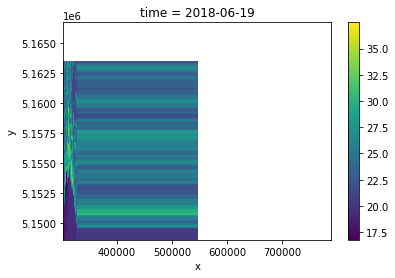

In [27]:
agglom_landsat_da.isel(time=1).plot()

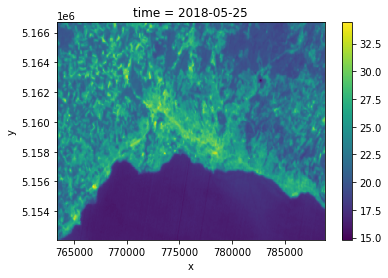

In [19]:
lst_da.plot()

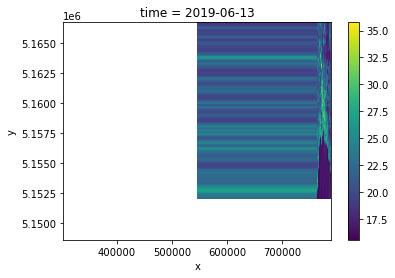

In [8]:
lst_da.isel(time=3).plot()

In [ ]:
import logging
import tempfile
from os import path

import click
import geopandas as gpd
import numpy as np
import pandas as pd
import pylandsat
import salem
import xarray as xr
from rio_toa import brightness_temp

from lausanne_greening_scenarios import geo_utils, settings

DATETIME_FMT = '%Y-%m-%d'

LANDSAT_FILES = ['B3.TIF', 'B4.TIF', 'B5.TIF', 'B10.TIF', 'MTL.txt']
LANDSAT_META_KEYS = ['RADIOMETRIC_RESCALING', 'TIRS_THERMAL_CONSTANTS']
LANDSAT_NODATA = 0

# TODO: the "parameters" should be customizable by means of arguments or a
# settings module
C = 0.005
ndvi_soil = 0.2
ndvi_veg = 0.5
eps_water = 0.991
eps_soil = 0.996
eps_veg = 0.973

lambd = 10.895e-9
rho = 1.439e-2  # 6.626e-34 * 2.998e8 / 1.38e-23


def compute_ndvi(landsat_ds):
    # ground emissivity (bands 4 and 5)
    b4_arr = landsat_ds['red'].values.astype(np.int32)
    b5_arr = landsat_ds['nir'].values.astype(np.int32)
    # nan values and zero division
    b4_plus_b5_arr = b5_arr + b4_arr

    return np.where(b4_plus_b5_arr == 0, LANDSAT_NODATA,
                    (b5_arr - b4_arr) / b4_plus_b5_arr)


def compute_lst(landsat_ds, mtl_dict, water_body_mask):
    # brightness temperature (band 10)
    radio_rescale = mtl_dict['RADIOMETRIC_RESCALING']
    thermal_constants = mtl_dict['TIRS_THERMAL_CONSTANTS']
    bt_arr = brightness_temp.brightness_temp(
        landsat_ds['tirs'].values, radio_rescale['RADIANCE_MULT_BAND_10'],
        radio_rescale['RADIANCE_ADD_BAND_10'],
        thermal_constants['K1_CONSTANT_BAND_10'],
        thermal_constants['K2_CONSTANT_BAND_10']) - 273.15

    ndvi_arr = compute_ndvi(landsat_ds)
    min_ndvi = ndvi_arr.min()
    pv_arr = np.square((ndvi_arr - min_ndvi) / (ndvi_arr.max() - min_ndvi))

    eps_arr = np.zeros_like(pv_arr)
    eps_arr[water_body_mask] = eps_water
    eps_arr[(ndvi_arr < ndvi_soil) & ~water_body_mask] = eps_soil
    mid_cond = (ndvi_arr >= ndvi_soil) & (ndvi_arr <
                                          ndvi_veg) & ~water_body_mask
    pv_mid_arr = pv_arr[mid_cond]
    eps_arr[mid_cond] = eps_veg * pv_mid_arr + eps_soil * (1 - pv_mid_arr) + C
    eps_arr[(ndvi_arr >= ndvi_veg) & ~water_body_mask] = eps_veg

    # land surface temperature (putting it all together)
    # lst_arr = bt_arr / (1 + (lambd * bt_arr / rho) * np.log(eps_arr))
    lst_arr = bt_arr / (1 + (lambd * bt_arr / rho) * np.log(eps_arr))
    # correct for potential infinities arising from divisions by zero
    # (landsat 8's nodata)
    # lst_arr[~landsat_mask] = landsat_meta['nodata']
    # return np.nan_to_num(lst_arr, LANDSAT_NODATA)
    return lst_arr


def get_lst_da(landsat_tile,
               ref_geom=None,
               lake_geom=None,
               crs=None,
               roi=False,
               subset_kws=None,
               roi_kws=None):
    product = pylandsat.Product(landsat_tile)

    with tempfile.TemporaryDirectory() as tmp_dir:
        product.download(tmp_dir, files=LANDSAT_FILES)

        landsat_tile_dir = path.join(tmp_dir, landsat_tile)

        scene = pylandsat.Scene(landsat_tile_dir)
        bands = scene.available_bands()
        band_filepaths = [getattr(scene, band).fpath for band in bands]

        # create xarray dataset
        landsat_ds = xr.Dataset({
            band: salem.open_xr_dataset(band_filepath)['data']
            for band, band_filepath in zip(bands, band_filepaths)
        })
    # projection attributes need to be set before any geo-transformation
    proj_attrs = landsat_ds[bands[0]].attrs.copy()
    landsat_ds.attrs = proj_attrs

    # landsat metadata that will be used below
    mtl_dict = scene.mtl

    # crop to the reference extent
    landsat_ds = geo_utils.clip_ds_to_extent(landsat_ds,
                                             geometry=ref_geom,
                                             crs=crs,
                                             roi=roi,
                                             subset_kws=subset_kws,
                                             roi_kws=roi_kws)

    # the lake mask needs to be boolean for NumPy slicing to work properly
    lake_mask = landsat_ds.salem.grid.region_of_interest(geometry=lake_geom,
                                                         crs=crs).astype(bool)

    # LST
    lst_arr = compute_lst(landsat_ds, mtl_dict, lake_mask)

    # assemble the final dataset
    dims = ('y', 'x')
    coords = {
        'x': landsat_ds.salem.grid.x_coord,
        'y': landsat_ds.salem.grid.y_coord
    }
    landsat_features_da = xr.DataArray(lst_arr,
                                       dims=dims,
                                       coords=coords,
                                       attrs=proj_attrs)
    # add the date
    landsat_features_da = landsat_features_da.assign_coords({
        'time':
        pd.to_datetime(mtl_dict['PRODUCT_METADATA']['DATE_ACQUIRED'])
    })

    return landsat_features_da


@click.argument('dst_filepath', type=click.Path())
@click.option('--buffer-dist', default=2000)
def main(landsat_tiles_filepath, agglom_extent_filepath, dst_filepath,
         buffer_dist):
    logger = logging.getLogger(__name__)

    # read list of landsat tiles (product ids) to process
    landsat_tiles = pd.read_csv(landsat_tiles_filepath, header=None)[0]

    # get the agglomeration and lake extents
    agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
    crs = agglom_extent_gdf.crs
    ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
    lake_geom = agglom_extent_gdf.loc[1]['geometry']

    # process the list of tiles
    datasets = []
    for landsat_tile in landsat_tiles:
        ds = get_lst_da(landsat_tile,
                        ref_geom=ref_geom,
                        lake_geom=lake_geom,
                        crs=crs)
        datasets.append(ds)

    agglom_landsat_ds = xr.concat(datasets, dim='time')
    agglom_landsat_ds.to_netcdf(dst_filepath)
    logger.info("dumped landsat features dataset to %s", dst_filepath)


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format=settings.DEFAULT_LOG_FMT)

    main()

In [ ]:
class_metrics_df = ba.compute_class_metrics_df(metrics=['total_area']).reset_index(level=1)
# class_metrics_df['buffer_dists'] = class_metrics_df['buffer_dists'].apply(lambda s: int(s.split('-')[1]))

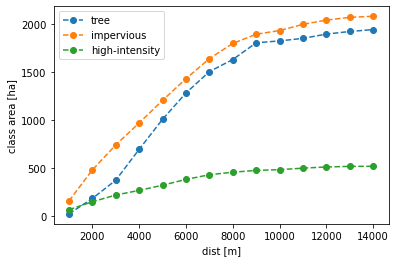

In [90]:
for class_val, class_df in class_metrics_df.groupby(class_metrics_df.index):
    plt.plot(buffer_dists, class_df['total_area'].cumsum(), '--o', label=label_dict[class_val])
plt.xlabel('dist [m]')
plt.ylabel('class area [ha]')
plt.legend()

class_val
1      24.78
1     185.22
1      374.6
1     695.98
1     1007.7
1    1280.92
1    1503.38
1    1628.61
1     1802.3
1    1821.99
1     1848.2
1    1892.81
1    1919.71
1    1939.74
Name: total_area, dtype: object

In [62]:
ba.masks_arr

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [20]:
def plot(lulc_arr, df):
    plt.imshow(np.isin(lulc_arr, df['lucode']))

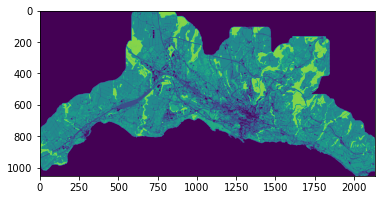

In [8]:
plt.imshow(lulc_arr)

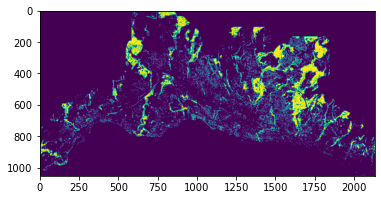

In [21]:
plot(lulc_arr, biophysical_df[biophysical_df['shade'] > .75])

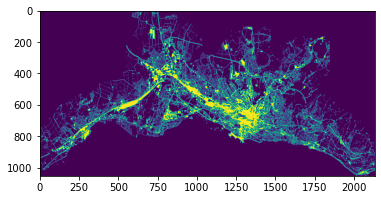

In [23]:
plot(lulc_arr, biophysical_df[(biophysical_df['green_area'] == 0) & (biophysical_df['shade'] < .75)])

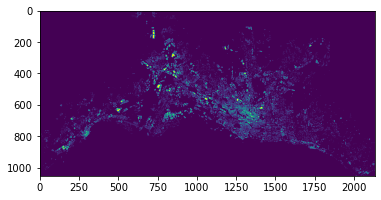

In [ ]:
plot(lulc_arr, biophysical_df[biophysical_df['building_intensity'] > .75])